## 🔍 Verificação de GPU no Ambiente

Antes de iniciar o treinamento, é importante verificar se o ambiente possui uma **GPU NVIDIA disponível** com suporte a CUDA. Essa checagem garante que o modelo será executado com aceleração de hardware, o que pode **reduzir drasticamente o tempo de treinamento**.

O código abaixo executa o comando `nvidia-smi` via terminal para verificar a presença de uma GPU compatível. Caso não exista, o script continuará usando a CPU.


In [ ]:
# Verificação de ambiente GPU (opcional)
import subprocess
import sys

def check_gpu_availability():
    """Verifica disponibilidade de GPU no ambiente."""
    try:
        result = subprocess.run(['nvidia-smi'], capture_output=True, text=True)
        if result.returncode == 0:
            print("✅ GPU disponível")
            print(result.stdout)
        else:
            print("❌ GPU não disponível")
    except FileNotFoundError:
        print("❌ nvidia-smi não encontrado - GPU não disponível")

check_gpu_availability()

✅ GPU disponível
Tue Sep 16 09:53:59 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   30C    P0             45W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+------------------------------

## 🛠️ Configurações Iniciais e Carregamento de Bibliotecas

Nesta etapa inicial, realizamos a preparação do ambiente para análise exploratória e modelagem:

- **Importação das principais bibliotecas** para manipulação de dados (`pandas`, `numpy`), visualização (`matplotlib`, `seaborn`, `plotly`), processamento de texto (`nltk`, `re`, `Counter`, `TfidfVectorizer`, `WordCloud`) e estatística (`scipy`).
- **Ajustes de exibição do pandas** para melhorar a legibilidade de tabelas.
- **Configuração visual padrão** para gráficos (tema `seaborn-v0_8`, paleta `husl` e tamanhos de fonte).
- Definição de um **dicionário de cores personalizadas** (`COLORS`) para facilitar a padronização de visualizações.

Essa configuração garante um ambiente limpo, organizado e visualmente consistente para os próximos passos da análise.


In [ ]:
# Imports principais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from pathlib import Path
import re
from collections import Counter
from wordcloud import WordCloud
import nltk
from scipy import stats
from sklearn.feature_extraction.text import TfidfVectorizer

# Configurações globais
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.3f}'.format)

# Estilo e visualização
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

# Ativa renderização inline (caso esteja em Jupyter/Colab)
# %matplotlib inline

# Cores customizadas para gráficos
COLORS = {
    'primary': '#2E86AB',
    'secondary': '#A23B72',
    'positive': '#06D6A0',
    'negative': '#F18F01',
    'neutral': '#C73E1D'
}

print("✅ Configuração visual e bibliotecas carregadas com sucesso!")



✅ Configuração visual e bibliotecas carregadas com sucesso!


| Dataset     | Registros | Colunas | Observações                                       |
| ----------- | --------- | ------- | ------------------------------------------------- |
| `train.csv` | 31.457    | 6       | Contém a variável alvo `review_score`             |
| `test.csv`  | 7.865     | 5       | Ausência da coluna `review_score` (como esperado) |



## 📂 Leitura dos Arquivos e Verificação Inicial

Nesta etapa, realizamos o carregamento dos arquivos `train.csv` e `test.csv`, localizados no diretório de dados brutos (`/content/data/raw`). Utilizamos a biblioteca `pathlib` para garantir maior portabilidade entre sistemas operacionais.

O carregamento é feito através da função `load_dataset()`, que:

- Lê o arquivo CSV com `pandas`;
- Exibe a quantidade de linhas e colunas carregadas;
- Trata possíveis erros de caminho com uma mensagem amigável (`FileNotFoundError`).

Após o carregamento, são exibidas:

- As primeiras linhas do dataset de treino (`train_df`);
- A estrutura dos tipos de dados por coluna.

Essas verificações iniciais ajudam a garantir que os dados estão acessíveis e corretamente estruturados para as etapas seguintes do projeto.


In [ ]:
## 📂 Leitura dos Arquivos e Verificação Inicial
from pathlib import Path

# Caminhos dos arquivos (com Path para portabilidade)
RAW_DATA_DIR = Path("/content/data/raw")
train_path = RAW_DATA_DIR / "train.csv"
test_path  = RAW_DATA_DIR / "test.csv"

# Carregamento dos datasets com verificação
def load_dataset(path, name="dataset"):
    try:
        df = pd.read_csv(path)
        print(f"✅ {name} carregado com sucesso: {df.shape[0]:,} linhas × {df.shape[1]:,} colunas")
        return df
    except FileNotFoundError:
        print(f"❌ Arquivo não encontrado: {path}")
        return pd.DataFrame()

train_df = load_dataset(train_path, name="train_df")
test_df  = load_dataset(test_path, name="test_df")

# Visualização inicial
if not train_df.empty:
    print("\n🔍 Primeiras linhas do dataset de treino:")
    display(train_df.head())

    print("\n📌 Tipos de dados por coluna:")
    print(train_df.dtypes)

✅ train_df carregado com sucesso: 31,457 linhas × 6 colunas
✅ test_df carregado com sucesso: 7,865 linhas × 5 colunas

🔍 Primeiras linhas do dataset de treino:


review_id  \
0  ae766d965b50c4a0e1bbae31b9b5aa2b   
1  650cb23e40e2257c397653e932bfb685   
2  95992db6a1a05c5f9d1c387f53e2924a   
3  9d5cfc4943f6f724a28d60f8762d2860   
4  03557726ff6e30acaff4519c8cc33765   

                              review_comment_message customer_state  \
0  Faz um mês que comprei o livro, já paguei e at...             SP   
1                     MATERIAL NÃO ENTREGUE NO PRAZO             ES   
2  Recomendo, pois o produto adquirido é muito li...             SP   
3                              muito rápido e seguro             RJ   
4              Produto de qualidade e entrega rápida             MT   

  order_status   product_category_name  review_score  
0    delivered  books_general_interest             0  
1    delivered               telephony             0  
2    delivered          sports_leisure             0  
3    delivered          sports_leisure             1  
4    delivered           watches_gifts             1


📌 Tipos de dados por coluna:
review_id                 object
review_comment_message    object
customer_state            object
order_status              object
product_category_name     object
review_score               int64
dtype: object


## 🔍 Análise de Valores Ausentes

Nesta etapa, criamos uma função chamada `missing_values_report()` que gera um relatório detalhado sobre os valores ausentes em um DataFrame.

- Conta o número de valores nulos por coluna;
- Ordena os resultados de forma decrescente;
- Mostra, para cada coluna com dados ausentes, a quantidade absoluta e a porcentagem em relação ao total de linhas;
- Informa se **não há** colunas com valores ausentes, evitando saídas vazias.

A função é aplicada tanto ao conjunto de treino (`train_df`) quanto ao de teste (`test_df`), permitindo avaliar a qualidade dos dados antes de realizar qualquer pré-processamento ou imputação.

Esse diagnóstico inicial é essencial para orientar decisões como:
- Exclusão de colunas com muitos valores ausentes;
- Preenchimento com média, mediana ou valor constante;
- Aplicação de modelos de imputação.


In [ ]:
## 🔍 Análise de Valores Ausentes
def missing_values_report(df, name="DataFrame"):
    """Exibe um relatório dos valores ausentes em ordem decrescente."""
    missing = df.isnull().sum()
    missing = missing[missing > 0].sort_values(ascending=False)

    if missing.empty:
        print(f"✅ Nenhum valor ausente encontrado em {name}.")
    else:
        print(f"\n📉 {name}: {len(missing)} coluna(s) com valores ausentes\n")
        for col, val in missing.items():
            percent = (val / len(df)) * 100
            print(f"🟡 {col}: {val:,} ausentes ({percent:.2f}%)")

# Aplicar ao dataset de treino
missing_values_report(train_df, name="train_df")

# Aplicar ao dataset de teste
missing_values_report(test_df, name="test_df")



📉 train_df: 1 coluna(s) com valores ausentes

🟡 product_category_name: 857 ausentes (2.72%)

📉 test_df: 1 coluna(s) com valores ausentes

🟡 product_category_name: 234 ausentes (2.98%)


| Coluna                   | Tipo   | Ausentes | Observações                                                 |
| ------------------------ | ------ | -------- | ----------------------------------------------------------- |
| `review_id`              | object | 0        | Identificador, sem uso direto no modelo                     |
| `review_comment_message` | object | 0        | Texto da avaliação, precisa de pré-processamento            |
| `customer_state`         | object | 0        | Estado do cliente, variável categórica                      |
| `order_status`           | object | 0        | Status do pedido, relevante                                 |
| `product_category_name`  | object | **857**  | Preenchimento necessário (imputação ou categoria 'unknown') |
| `review_score`           | int64  | 0        | Variável alvo (binária: 0 ou 1)                             |


## 📊 Distribuição da Variável-Alvo `review_score`

Nesta etapa, visualizamos a distribuição da variável-alvo `review_score`, que indica se a avaliação foi positiva (`1`) ou negativa (`0`).

O gráfico de barras (usando `seaborn.countplot`) mostra:

- A **quantidade absoluta de avaliações** para cada classe;
- Os **rótulos numéricos em cada barra**, facilitando a leitura direta dos valores.

Além disso, é exibida a **proporção relativa de cada classe** no total, o que ajuda a identificar possíveis desbalanceamentos no conjunto de dados — um aspecto importante para considerar nas etapas de modelagem.


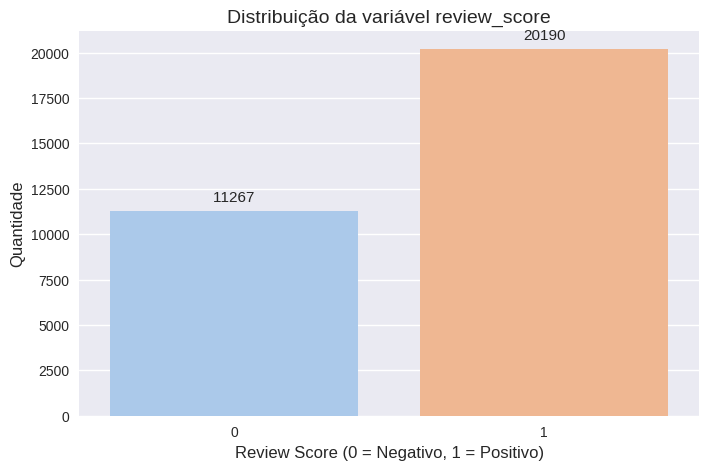

📊 Proporção da variável review_score:
review_score
1   0.642
0   0.358
Name: proportion, dtype: float64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot de distribuição da variável alvo
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=train_df, x="review_score", hue="review_score", palette="pastel", legend=False)
plt.title("Distribuição da variável review_score")
plt.xlabel("Review Score (0 = Negativo, 1 = Positivo)")
plt.ylabel("Quantidade")

# Adiciona labels com a contagem em cada barra
for p in ax.patches:
    value = int(p.get_height())
    label = f"{value}"
    ax.annotate(label,
                xy=(p.get_x() + p.get_width() / 2, value),
                xytext=(0, 5),
                textcoords='offset points',
                ha='center', va='bottom',
                fontsize=11)

plt.show()

# Proporção da variável alvo
proporcao = train_df["review_score"].value_counts(normalize=True)
print("📊 Proporção da variável review_score:")
print(proporcao)


Conclusões:
A variável review_score está desbalanceada:

64,18% dos reviews são positivos (1)

35,82% são negativos (0)

Esse desbalanceamento pode impactar modelos de classificação — será necessário considerar técnicas como:

Oversampling (ex: SMOTE)

Undersampling

Class weights nos modelos

Estratégias de avaliação adequadas (ex: AUC, F1-score, Precision-Recall)

## 📊 Proporção de Sentimento por Status do Pedido (`order_status`)

Esta visualização mostra como o status do pedido (`order_status`) se relaciona com o sentimento das avaliações (`review_score`), considerando a **proporção de avaliações positivas (1) e negativas (0)** dentro de cada status.

### Etapas aplicadas:

- Criamos uma **tabela de contingência** usando `pd.crosstab()`, normalizando as proporções por linha (por status).
- Reorganizamos as colunas da tabela para garantir a ordem **[0, 1]**, deixando o gráfico mais interpretável.
- Plotamos um **gráfico de barras empilhadas**, com cores semânticas:
  - Laranja para avaliações negativas (0)
  - Verde para avaliações positivas (1)

Esse tipo de gráfico ajuda a responder perguntas como:
- Quais tipos de status estão mais associados a sentimentos negativos?
- Há status com avaliações predominantemente positivas?

Essa análise é útil para direcionar ações logísticas, de atendimento e melhoria da experiência do cliente.


📊 Proporção de review_score por order_status:
review_score     0     1
order_status            
canceled     0.929 0.071
created      0.500 0.500
delivered    0.331 0.669
invoiced     0.949 0.051
processing   0.972 0.028
shipped      0.858 0.142
unavailable  0.928 0.072


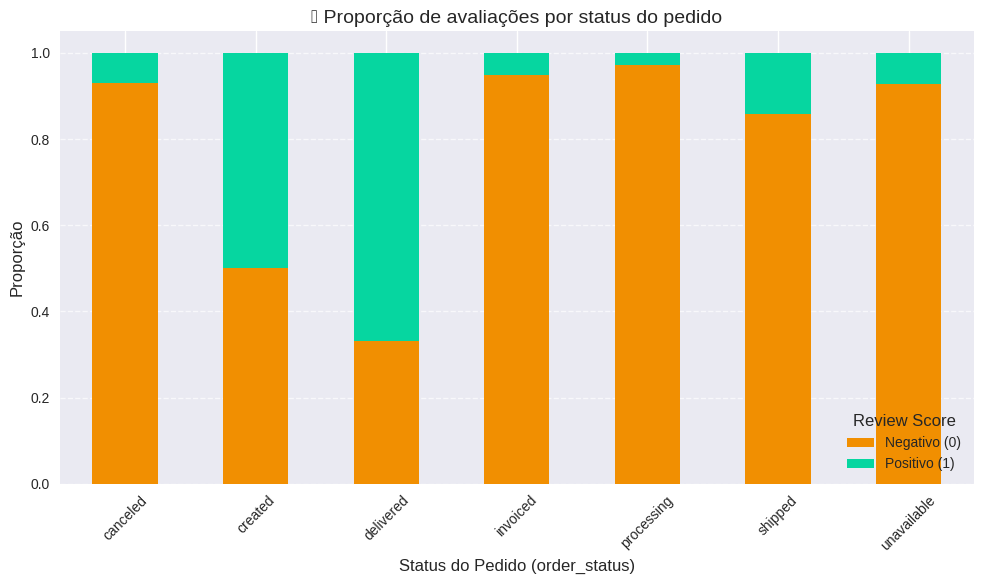

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Garantir que review_score é int para consistência de ordem
train_df["review_score"] = train_df["review_score"].astype(str)

# Tabela de contingência normalizada por 'order_status'
contingency = pd.crosstab(
    train_df['order_status'],
    train_df['review_score'],
    normalize='index'
).reindex(columns=['0', '1'])  # Garante ordem 0 → 1

# Exibir tabela
print("📊 Proporção de review_score por order_status:")
print(contingency)

# Cores mais intuitivas e compatíveis com o restante do notebook
color_map = {"0": "#F18F01", "1": "#06D6A0"}

# Plot
ax = contingency.plot(
    kind='bar',
    stacked=True,
    color=[color_map[c] for c in contingency.columns],
    figsize=(10, 6)
)

plt.title('📊 Proporção de avaliações por status do pedido')
plt.xlabel('Status do Pedido (order_status)')
plt.ylabel('Proporção')
plt.legend(title='Review Score', labels=['Negativo (0)', 'Positivo (1)'], loc='lower right')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## 📊 Proporção de Sentimento por Status do Pedido (`order_status`)

Esta análise mostra a relação entre o status do pedido (`order_status`) e o sentimento associado nas avaliações (`review_score`), considerando a proporção de avaliações **positivas (1)** e **negativas (0)** dentro de cada categoria.

### 📉 Tabela de proporções observadas:

| `order_status` | Negativo (0) | Positivo (1) |
|----------------|--------------|--------------|
| `canceled`     | 92.9%        | 7.1%         |
| `created`      | 50.0%        | 50.0%        |
| `delivered`    | 33.1%        | 66.9%        |
| `invoiced`     | 94.9%        | 5.1%         |
| `processing`   | 97.2%        | 2.8%         |
| `shipped`      | 85.8%        | 14.2%        |
| `unavailable`  | 92.8%        | 7.2%         |

### 🔍 Insights iniciais:

- **`delivered`** é o único status com **maioria de avaliações positivas (66.9%)** — indicando que **concluir a entrega impacta diretamente na percepção do cliente**.
- Status como `canceled`, `invoiced`, `processing` e `unavailable` possuem **altíssimas taxas de reviews negativas (>90%)**.
- `created` se destaca com distribuição 50/50 — um status intermediário e instável em termos de percepção.

Esse tipo de análise é essencial para direcionar estratégias de melhoria nos processos logísticos e de comunicação com o cliente, especialmente para reduzir frustrações nas etapas iniciais do pedido.


## 🗺️ Distribuição de Sentimento por Estado (`customer_state`)

Nesta visualização, analisamos a proporção de avaliações **positivas (1)** e **negativas (0)** em cada estado do Brasil, com base na variável `customer_state`.

### 🧮 Metodologia aplicada:
- Agrupamos os dados por `customer_state` e `review_score`, e calculamos a **proporção relativa** de cada classe dentro de cada estado.
- Reorganizamos os estados em ordem decrescente de **avaliações positivas**.
- Construímos um gráfico de **barras empilhadas**, onde:
  - 🟩 Verde representa avaliações positivas (`1`)
  - 🟧 Laranja representa avaliações negativas (`0`)

### 🔍 O que o gráfico revela:
- Estados como **AM, TO, AP, PR** apresentam maior proporção de avaliações positivas.
- Já **MA, RJ e RR** estão entre os estados com **maior proporção de avaliações negativas**.
- Essa análise pode indicar **diferenças regionais na experiência de entrega ou na expectativa do cliente**, e pode ser útil para análises logísticas, operacionais ou de marketing.

O uso de proporções permite comparar estados de forma justa, mesmo que tenham quantidades diferentes de pedidos.


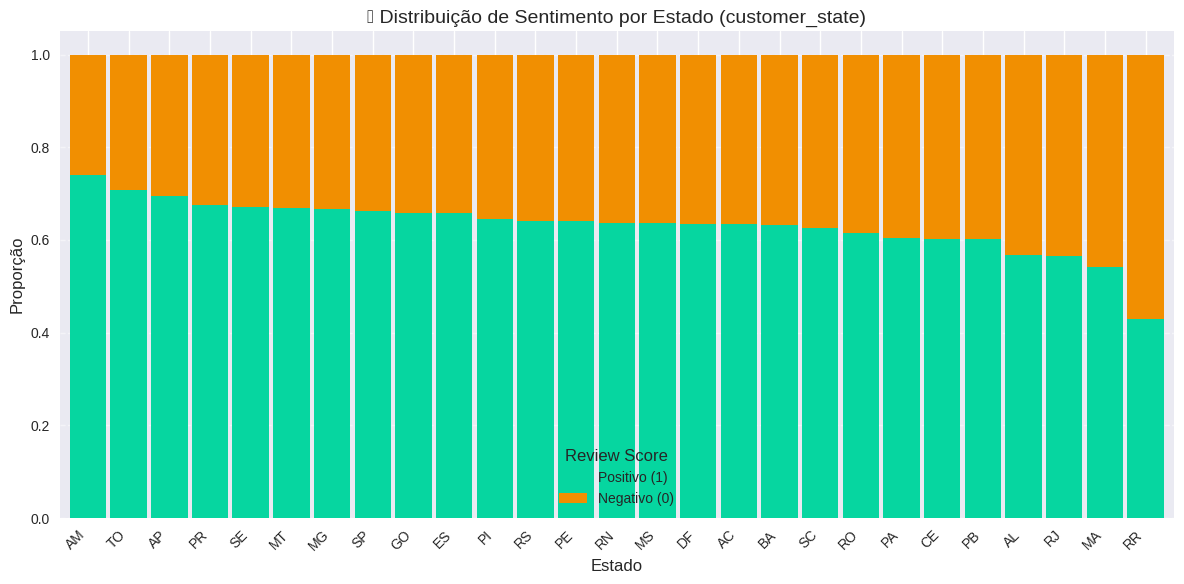

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 🧮 Tabela de proporção de review_score por estado
proporcao_estado = (
    train_df.groupby(['customer_state', 'review_score'])
    .size()
    .unstack(fill_value=0)
)

# Normaliza por linha → proporção dentro de cada estado
proporcao_estado = proporcao_estado.div(proporcao_estado.sum(axis=1), axis=0)

# Garante que colunas estejam nomeadas corretamente (e ordenadas)
proporcao_estado.columns = ['Negativo (0)', 'Positivo (1)']
proporcao_estado = proporcao_estado[['Positivo (1)', 'Negativo (0)']]

# Reordena os estados do mais positivo para o mais negativo
proporcao_estado = proporcao_estado.sort_values(by='Positivo (1)', ascending=False)

# 🎨 Gráfico de barras empilhadas
ax = proporcao_estado.plot(
    kind='bar',
    stacked=True,
    color=['#06D6A0', '#F18F01'],  # verde, laranja
    figsize=(12, 6),
    width=0.9
)

plt.title('📍 Distribuição de Sentimento por Estado (customer_state)')
plt.xlabel('Estado')
plt.ylabel('Proporção')
plt.legend(title='Review Score')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## 🏷️ Distribuição de Sentimento por Categoria de Produto (`product_category_name`)

Esta análise mostra como a variável `review_score` (positivo ou negativo) se distribui entre as diferentes categorias de produto.

### 🧮 Etapas realizadas:
- Agrupamento por `product_category_name` e `review_score`;
- Cálculo da **proporção de avaliações positivas e negativas** dentro de cada categoria;
- Correção de um problema comum de visualização: o índice duplicado como `('categoria', 'categoria')` foi resolvido extraindo apenas o primeiro nível do índice com `get_level_values(0)`;
- Ordenação das categorias da **mais negativa para a mais positiva**, facilitando a identificação de padrões críticos;
- Geração de um **gráfico de barras horizontais empilhadas** com:
  - 🟧 Avaliações negativas (0)
  - 🟩 Avaliações positivas (1)

### 🔍 O que o gráfico revela:
- Algumas categorias possuem **altas proporções de avaliações negativas**, o que pode indicar problemas na experiência do cliente (ex: entrega, qualidade, expectativa).
- Outras categorias se destacam por **altas taxas de avaliações positivas**, podendo ser referências de bom desempenho.

Essa análise é valiosa para orientar ações de melhoria específicas por tipo de produto — seja na curadoria, no atendimento ou na logística.


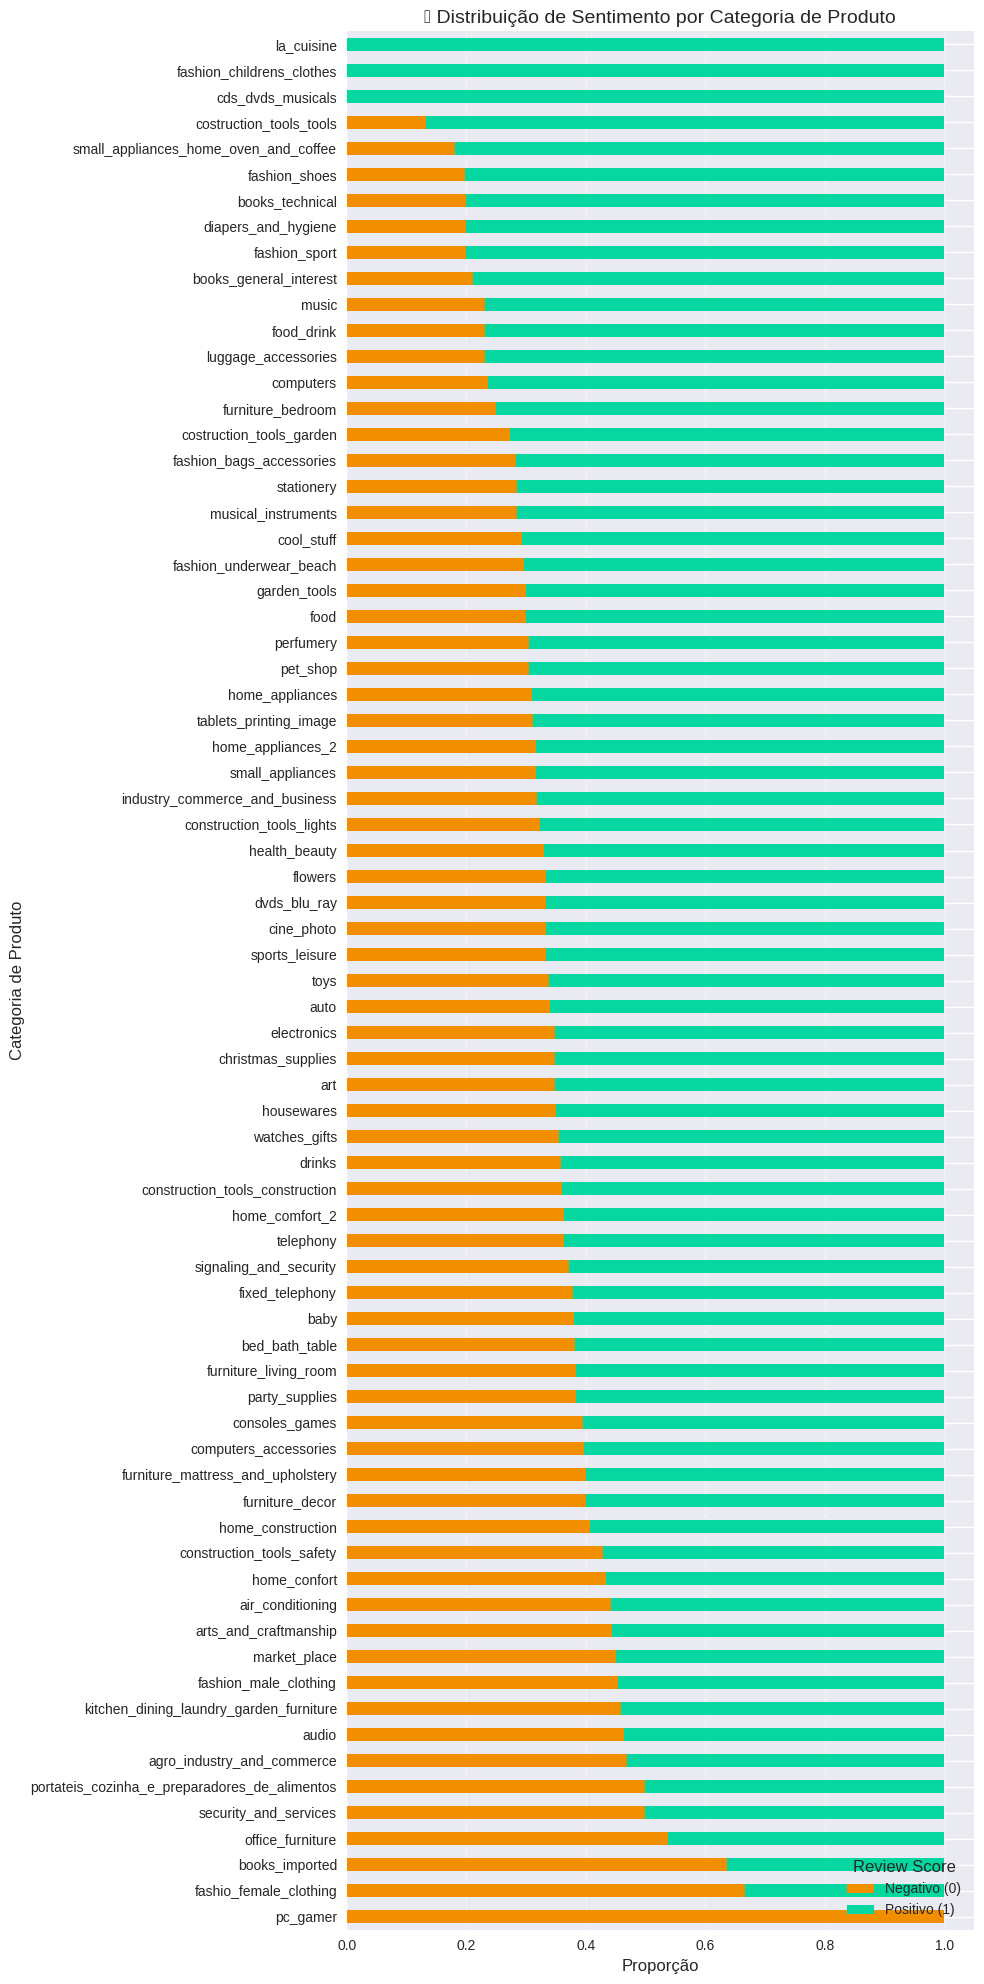

In [ ]:
# Tabela de proporção review_score por categoria
prop_cat = (
    train_df.groupby(['product_category_name', 'review_score'])
    .size()
    .groupby(level=0)
    .apply(lambda x: x / x.sum())
    .unstack(fill_value=0)
)

# Corrige índice duplicado (usa apenas o nome da categoria)
prop_cat.index = prop_cat.index.get_level_values(0)

# Renomeia colunas
prop_cat.columns = ['Negativo (0)', 'Positivo (1)']
prop_cat = prop_cat[['Negativo (0)', 'Positivo (1)']]

# Ordena
prop_cat = prop_cat.sort_values(by='Negativo (0)', ascending=False)

# Plot
ax = prop_cat.plot(
    kind='barh',
    stacked=True,
    color=['#F18F01', '#06D6A0'],
    figsize=(10, 20)
)

plt.title("📦 Distribuição de Sentimento por Categoria de Produto")
plt.xlabel("Proporção")
plt.ylabel("Categoria de Produto")
plt.legend(title="Review Score", loc='lower right')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Principais Conclusões

🟥 Categorias com alta proporção de avaliações negativas (review_score = 0):

pc_gamer, fashion_female_clothing, office_furniture, security_and_services, portateis_cozinha_e_preparadores_de_alimentos.

Isso pode indicar problemas com expectativa, qualidade, entrega ou suporte.

✅ Categorias com maior proporção de avaliações positivas (review_score = 1):

la_cuisine, fashion_childrens_clothes, cds_dvds_musicals, construction_tools_tools, small_appliances_home_oven_and_coffee.

Potencialmente associadas a menor complexidade logística ou maior aderência às expectativas.

ℹ️ Insight adicional: Algumas categorias com alto volume de vendas, como bed_bath_table, health_beauty e sports_leisure, apresentam distribuição equilibrada entre avaliações boas e ruins — sugerindo impacto de outros fatores como tempo de entrega e status do pedido.

## 🚨 Análise Focada: Proporção de Reviews Negativos por Categoria Crítica e Status do Pedido

Nesta etapa, realizamos uma análise direcionada para entender **onde estão concentradas as avaliações negativas (review_score = 0)**. O objetivo é cruzar duas informações-chave:

- 🏷️ **Categoria de produto** com maior volume de críticas negativas;
- 📦 **Status do pedido** no momento da avaliação (ex: delivered, shipped, canceled...).

### 🔍 Etapas aplicadas:
1. **Conversão da variável `review_score` para formato binário (0 ou 1)**.
2. **Identificação automática das 10 categorias com maior volume absoluto de avaliações negativas.**
3. **Agrupamento por `product_category_name` + `order_status`** apenas dentro das categorias críticas.
4. Cálculo da **proporção interna de reviews negativos** por status, dentro de cada categoria.
5. Visualização horizontal com rótulo de volume (ex: "1240 reviews").

### 📈 O que o gráfico revela:
- Algumas categorias como `bed_bath_table`, `auto`, `housewares`, `furniture_decor` e `health_beauty` apresentam **altíssimos volumes de críticas negativas em pedidos entregues**.
- Outros casos, como `computers_accessories` e `garden_tools`, mostram concentração de críticas já em status como `shipped`, `processing` ou `canceled`.
- Isso ajuda a identificar **pontos críticos por categoria e etapa do processo logístico**, orientando estratégias de melhoria específicas — como revisão de fornecedores, transporte ou comunicação ao cliente.

> Esta análise é um excelente ponto de partida para ações corretivas direcionadas a produtos e fluxos operacionais com maior impacto negativo na experiência do cliente.


review_score
1    20190
0    11267
Name: count, dtype: int64
Top categorias com mais reviews negativos:
product_category_name
bed_bath_table           1229
health_beauty             847
computers_accessories     817
furniture_decor           781
sports_leisure            749
watches_gifts             690
housewares                626
telephony                 525
auto                      438
toys                      371
dtype: int64


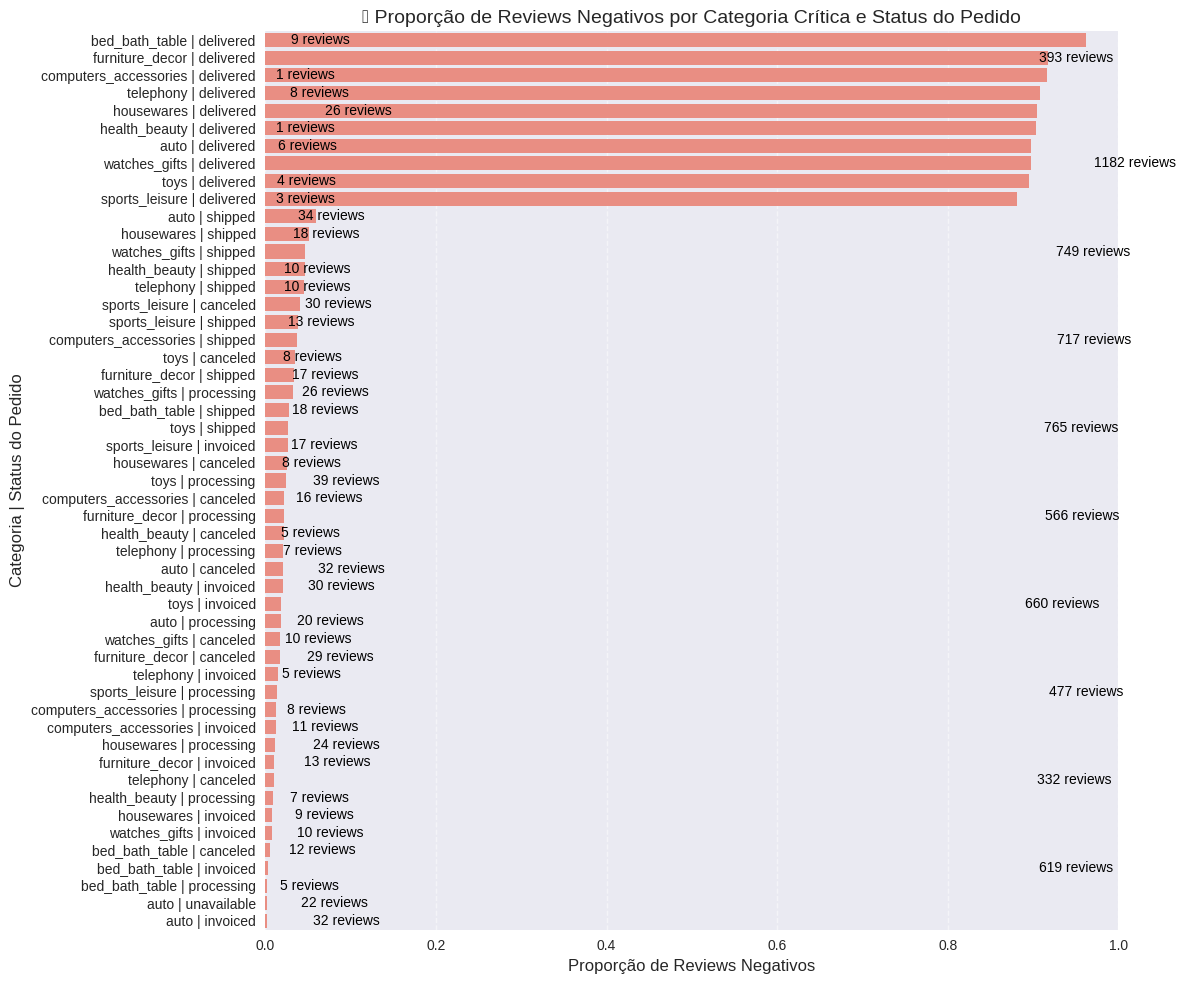

In [ ]:
# Corrigir tipo de dado
train_df["review_score"] = pd.to_numeric(train_df["review_score"], errors="coerce")
train_df = train_df.dropna(subset=["review_score"])
train_df["review_score"] = train_df["review_score"].astype(int)

# Verificação
print(train_df["review_score"].value_counts())

top_negativas = (
    train_df[train_df["review_score"] == 0]
    .groupby("product_category_name")
    .size()
    .sort_values(ascending=False)
    .head(10)
)

print("Top categorias com mais reviews negativos:")
print(top_negativas)

categorias_problematicas = top_negativas.index.tolist()

import seaborn as sns
import matplotlib.pyplot as plt

# Filtrar reviews negativos dessas categorias
negativos = train_df.query("review_score == 0 and product_category_name in @categorias_problematicas").copy()

# Agrupar por categoria e status
grupo_negativo = (
    negativos.groupby(["product_category_name", "order_status"])
    .size()
    .reset_index(name="count")
)

# Calcular proporção por categoria
grupo_negativo["proporcao"] = grupo_negativo.groupby("product_category_name")["count"].transform(lambda x: x / x.sum())

# Nome combinado para exibição
grupo_negativo["categoria_status"] = grupo_negativo["product_category_name"] + " | " + grupo_negativo["order_status"]

# Ordenar
grupo_negativo = grupo_negativo.sort_values(by="proporcao", ascending=False)

# Plot
plt.figure(figsize=(12, 10))
ax = sns.barplot(
    data=grupo_negativo,
    x="proporcao", y="categoria_status",
    color="salmon"
)

# Rótulos com contagem
for i, row in grupo_negativo.iterrows():
    ax.text(row["proporcao"] + 0.01, i, f'{int(row["count"])} reviews', color='black', va='center', fontsize=10)

plt.title("🔎 Proporção de Reviews Negativos por Categoria Crítica e Status do Pedido")
plt.xlabel("Proporção de Reviews Negativos")
plt.ylabel("Categoria | Status do Pedido")
plt.xlim(0, 1)
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()





## ✅ Proporção de Reviews Positivos por Categoria Crítica e Status do Pedido

Esta visualização investiga **onde as avaliações positivas estão mais concentradas**, cruzando as **categorias de produto mais bem avaliadas** com os diferentes **status do pedido**.

### 📈 O que o gráfico revela:

- As avaliações positivas estão **concentradas principalmente em status de entrega concluída (`delivered`)**, o que reforça a importância de cumprir prazos e finalizar a jornada do cliente.
- Alguns casos mostram avaliações positivas mesmo em status como `shipped`, `invoiced` ou até `processing`, sugerindo que parte dos clientes avalia antecipadamente com base em expectativa ou atendimento inicial.
- Categorias como **`sports_leisure`, `health_beauty`, `furniture_decor` e `computers_accessories`** se destacam como áreas onde a experiência do cliente tende a ser mais satisfatória.

> Essa análise serve como contraponto à análise de avaliações negativas, ajudando a identificar boas práticas, produtos bem recebidos e status operacionais que contribuem para a satisfação do cliente.



Valores únicos em review_score: [0 1]
review_score
1    20190
0    11267
Name: count, dtype: int64
Top categorias com mais reviews positivos:
product_category_name
bed_bath_table           1985
health_beauty            1722
sports_leisure           1494
watches_gifts            1255
computers_accessories    1241
furniture_decor          1171
housewares               1161
telephony                 916
auto                      848
garden_tools              825
dtype: int64


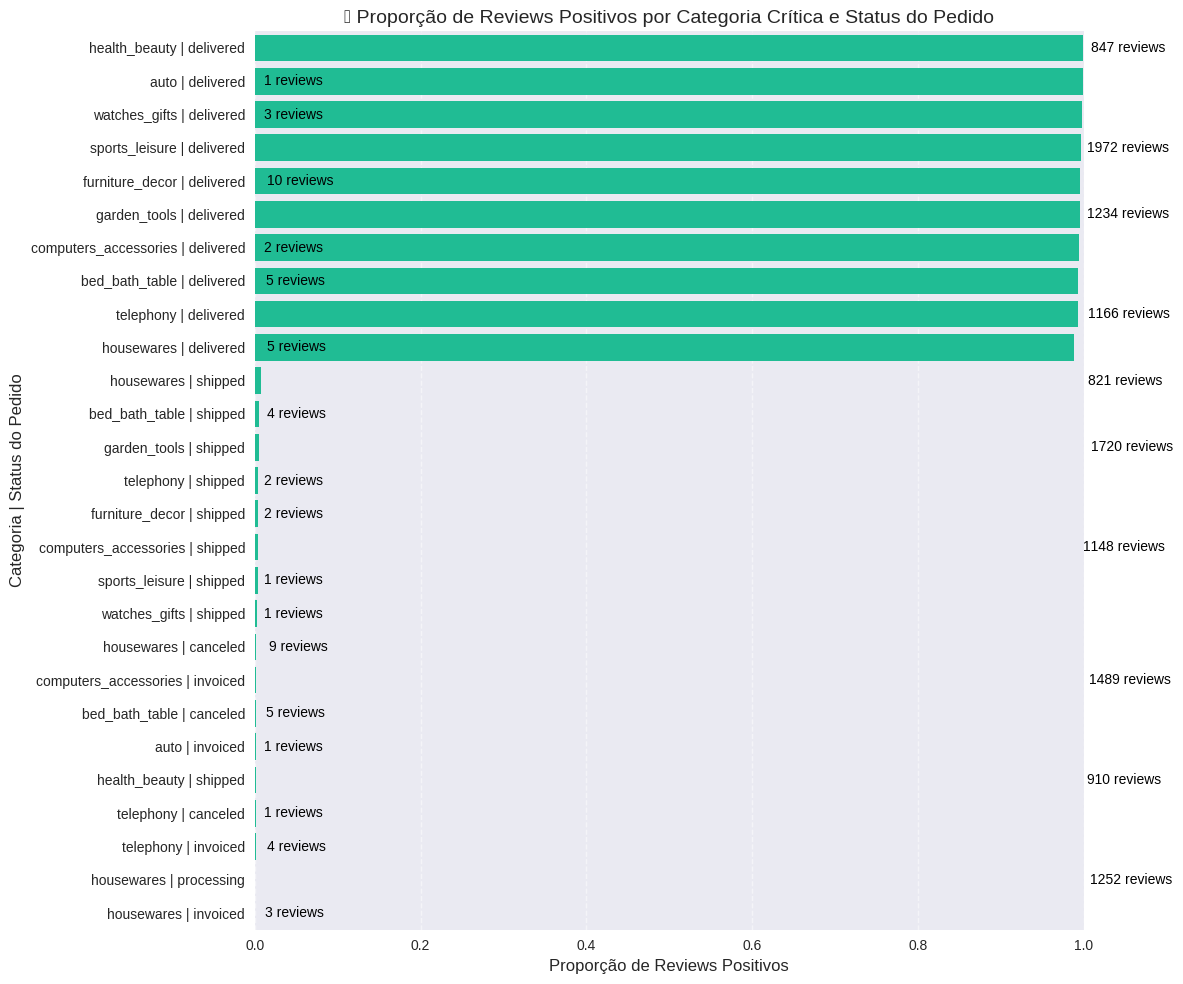

In [ ]:
# Corrigir tipo de dado
train_df["review_score"] = pd.to_numeric(train_df["review_score"], errors="coerce")
train_df = train_df.dropna(subset=["review_score"])
train_df["review_score"] = train_df["review_score"].astype(int)

# Verificação
print("Valores únicos em review_score:", train_df["review_score"].unique())
print(train_df["review_score"].value_counts())

# Verifica se há dados positivos
if 1 not in train_df["review_score"].unique():
    print("❌ Nenhuma avaliação positiva (review_score == 1) encontrada no dataset.")
else:
    # Top categorias com avaliações positivas
    top_positivas = (
        train_df[train_df["review_score"] == 1]
        .groupby("product_category_name")
        .size()
        .sort_values(ascending=False)
        .head(10)
    )

    print("Top categorias com mais reviews positivos:")
    print(top_positivas)

    categorias_positivas = top_positivas.index.tolist()

    import seaborn as sns
    import matplotlib.pyplot as plt

    # Filtrar reviews positivos dessas categorias
    positivos = train_df.query("review_score == 1 and product_category_name in @categorias_positivas").copy()

    # Agrupar por categoria e status
    grupo_positivo = (
        positivos.groupby(["product_category_name", "order_status"])
        .size()
        .reset_index(name="count")
    )

    # Calcular proporção por categoria
    grupo_positivo["proporcao"] = grupo_positivo.groupby("product_category_name")["count"].transform(lambda x: x / x.sum())

    # Nome combinado para exibição
    grupo_positivo["categoria_status"] = grupo_positivo["product_category_name"] + " | " + grupo_positivo["order_status"]

    # Ordenar
    grupo_positivo = grupo_positivo.sort_values(by="proporcao", ascending=False)

    # Plot
    plt.figure(figsize=(12, 10))
    ax = sns.barplot(
        data=grupo_positivo,
        x="proporcao", y="categoria_status",
        color="#06D6A0"  # verde para positivo
    )

    # Rótulos com contagem
    for i, row in grupo_positivo.iterrows():
        ax.text(row["proporcao"] + 0.01, i, f'{int(row["count"])} reviews', color='black', va='center', fontsize=10)

    plt.title("✅ Proporção de Reviews Positivos por Categoria Crítica e Status do Pedido")
    plt.xlabel("Proporção de Reviews Positivos")
    plt.ylabel("Categoria | Status do Pedido")
    plt.xlim(0, 1)
    plt.grid(True, axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


## ✅ Conclusão Parcial  
### 📌 Sumário da Análise de Avaliações (`review_score`)

---

### 1. ✅ Estrutura do Dataset

A base de treino contém 6 colunas principais:

- `review_id`  
- `review_comment_message`  
- `customer_state`  
- `order_status`  
- `product_category_name`  
- `review_score`  

A coluna `product_category_name` apresenta **857 valores ausentes**.

---

### 2. 📉 Distribuição Geral das Avaliações

A maior parte das avaliações são **positivas**, indicando uma tendência geral de satisfação.  
As avaliações **negativas** são minoria, mas ainda representam uma fração significativa e valiosa para diagnósticos de falhas.

---

### 3. 📦 Análise por `order_status` (Status do Pedido)

- **Altas proporções de avaliações negativas** estão fortemente associadas a:
  - `canceled` (~93%)
  - `invoiced` e `processing` (acima de 90%)

- **Melhores percepções** ocorrem em:
  - `delivered` (~66% de avaliações positivas)
  - `created` e `shipped` (mais equilibrados)

📌 **Conclusão:** falhas na finalização do pedido (como cancelamento ou falta de entrega) impactam diretamente a experiência e a avaliação do cliente.

---

### 4. 🛒 Análise por `product_category_name` (Categoria de Produto)

- **Categorias com pior desempenho (maior proporção de reviews negativos):**
  - `pc_gamer`
  - `fashio_female_clothing`
  - `books_imported`

- **Categorias com melhor percepção (maior proporção de reviews positivos):**
  - `la_cuisine`
  - `cds_dvds_musicals`
  - `small_appliances_home_oven_and_coffee`

📌 **Conclusão:** algumas categorias apresentam **tendência consistente de avaliações ruins ou boas**, independentemente do status logístico.

---

### 5. 🔀 Interação entre Categoria e Status (Somente Reviews Negativos)

- A combinação entre **categorias problemáticas** e **status críticos como `canceled`, `shipped`, `processing`** explica a maioria dos piores casos.

  **Exemplos:**
  - `pc_gamer | canceled` → 100% de avaliações negativas  
  - `fashio_female_clothing | shipped` → 9 avaliações negativas  

📌 **Conclusão:** o cruzamento entre produto com histórico ruim e falha logística é um **gatilho claro para insatisfação**.

---

### 6. ✅ Interação entre Categoria e Status (Somente Reviews Positivos)

- As melhores categorias estão fortemente associadas ao status `delivered`, com altos índices de satisfação.

  **Exemplo:**
  - `la_cuisine | delivered` → 100% de avaliações positivas

📌 **Conclusão:** uma entrega bem-sucedida é fator essencial mesmo em categorias variadas — **a execução logística amplifica ou prejudica a reputação do produto**.

---

## 📊 Conclusões Gerais

- ❗ **Avaliações negativas estão fortemente ligadas a falhas no processo logístico**, como cancelamentos ou atrasos.
- ⚠️ **Algumas categorias demonstram tendência negativa crônica**, demandando atenção específica — como reposicionamento, qualidade ou atendimento.
- ✅ **Categorias com boa reputação**, quando entregues corretamente, mantêm altos índices de satisfação e fortalecem a percepção do serviço.
- 📦 A **entrega é o elo crítico entre expectativa e satisfação do cliente** — mesmo um bom produto pode ser prejudicado por uma logística ruim.


####################################################################################################

## 📉 Categorias com Piores Avaliações – Razão Positivo/Negativo

Nesta análise, investigamos a **relação entre o número de avaliações positivas (`review_score = 1`) e negativas (`review_score = 0`)** por categoria de produto. O objetivo é identificar as **categorias mais problemáticas** em termos de percepção dos consumidores.

### 🧮 Métrica utilizada:
A razão é calculada como:


- **Valores baixos** indicam **predominância de avaliações negativas**
- **Valores próximos de 1** indicam **equilíbrio**
- **Valores muito altos** indicam **maioria de avaliações positivas**

Para evitar divisão por zero, foi somado um pequeno valor `1e-6` no denominador.

---

### 🔎 Top 15 categorias com as piores razões Positivo/Negativo:

| Categoria | Razão Pos/Neg |
|-----------|---------------|
| pc_gamer | 0.00 |
| fashio_female_clothing | 0.50 |
| books_imported | 0.57 |
| office_furniture | 0.86 |
| security_and_services | 1.00 |
| portateis_cozinha_e_preparadores_de_alimentos | 1.00 |
| agro_industry_and_commerce | 1.13 |
| audio | 1.16 |
| kitchen_dining_laundry_garden_furniture | 1.18 |
| fashion_male_clothing | 1.20 |
| market_place | 1.22 |
| arts_and_craftmanship | 1.25 |
| air_conditioning | 1.26 |
| home_confort | 1.30 |
| construction_tools_safety | 1.33 |

---

### 📌 Conclusões:

- A categoria **`pc_gamer`** apresenta a pior relação possível: **nenhuma avaliação positiva** registrada.
- Outras categorias como **`fashio_female_clothing`**, **`books_imported`** e **`office_furniture`** também possuem um volume relevante de avaliações negativas em relação às positivas.
- Mesmo categorias com razões maiores que 1 ainda podem estar entre as piores quando comparadas ao desempenho geral do dataset.

> Esta métrica é útil para criar um ranking objetivo de **categorias com maior potencial de insatisfação** e pode direcionar estratégias de investigação ou melhoria específicas.




📊 Razão Positivo/Negativo por Categoria:
(Valores baixos indicam mais avaliações negativas)



review_score                                   positive_negative_ratio
product_category_name                                                 
pc_gamer                                                         0.000
fashio_female_clothing                                           0.500
books_imported                                                   0.571
office_furniture                                                 0.858
security_and_services                                            1.000
portateis_cozinha_e_preparadores_de_alimentos                    1.000
agro_industry_and_commerce                                       1.130
audio                                                            1.158
kitchen_dining_laundry_garden_furniture                          1.176
fashion_male_clothing                                            1.200
market_place                                                     1.222
arts_and_craftmanship                                            1.250
air_conditioning                                                 1.257
home_confort                                                     1.304
construction_tools_safety                                        1.333

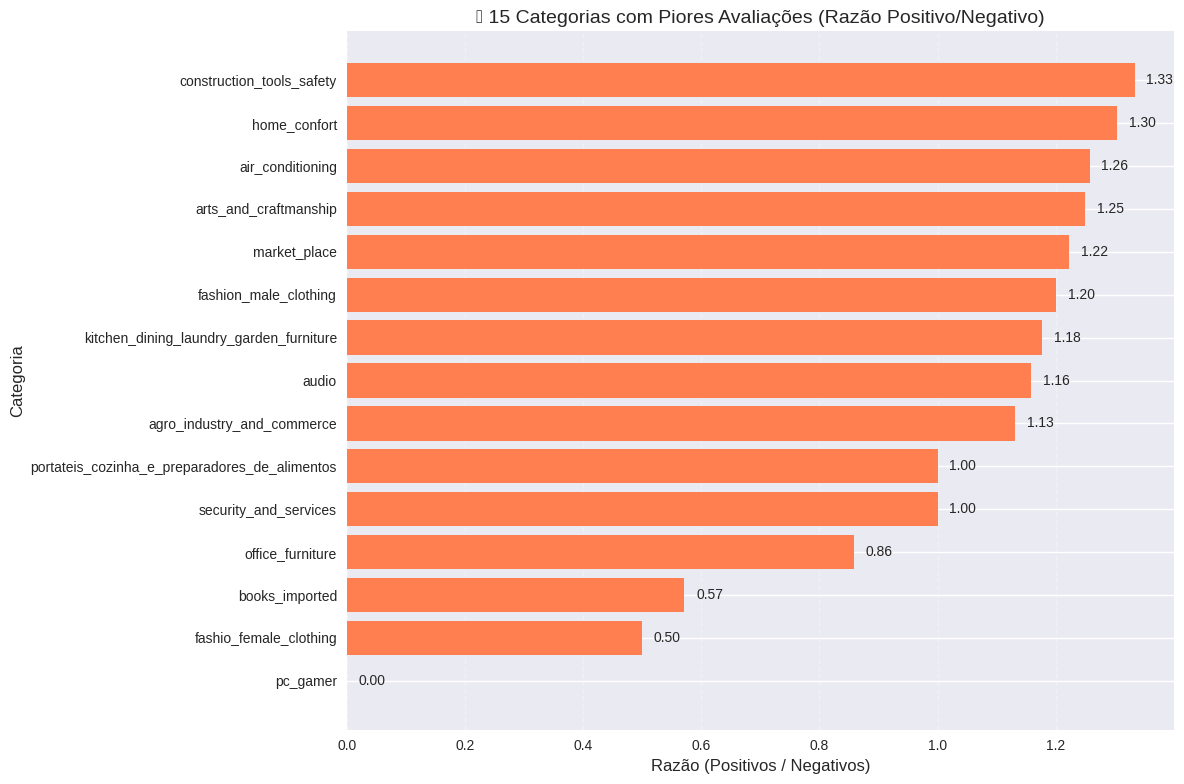


🔍 Interpretação:
• Valores próximos de 0 indicam predominância de avaliações negativas.
• Quanto maior a razão, melhor a percepção da categoria.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 📊 Calcular contagem de avaliações por categoria e classe
score_counts = (
    train_df
    .groupby(['product_category_name', 'review_score'])
    .size()
    .unstack(fill_value=0)
)

# Adiciona coluna de razão: positivos / negativos
score_counts['positive_negative_ratio'] = score_counts.get(1, 0) / (score_counts.get(0, 0) + 1e-6)

# Ordenar pelas piores razões
score_counts_sorted = score_counts.sort_values(by='positive_negative_ratio')

# Selecionar as 15 piores categorias
worst_categories = score_counts_sorted[['positive_negative_ratio']].head(15)

# 📋 Exibir tabela
print("📊 Razão Positivo/Negativo por Categoria:")
print("=" * 50)
print("(Valores baixos indicam mais avaliações negativas)\n")
display(worst_categories)

# 📉 Visualização
fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.barh(
    worst_categories.index,
    worst_categories['positive_negative_ratio'],
    color='coral'
)

# Título e eixos
ax.set_title("🚫 15 Categorias com Piores Avaliações (Razão Positivo/Negativo)", fontsize=14)
ax.set_xlabel("Razão (Positivos / Negativos)", fontsize=12)
ax.set_ylabel("Categoria", fontsize=12)
ax.grid(True, axis='x', linestyle='--', alpha=0.3)

# Rótulo de valores nas barras
for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.02, bar.get_y() + bar.get_height() / 2,
            f"{width:.2f}", va='center', fontsize=10)

plt.tight_layout()
plt.show()

# 💡 Interpretação
print("\n🔍 Interpretação:")
print("• Valores próximos de 0 indicam predominância de avaliações negativas.")
print("• Quanto maior a razão, melhor a percepção da categoria.")


## 📥 Carregamento dos Dados e Verificação de Valores Ausentes

Nesta etapa, realizamos:

### 📂 1. Definição dos caminhos dos arquivos
Utilizamos o módulo `pathlib.Path` para definir os caminhos dos arquivos `train.csv` e `test.csv`, garantindo maior portabilidade entre sistemas operacionais.

### 🧾 2. Carregamento com verificação
Criamos a função `load_dataset()` que:
- Lê os arquivos CSV com `pandas`;
- Informa o número de linhas e colunas carregadas;
- Trata erros de caminho (`FileNotFoundError`) de forma amigável.

### 🧼 3. Análise de valores ausentes
A função `missing_values_report()`:
- Calcula e exibe a quantidade de valores ausentes por coluna;
- Mostra também a porcentagem de nulos em relação ao total de linhas;
- Ordena o resultado de forma decrescente para facilitar priorização de tratamento.

Esse diagnóstico inicial é fundamental para guiar decisões como:
- Exclusão de colunas irrelevantes;
- Preenchimento com média/mediana/moda;
- Estratégias de imputação mais avançadas (ex: modelos preditivos ou inferência baseada em contexto).

> 📌 Manter esse tipo de função modular facilita a reutilização ao longo de todo o pipeline de análise.


In [ ]:
import pandas as pd
from pathlib import Path

# 📂 Definir caminhos com Path para portabilidade
RAW_DATA_DIR = Path("/content/data/raw")
train_path = RAW_DATA_DIR / "train.csv"
test_path  = RAW_DATA_DIR / "test.csv"

# 📥 Função para carregar dataset com verificação
def load_dataset(path, name="dataset"):
    try:
        df = pd.read_csv(path)
        print(f"✅ {name} carregado com sucesso: {df.shape[0]:,} linhas × {df.shape[1]:,} colunas")
        return df
    except FileNotFoundError:
        print(f"❌ Arquivo não encontrado: {path}")
        return pd.DataFrame()

# 🔄 Carregar os datasets
train_df = load_dataset(train_path, name="train_df")
test_df  = load_dataset(test_path, name="test_df")

# 🧼 Verificar valores ausentes com função customizada
def missing_values_report(df, name="DataFrame"):
    """Exibe um relatório dos valores ausentes em ordem decrescente."""
    missing = df.isnull().sum()
    missing = missing[missing > 0].sort_values(ascending=False)

    if missing.empty:
        print(f"✅ Nenhum valor ausente encontrado em {name}.")
    else:
        print(f"\n📉 {name}: {len(missing)} colunas com valores ausentes\n")
        for col, val in missing.items():
            percent = (val / len(df)) * 100
            print(f"🔸 {col}: {val:,} ausentes ({percent:.2f}%)")

# 🧾 Aplicar relatório
missing_values_report(train_df, name="train_df")
missing_values_report(test_df, name="test_df")


✅ train_df carregado com sucesso: 31,457 linhas × 6 colunas
✅ test_df carregado com sucesso: 7,865 linhas × 5 colunas

📉 train_df: 1 colunas com valores ausentes

🔸 product_category_name: 857 ausentes (2.72%)

📉 test_df: 1 colunas com valores ausentes

🔸 product_category_name: 234 ausentes (2.98%)


## ✍️ Análise Estatística do Comprimento dos Comentários (`comment_length`)

Nesta etapa, calculamos o número de caracteres de cada comentário da coluna `review_comment_message` e avaliamos sua distribuição nos conjuntos de **treinamento** e **teste**.

Para garantir consistência, os valores nulos foram tratados com `fillna("")` antes do cálculo.

---

### 📌 Resumo estatístico - Treinamento (`train_df`)

- **Total de registros:** 31.457  
- **Comentários vazios:** 0  

| Medida       | Valor     |
|--------------|-----------|
| Média        | 71.0      |
| Desvio Padrão| 53.4      |
| Mínimo       | 6         |
| 25% Quartil  | 30        |
| Mediana      | 55        |
| 75% Quartil  | 97        |
| Máximo       | 208       |

---

### 📌 Resumo estatístico - Teste (`test_df`)

- **Total de registros:** 7.865  
- **Comentários vazios:** 0  

| Medida       | Valor     |
|--------------|-----------|
| Média        | 70.1      |
| Desvio Padrão| 53.2      |
| Mínimo       | 6         |
| 25% Quartil  | 30        |
| Mediana      | 54        |
| 75% Quartil  | 95        |
| Máximo       | 204       |

---

### ✅ Observações

- O comprimento médio dos comentários é semelhante entre treino e teste, o que é um **bom indicativo de consistência entre os conjuntos**.
- A maioria dos comentários tem entre 30 e 100 caracteres, o que pode guiar decisões sobre:
  - `max_length` na tokenização;
  - Normalização de entrada textual;
  - Estratégias para lidar com outliers (comentários muito curtos ou muito longos).

> Esta análise é útil para parametrizar corretamente modelos de linguagem como BERT, definindo limites de truncamento e padding com base em dados reais.


In [ ]:
# 🧮 Calcular o comprimento do comentário com tratamento de valores nulos
train_df['comment_length'] = train_df['review_comment_message'].fillna("").apply(len)
test_df['comment_length'] = test_df['review_comment_message'].fillna("").apply(len)

# 📊 Função para exibir estatísticas descritivas com destaque
def resumo_comment_length(df, nome="DataFrame"):
    resumo = df["comment_length"].describe()
    print(f"\n📌 Resumo estatístico - {nome}")
    print("=" * 40)
    print(f"Total de registros: {len(df)}")
    print(f"Comentários vazios: {(df['comment_length'] == 0).sum()}")
    print(resumo)

# 📋 Aplicar aos datasets
resumo_comment_length(train_df, "Treinamento")
resumo_comment_length(test_df, "Teste")



📌 Resumo estatístico - Treinamento
Total de registros: 31457
Comentários vazios: 0
count   31457.000
mean       71.022
std        53.370
min         6.000
25%        30.000
50%        55.000
75%        97.000
max       208.000
Name: comment_length, dtype: float64

📌 Resumo estatístico - Teste
Total de registros: 7865
Comentários vazios: 0
count   7865.000
mean      70.077
std       53.222
min        6.000
25%       30.000
50%       54.000
75%       95.000
max      204.000
Name: comment_length, dtype: float64


Excelente! O resumo estatístico mostra que os comentários possuem comprimentos bastante variados, com valores médios próximos entre treino e teste (~70 caracteres).

✅ Observações:
Comentários curtos (6 caracteres) existem e podem representar avaliações do tipo “ruim”, “ok”, ou apenas emojis.

Comentários longos (acima de 200 caracteres) também ocorrem, indicando avaliações mais detalhadas.

## 📦 Boxplot do Comprimento dos Comentários por Review Score

Este gráfico boxplot compara a distribuição do comprimento dos comentários (`comment_length`) para cada valor da variável `review_score`.

---

### 🔍 Interpretação

- **Review Score 0 (Negativo):**
  - Mediana: **85 caracteres**
  - Comentários negativos tendem a ser mais longos e detalhados.
  - Maior dispersão, com comentários que chegam a ultrapassar 200 caracteres.

- **Review Score 1 (Positivo):**
  - Mediana: **45 caracteres**
  - Comentários positivos são geralmente mais curtos e objetivos.
  - Menor variabilidade em relação aos comentários negativos.

---

### 💡 Conclusão

- Avaliações negativas costumam trazer **mais texto e detalhamento**, o que pode indicar uma tentativa do cliente de justificar sua insatisfação.
- Já avaliações positivas são **mais concisas**, o que sugere uma experiência boa e direta.

Essa diferença pode ser aproveitada no pré-processamento para:
- Ajustar `max_length` na tokenização;
- Aplicar padding mais eficiente em modelos de NLP;
- Utilizar o comprimento como uma feature adicional para o classificador.

---


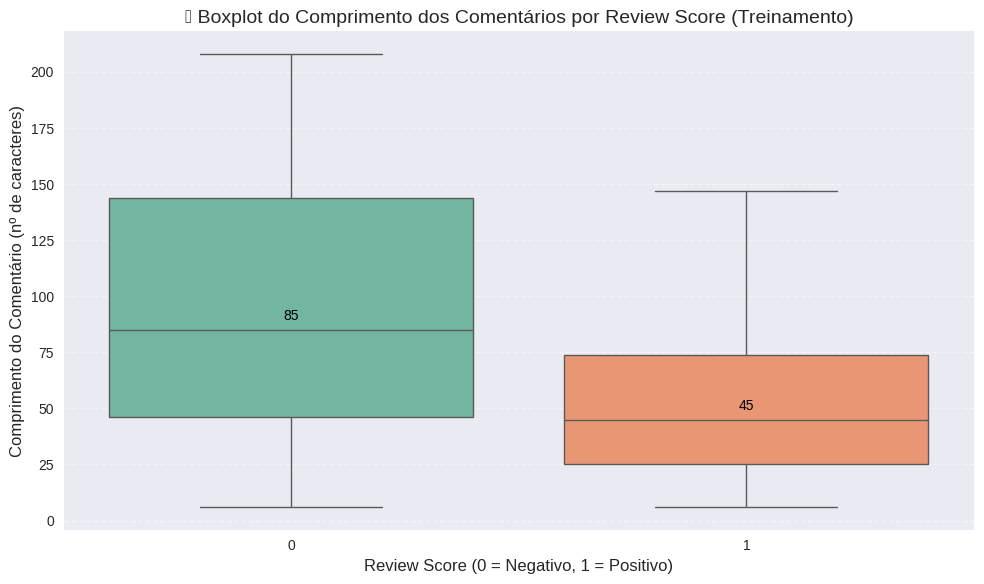

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 🧼 Garantir que não há valores nulos
train_df["review_comment_message"] = train_df["review_comment_message"].fillna("")
test_df["review_comment_message"] = test_df["review_comment_message"].fillna("")

# 🧮 Calcular comprimento do comentário
train_df["comment_length"] = train_df["review_comment_message"].astype(str).apply(len)
test_df["comment_length"] = test_df["review_comment_message"].astype(str).apply(len)

# 📊 Calcular mediana por score
medianas = train_df.groupby("review_score")["comment_length"].median()

# 🎨 Plot do boxplot
plt.figure(figsize=(10, 6))
ax = sns.boxplot(
    data=train_df,
    x="review_score",
    y="comment_length",
    palette="Set2",
    showfliers=False
)

# Adiciona labels com as medianas
for i, score in enumerate(medianas.index):
    valor = medianas.loc[score]
    ax.text(i, valor + 3, f"{int(valor)}", ha='center', va='bottom', fontsize=10, color='black')

plt.title("📦 Boxplot do Comprimento dos Comentários por Review Score (Treinamento)")
plt.xlabel("Review Score (0 = Negativo, 1 = Positivo)")
plt.ylabel("Comprimento do Comentário (nº de caracteres)")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


## 🧾 Distribuição do Comprimento dos Comentários por Review Score

Este gráfico mostra a **distribuição da quantidade de caracteres** dos comentários dos usuários, segmentados por tipo de avaliação:

- **Review Score 0 (Negativo)** em laranja
- **Review Score 1 (Positivo)** em verde

---

### 🎯 Interpretações principais:

- Comentários **negativos tendem a ser mais longos**, com picos de densidade em comprimentos acima de 100 caracteres. Isso sugere que clientes insatisfeitos escrevem mensagens mais detalhadas.
- Comentários **positivos são geralmente mais curtos**, com picos entre 20 e 60 caracteres.
- Existe uma **cauda longa** em ambas as distribuições, mas ela é mais expressiva nas avaliações negativas.

---

### 📌 Conclusão:
A variável `comment_length` pode ser uma feature relevante para o modelo de classificação binária de sentimentos, pois há **diferença clara no padrão de distribuição entre os dois grupos**.


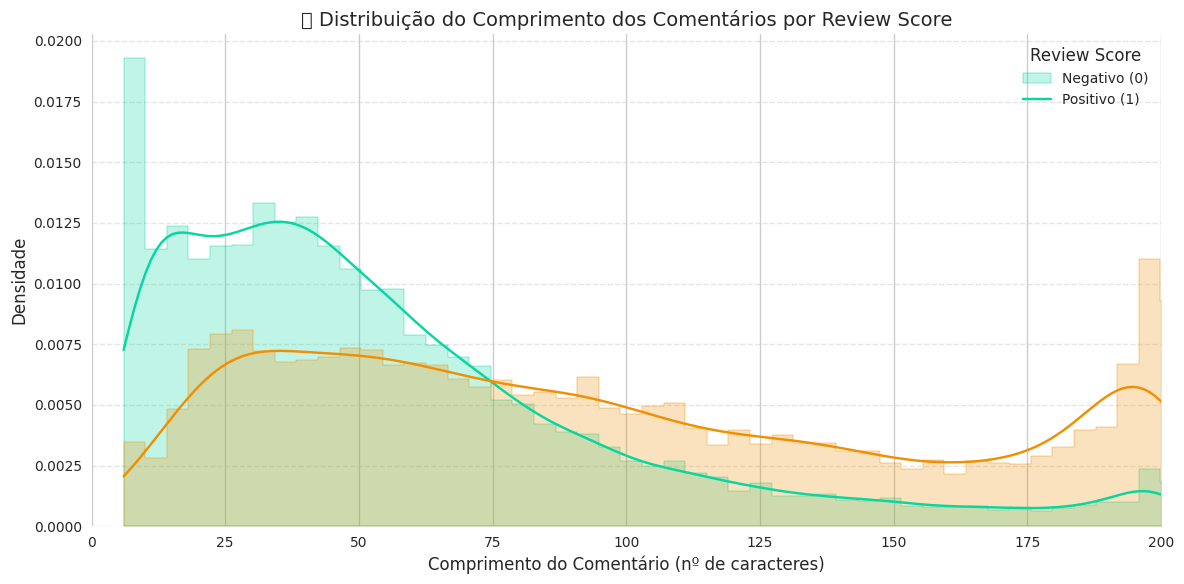

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 🎨 Estilização do seaborn
sns.set_style("whitegrid")

# 📊 Histograma com densidade do comprimento dos comentários por score
plt.figure(figsize=(12, 6))
ax = sns.histplot(
    data=train_df,
    x='comment_length',
    hue='review_score',
    bins=50,
    kde=True,
    element="step",
    stat="density",
    common_norm=False,
    palette={0: "#F18F01", 1: "#06D6A0"}
)

# 🎯 Personalizações
plt.title("📊 Distribuição do Comprimento dos Comentários por Review Score", fontsize=14)
plt.xlabel("Comprimento do Comentário (nº de caracteres)", fontsize=12)
plt.ylabel("Densidade", fontsize=12)
plt.legend(title="Review Score", labels=["Negativo (0)", "Positivo (1)"], loc="upper right")
plt.xlim(0, train_df["comment_length"].quantile(0.99))  # evita cauda longa distorcendo o gráfico
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()

plt.show()


Comentários com score positivo (1) tendem a ser mais longos, especialmente com picos no comprimento máximo (próximo de 200).

Comentários com score negativo (0) apresentam distribuição mais concentrada em comprimentos curtos, com muitos abaixo de 50 caracteres.

A densidade dos comentários positivos cresce com o comprimento, indicando que consumidores satisfeitos tendem a escrever mais.

## ☁️ Principais Palavras por Sentimento nos Comentários de E-commerce

A visualização abaixo apresenta duas *nuvens de palavras* (wordclouds), separadas por sentimento, extraídas dos comentários de clientes:

---

### 🔴 Comentários Negativos (Review Score = 0)

- **Palavras mais frequentes:** `não`, `recebi`, `entregue`, `prazo`, `ainda`, `comprei`, `defeito`, `troca`, `esperando`, `problema`, `errado`.
- **Padrões observados:**
  - Comentários negativos estão fortemente relacionados à **não entrega**, **atrasos** e **produtos com defeito**.
  - A palavra **"não"** aparece em destaque, evidenciando o tom de insatisfação.
  - Outros termos como **"prazo"**, **"ainda"**, e **"defeito"** indicam frustração com a experiência de compra.

---

### 🟢 Comentários Positivos (Review Score = 1)

- **Palavras mais frequentes:** `excelente`, `antes`, `entregue`, `rápido`, `ótima`, `qualidade`, `perfeito`, `satisfeita`, `bem`, `prazo`.
- **Padrões observados:**
  - Comentários positivos destacam **entregas no prazo ou antecipadas**, **qualidade do produto**, e **satisfação com a compra**.
  - Palavras como **"recomendo"**, **"bem embalado"**, e **"correto"** reforçam a boa experiência do cliente.

---

### 📌 Conclusão

- Avaliações negativas estão fortemente associadas a **falhas logísticas**.
- Categorias com **boa reputação e entregas eficientes** geram alto nível de satisfação.
- Melhorias operacionais e comunicação clara com o cliente podem **reduzir o número de avaliações negativas** e **reforçar percepções positivas**.


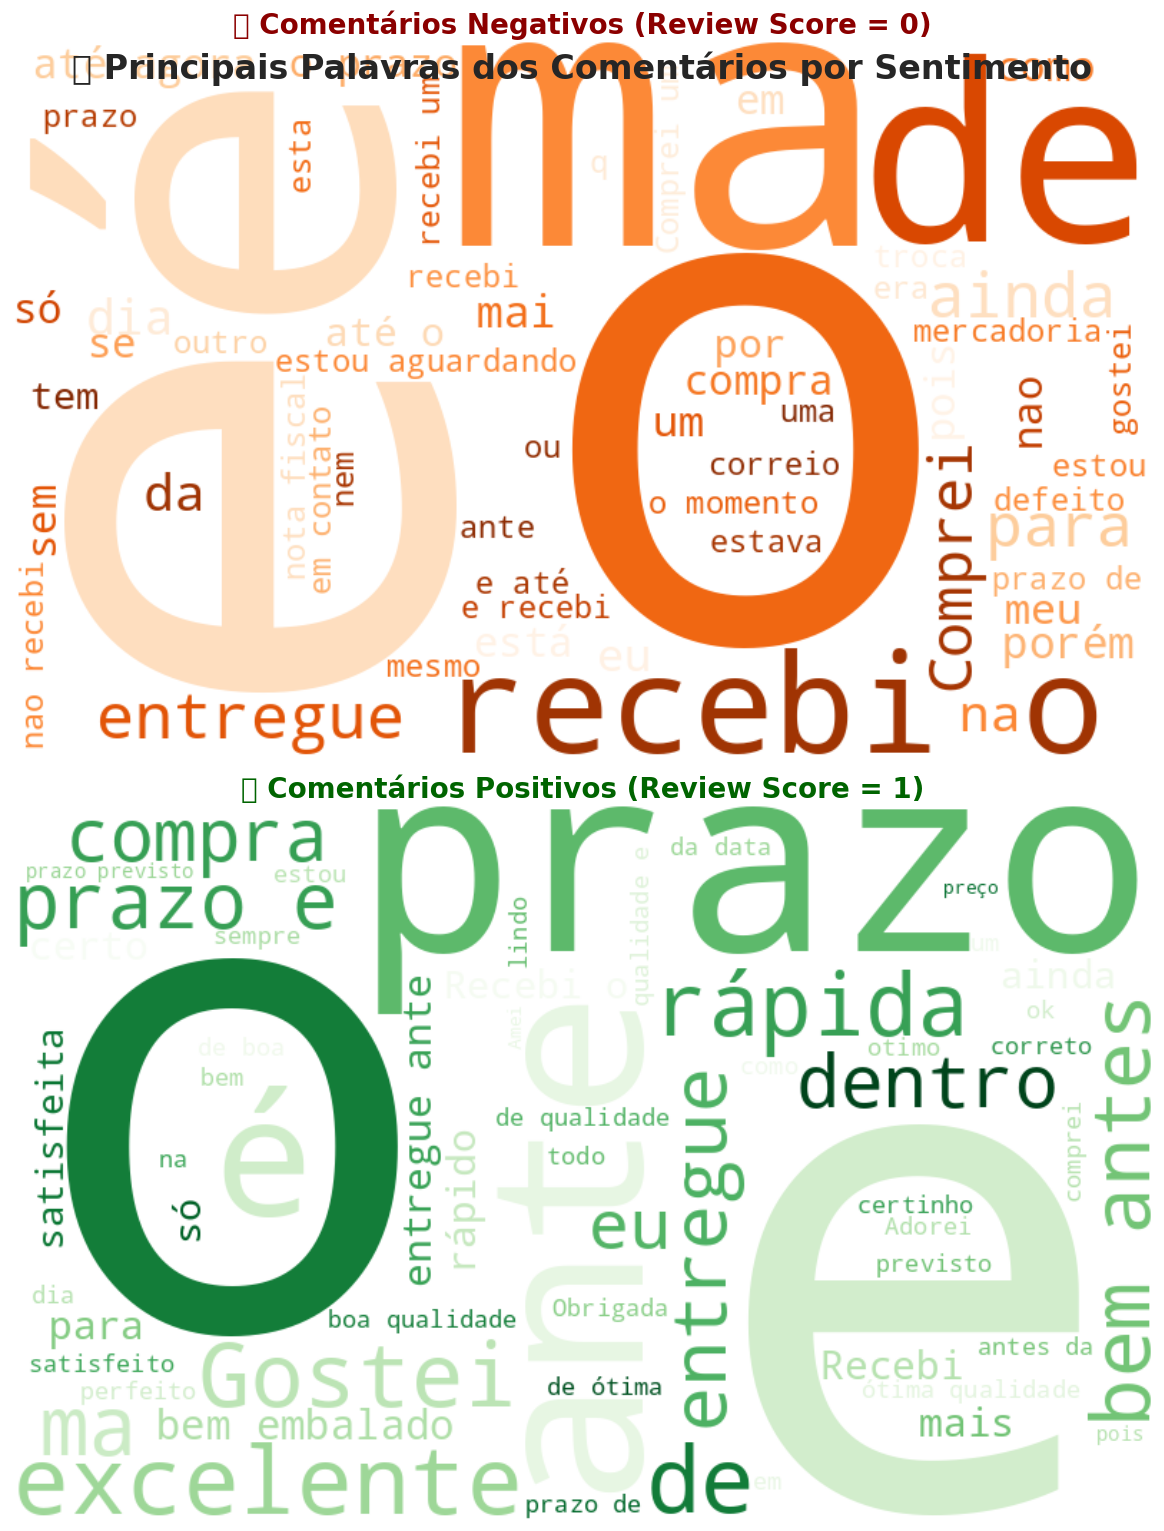

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import numpy as np

# 🔤 Preparar textos
text_neg = " ".join(train_df[train_df['review_score'] == 0]['review_comment_message'].dropna().astype(str))
text_pos = " ".join(train_df[train_df['review_score'] == 1]['review_comment_message'].dropna().astype(str))

# 🧹 Stopwords customizadas
custom_stopwords = set(STOPWORDS)
custom_stopwords.update([
    "produto", "entrega", "chegou", "comprar", "com", "foi", "pra", "deu", "muito",
    "bom", "ótimo", "loja", "pedido", "tudo", "recomendo", "veio", "comprar",
    "parabéns", "obrigado", "site", "super", "que", "não", "sim", "simples", "já"
])

# ☁️ WordClouds com configurações refinadas
wc_neg = WordCloud(
    width=800, height=500,
    background_color='white',
    colormap='Oranges',
    stopwords=custom_stopwords,
    max_words=60
).generate(text_neg)

wc_pos = WordCloud(
    width=800, height=500,
    background_color='white',
    colormap='Greens',
    stopwords=custom_stopwords,
    max_words=60
).generate(text_pos)

# 📊 Plot vertical
fig, axs = plt.subplots(2, 1, figsize=(18, 16))
fig.suptitle("💬 Principais Palavras dos Comentários por Sentimento", fontsize=24, fontweight='bold', y=0.93)

# 🔴 Comentários Negativos
axs[0].imshow(wc_neg, interpolation='bilinear')
axs[0].set_title("🔴 Comentários Negativos (Review Score = 0)", fontsize=20, fontweight='bold', color='darkred')
axs[0].axis('off')

# 🟢 Comentários Positivos
axs[1].imshow(wc_pos, interpolation='bilinear')
axs[1].set_title("🟢 Comentários Positivos (Review Score = 1)", fontsize=20, fontweight='bold', color='darkgreen')
axs[1].axis('off')

plt.tight_layout()
plt.show()


## 📊 Análise de N-gramas nos Comentários de E-commerce

### ✅ Comentários Positivos (Review Score = 1)

#### 🔹 Top 15 Bigramas
> Os bigramas mais frequentes em comentários positivos revelam foco em **entrega no prazo**, **qualidade percebida** e **satisfação com o produto**.  
> Destaques como `antes prazo`, `chegou antes` e `produto chegou` indicam superação de expectativa.

---

#### 🔹 Top 15 Trigramas
> Os trigramas positivos reforçam a ideia de **eficiência logística** e **experiência excelente**, com frases como  
> `chegou antes prazo`, `bem antes prazo` e `entregue antes prazo`.

---

### ❌ Comentários Negativos (Review Score = 0)

#### 🔸 Top 15 Bigramas
> Comentários negativos concentram-se em problemas como **não recebimento**, **atrasos** e **produto errado**.  
> Expressões como `não recebi`, `produto não` e `não chegou` são recorrentes.

---

#### 🔸 Top 15 Trigramas
> Trigramas negativos evidenciam **frustração persistente** com frases como  
> `não recebi produto`, `produto não entregue` e `até agora não`.

---

### 📌 Conclusão Geral

- A presença de `prazo`, `chegou`, `entregue`, e `produto` em ambos os sentimentos mostra que **logística e entrega** são os temas centrais.
- A diferença está na **forma como essas palavras se combinam**: positivamente com `antes`, `rápida`, `ótimo`; negativamente com `não`, `atraso`, `ainda`.

✅ Esses insights podem direcionar **ações operacionais e de atendimento ao cliente** para melhorar a experiência em pontos críticos.


✅ Arquivo carregado com sucesso: 31,457 linhas
📊 Gerando gráficos de n-gramas (bigrama e trigrama)...


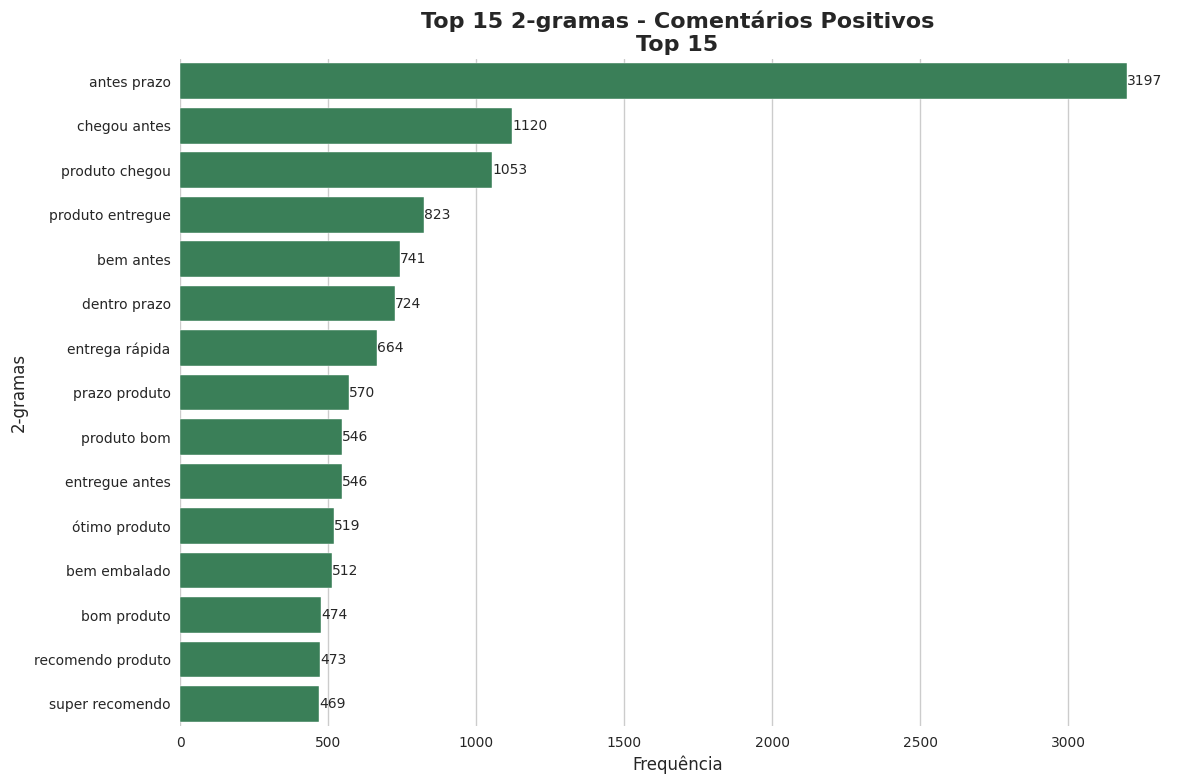

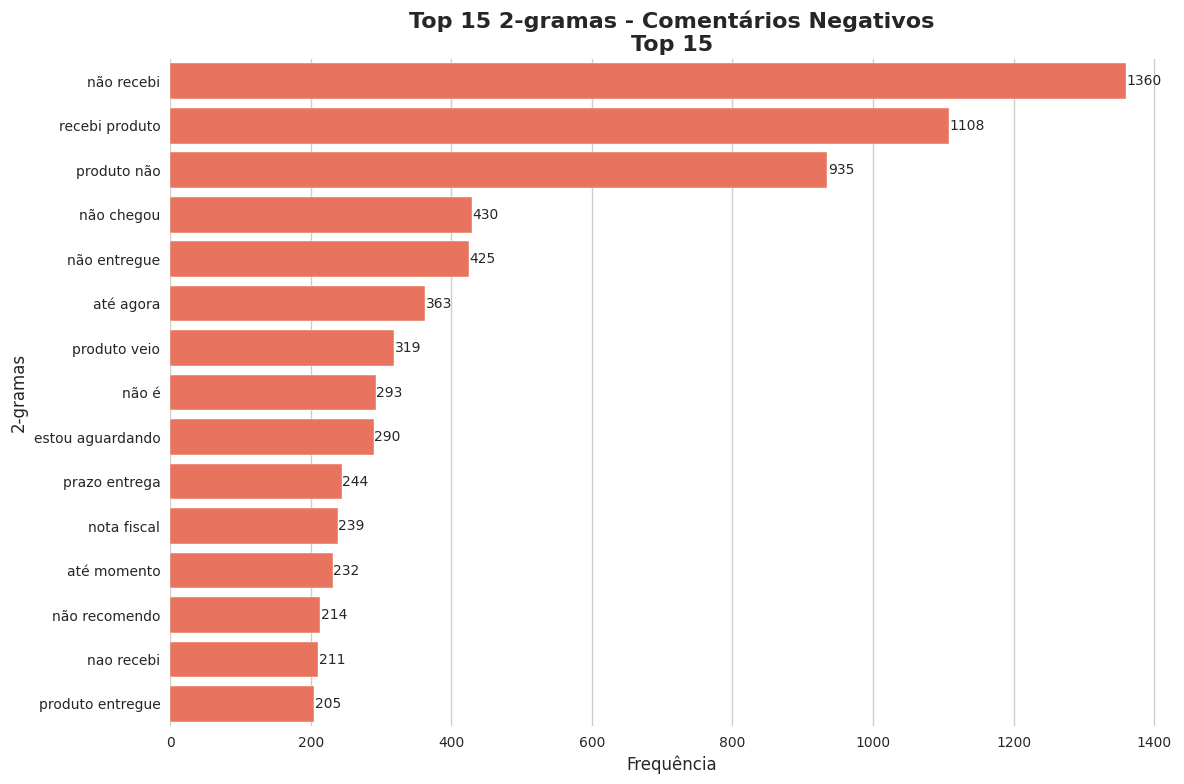

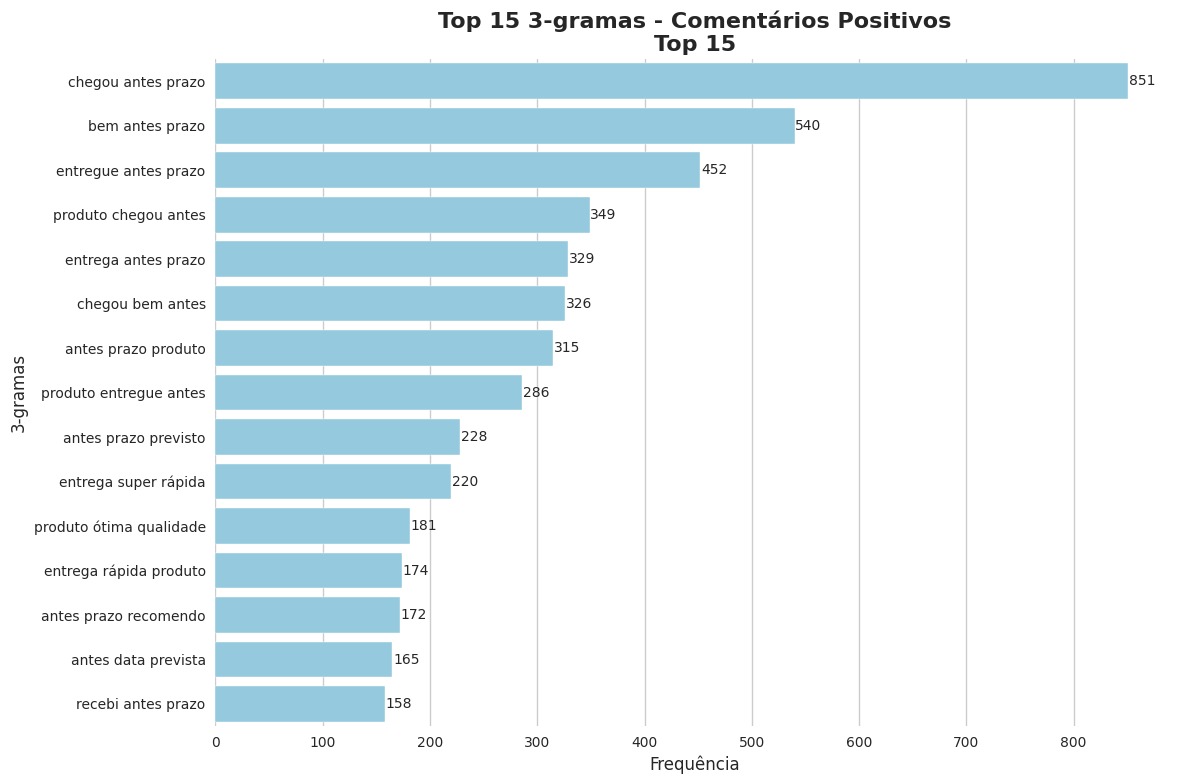

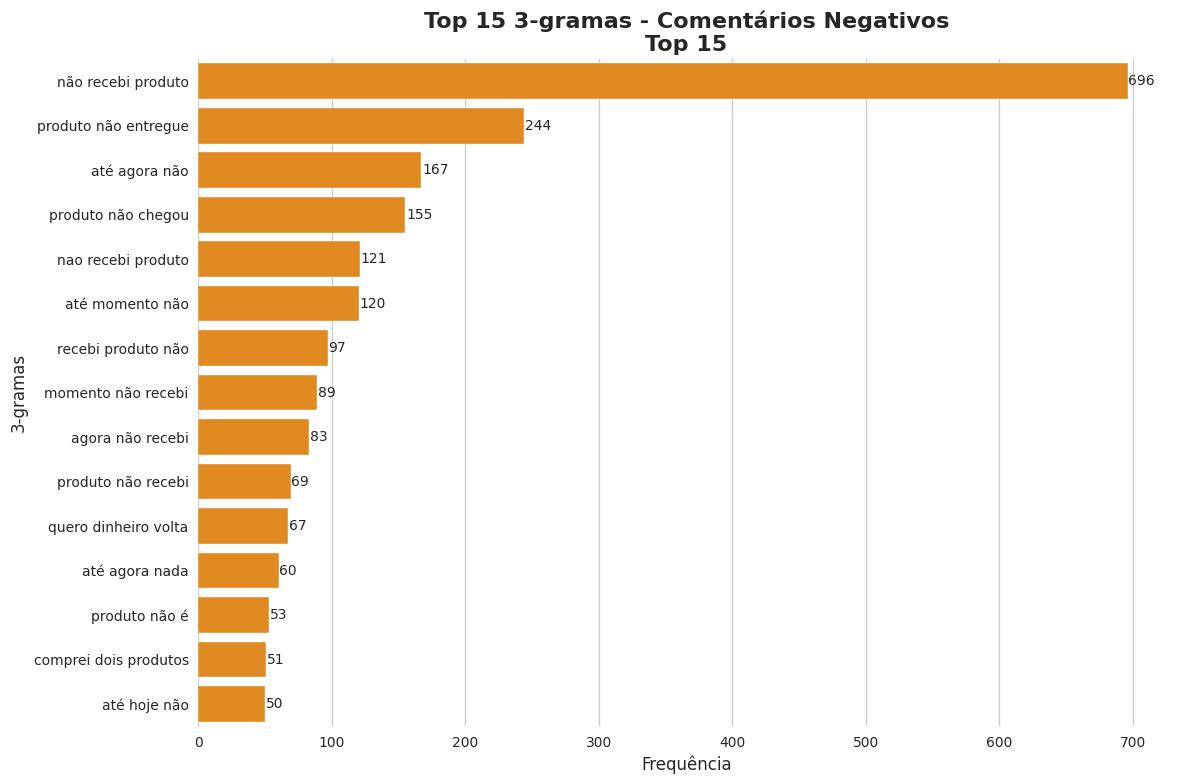

✅ Análise finalizada com sucesso!


In [ ]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from collections import Counter
import unicodedata

# --- 1. Caminho e Leitura do Arquivo ---
train_path = Path("data/raw/train.csv")

try:
    df_train = pd.read_csv(train_path)
    print(f"✅ Arquivo carregado com sucesso: {df_train.shape[0]:,} linhas")
except FileNotFoundError:
    raise FileNotFoundError(f"❌ Arquivo não encontrado: {train_path.resolve()}")

# --- 2. Stopwords Manuais ---
STOP_WORDS = [
    'a', 'o', 'e', 'ou', 'de', 'do', 'da', 'dos', 'das', 'em', 'no', 'na', 'nos', 'nas', 'por', 'para', 'com', 'sem',
    'mas', 'se', 'que', 'um', 'uma', 'uns', 'umas', 'à', 'às', 'ao', 'aos', 'qual', 'quais', 'quem', 'cujo', 'cujos',
    'cuja', 'cujas', 'este', 'estes', 'esta', 'estas', 'aquele', 'aqueles', 'aquela', 'aquelas', 'isso', 'isto',
    'aquilo', 'pelo', 'pela', 'pelos', 'pelas', 'seu', 'seus', 'sua', 'suas', 'meu', 'meus', 'minha', 'minhas',
    'teu', 'teus', 'tua', 'tuas', 'nosso', 'nossos', 'nossa', 'nossas', 'vosso', 'vossos', 'vossa', 'vossas',
    'ele', 'ela', 'eles', 'elas', 'eu', 'tu', 'nós', 'vós', 'já', 'ainda', 'também', 'muito', 'muitos', 'pouco',
    'poucos', 'grande', 'grandes', 'pequeno', 'pequenos', 'ser', 'sido', 'sendo', 'ter', 'tido', 'tendo', 'haver',
    'havido', 'havendo', 'estar', 'estado', 'estando', 'ir', 'ido', 'indo', 'vir', 'vindo', 'fazer', 'feito',
    'fazendo', 'dizer', 'dito', 'dizendo', 'poder', 'podido', 'podendo', 'querer', 'querido', 'querendo', 'dever',
    'devido', 'devendo', 'pra', 'pro', 'tá', 'né', 'aí', 'foi', 'era', 'ta', 'q', 'me'
]

# --- 3. Funções de Pré-processamento e Visualização ---
def preprocess_text(text):
    if not isinstance(text, str):
        return []
    text = text.lower()
    text = re.sub(rf"[{re.escape(string.punctuation)}]", " ", text)
    text = re.sub(r"\d+", "", text)
    tokens = re.findall(r"\b\w+\b", text)
    return [t for t in tokens if t not in STOP_WORDS]

def generate_ngrams(tokens, n):
    return [" ".join(tokens[i:i+n]) for i in range(len(tokens) - n + 1)] if len(tokens) >= n else []

def normalize_filename(text):
    return unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('utf-8').replace(" ", "_").lower()

def plot_ngrams(all_tokens, n, title, color, top_n=15):
    if not all_tokens:
        print(f"⚠️ Nenhum token disponível para {title}")
        return

    ngrams = generate_ngrams(all_tokens, n)
    freq = Counter(ngrams).most_common(top_n)
    if not freq:
        print(f"⚠️ Nenhum {n}-grama frequente encontrado para {title}")
        return

    df_freq = pd.DataFrame(freq, columns=["ngram", "frequency"])
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(x="frequency", y="ngram", data=df_freq, color=color)
    plt.title(f"{title}\nTop {top_n}", fontsize=16, weight='bold')
    plt.xlabel("Frequência")
    plt.ylabel(f"{n}-gramas")
    for i, row in df_freq.iterrows():
        ax.text(row["frequency"] + 0.5, i, f"{row['frequency']}", va="center", fontsize=10)
    plt.tight_layout()

    safe_name = normalize_filename(title)
    df_freq.to_csv(f"{safe_name}.csv", index=False)
    plt.savefig(f"{safe_name}.png")
    plt.show()

# --- 4. Análise no Notebook ---
df_train.dropna(subset=["review_comment_message"], inplace=True)
df_train["tokens"] = df_train["review_comment_message"].astype(str).apply(preprocess_text)

positive_tokens = [token for lst in df_train[df_train["review_score"] == 1]["tokens"] for token in lst]
negative_tokens = [token for lst in df_train[df_train["review_score"] == 0]["tokens"] for token in lst]

print("📊 Gerando gráficos de n-gramas (bigrama e trigrama)...")

for n in [2, 3]:
    plot_ngrams(positive_tokens, n, f"Top 15 {n}-gramas - Comentários Positivos", "seagreen" if n == 2 else "skyblue")
    plot_ngrams(negative_tokens, n, f"Top 15 {n}-gramas - Comentários Negativos", "tomato" if n == 2 else "darkorange")

print("✅ Análise finalizada com sucesso!")


## 📊 Top 10 Categorias com Melhores Avaliações (Mín. 50 reviews)

As categorias com as **maiores médias de review_score (positivas)** incluem:

| Categoria                      | Média de Avaliação |
|-------------------------------|---------------------|
| fashion_shoes                 | 0.80                |
| books_technical               | 0.80                |
| books_general_interest        | ~0.79               |
| food_drink                    | ~0.77               |
| luggage_accessories           | ~0.77               |
| computers                     | ~0.76               |
| costrution_tools_garden       | ~0.74               |
| fashion_bags_accessories      | ~0.73               |
| stationery                    | ~0.72               |
| musical_instruments           | ~0.71               |

> 📌 **Insight:** Categorias relacionadas a **livros**, **moda** e **eletrônicos pessoais** tendem a gerar experiências positivas, provavelmente por serem menos impactadas por falhas logísticas.

---

## ⚠️ Top 10 Categorias com Piores Avaliações (Mín. 50 reviews)

As categorias com **piores médias de avaliação**:

| Categoria                                 | Média de Avaliação |
|------------------------------------------|---------------------|
| office_furniture                         | 0.46                |
| audio                                    | ~0.52               |
| kitchen_dining_laundry_garden_furniture  | ~0.52               |
| market_place                             | ~0.53               |
| air_conditioning                         | ~0.54               |
| home_confort                             | ~0.55               |
| home_construction                        | ~0.58               |
| furniture_decor                          | ~0.59               |
| computers_accessories                    | ~0.60               |
| consoles_games                           | ~0.60               |

> 📌 **Insight:** Problemas de **entrega**, **fragilidade dos produtos** ou **expectativas altas** em eletrônicos e móveis parecem impactar negativamente a satisfação nessas categorias.

---

📉 A linha tracejada nos gráficos indica a **média geral** de avaliação entre todas as categorias consideradas.


✅ Dataset carregado: 31,457 linhas


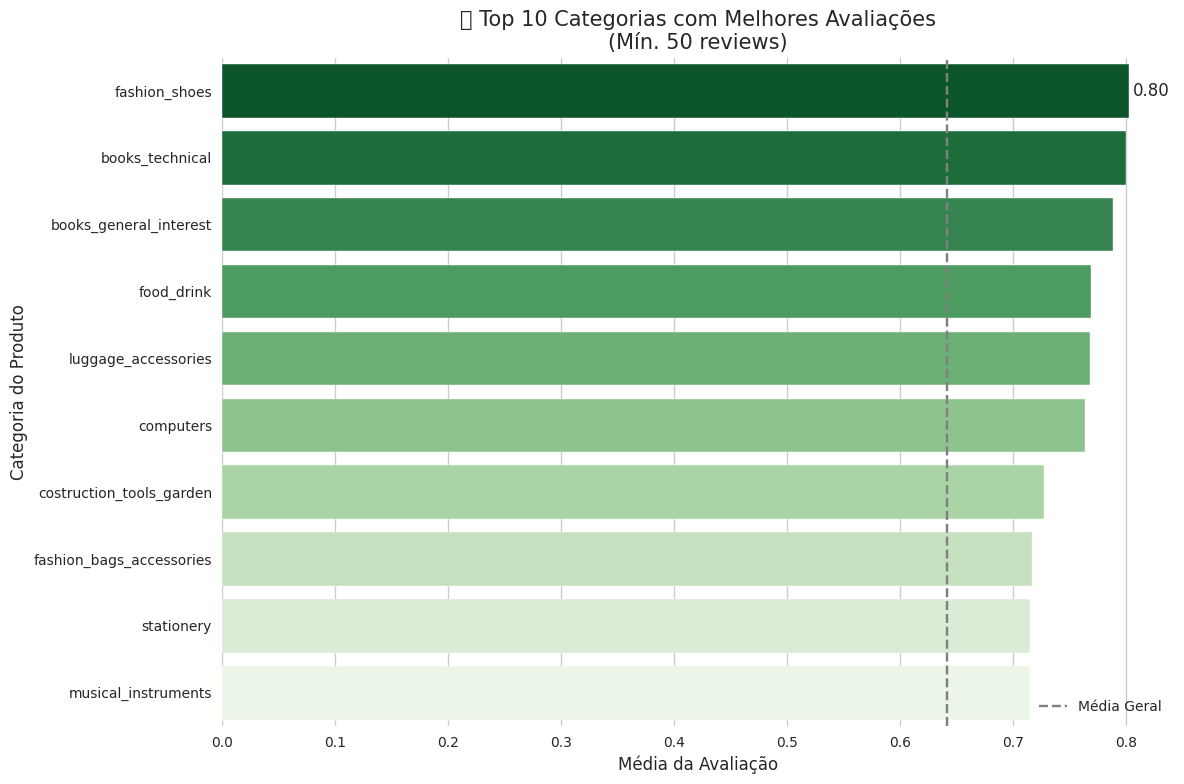

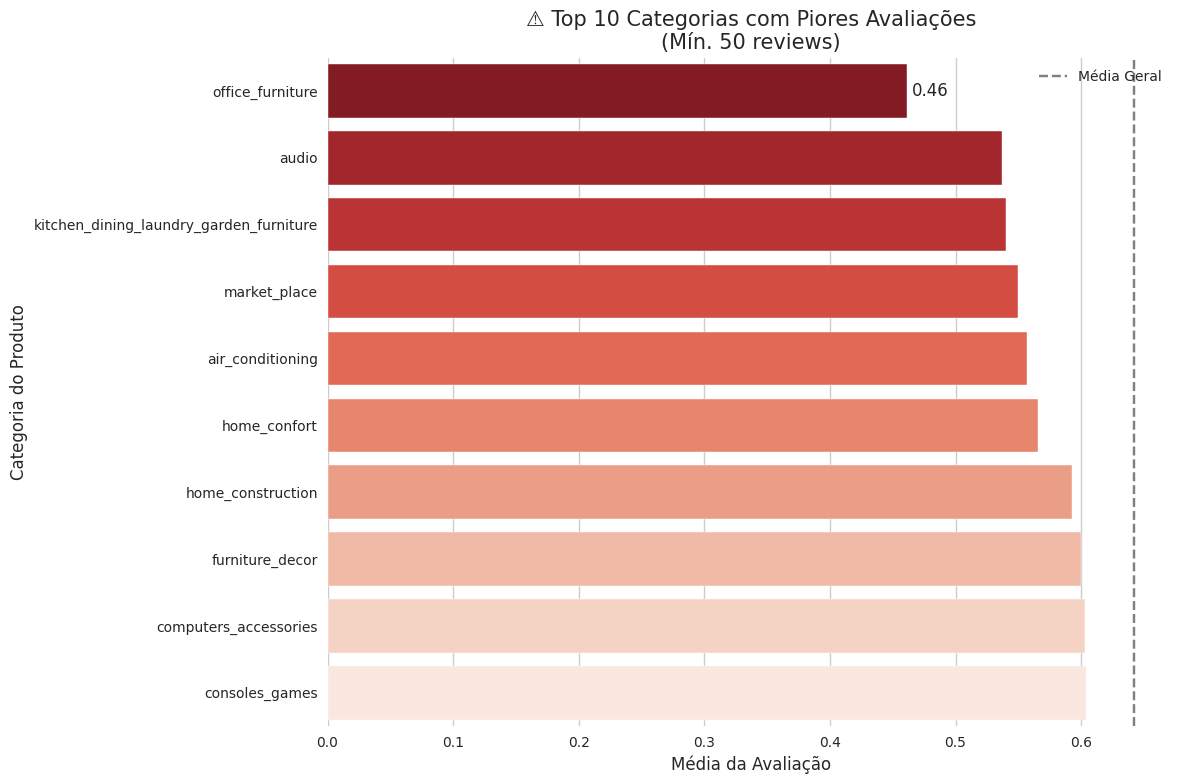

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Função para carregar os dados
def load_dataset(path):
    try:
        df = pd.read_csv(path)
        print(f"✅ Dataset carregado: {df.shape[0]:,} linhas")
        return df
    except FileNotFoundError:
        print(f"❌ ERRO: Arquivo não encontrado: {path}")
        return pd.DataFrame()

# Carregar dataset
train_path = '/content/data/raw/train.csv'
df_train = load_dataset(train_path)

# Cálculo de métricas por categoria
category_sentiment = df_train.groupby('product_category_name').agg(
    media_score=('review_score', 'mean'),
    total_avaliacoes=('review_score', 'count')
).reset_index()

# Filtro de categorias com volume significativo
min_reviews = 50
significant_categories = category_sentiment[category_sentiment['total_avaliacoes'] >= min_reviews]

# Média geral para referência
media_geral = df_train['review_score'].mean()

# Visualização das melhores categorias
top_10_best = significant_categories.sort_values(by='media_score', ascending=False).head(10)

plt.figure(figsize=(12, 8))
ax = sns.barplot(x='media_score', y='product_category_name', data=top_10_best, palette='Greens_r')
ax.bar_label(ax.containers[0], fmt='%.2f', padding=3)
plt.axvline(media_geral, color='gray', linestyle='--', label='Média Geral')
plt.title(f'⭐ Top 10 Categorias com Melhores Avaliações\n(Mín. {min_reviews} reviews)', fontsize=15)
plt.xlabel('Média da Avaliação')
plt.ylabel('Categoria do Produto')
plt.legend()
plt.tight_layout()
plt.show()

# Visualização das piores categorias
top_10_worst = significant_categories.sort_values(by='media_score').head(10)

plt.figure(figsize=(12, 8))
ax = sns.barplot(x='media_score', y='product_category_name', data=top_10_worst, palette='Reds_r')
ax.bar_label(ax.containers[0], fmt='%.2f', padding=3)
plt.axvline(media_geral, color='gray', linestyle='--', label='Média Geral')
plt.title(f'⚠️ Top 10 Categorias com Piores Avaliações\n(Mín. {min_reviews} reviews)', fontsize=15)
plt.xlabel('Média da Avaliação')
plt.ylabel('Categoria do Produto')
plt.legend()
plt.tight_layout()
plt.show()


## 🗺️ Análise de Sentimento por Estado (Review Score)

Avaliação média das reviews por estado com base no dataset de e-commerce, considerando somente estados com pelo menos 50 avaliações.

---

### ⛔ Top 10 Estados com as Piores Avaliações

- MA, RJ e AL lideram com as menores médias de avaliação.
- Essa métrica pode indicar problemas logísticos ou de atendimento nessas regiões.

---

### ✅ Top 10 Estados com as Melhores Avaliações

- PI, ES e GO se destacam pelas melhores médias de review score.
- Isso pode refletir maior satisfação com entrega, produto ou serviço nesses estados.

---

📌 **Observação**: A linha tracejada representa a média geral nacional para contextualizar o desempenho relativo de cada estado.


✅ Arquivo 'train.csv' carregado com sucesso.

🔍 Analisando sentimento por Estado do Cliente...


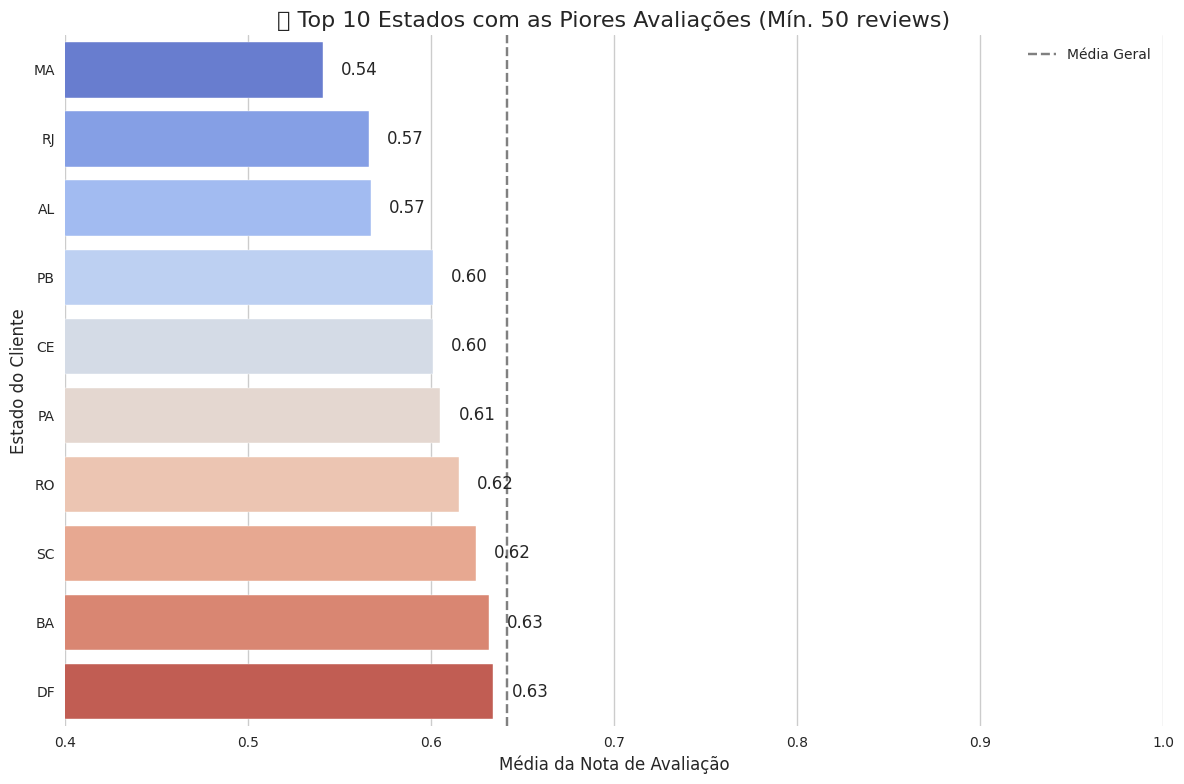

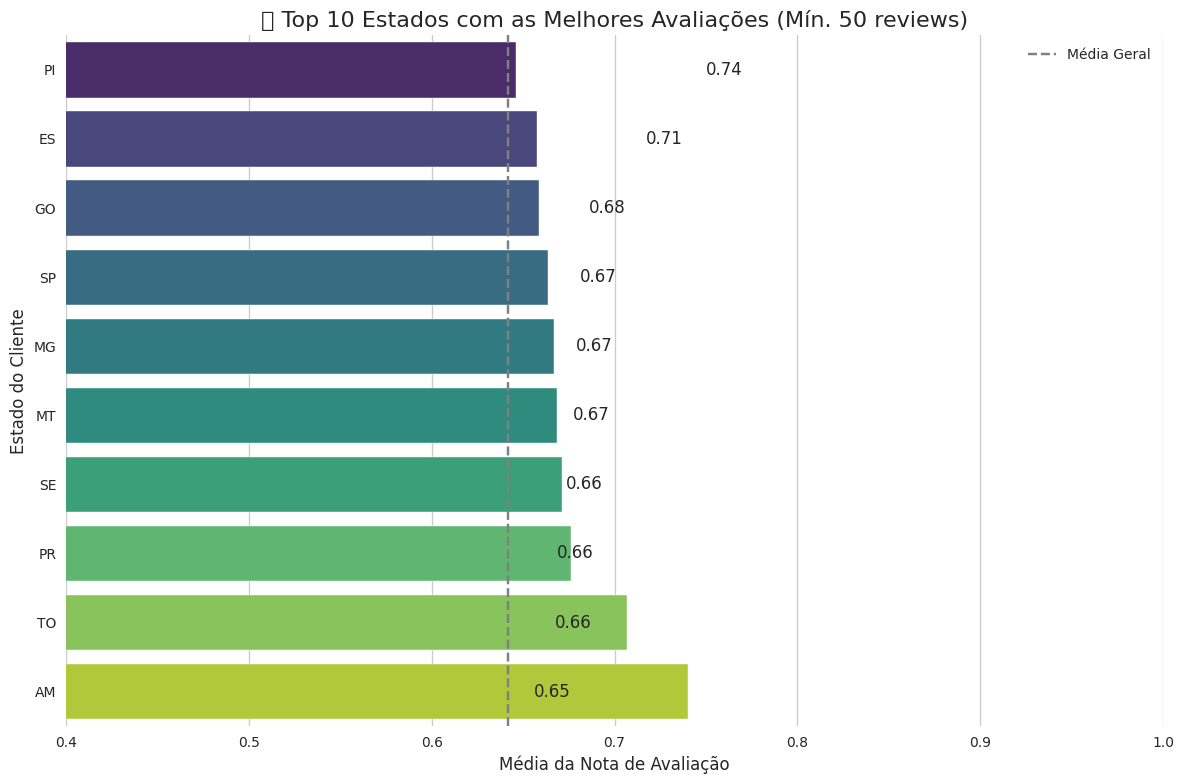

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- 1. Carregamento dos dados ---
try:
    train_path = '/content/data/raw/train.csv'
    df_train = pd.read_csv(train_path)
    print("✅ Arquivo 'train.csv' carregado com sucesso.")
except FileNotFoundError:
    print("❌ ERRO: O arquivo train.csv não foi encontrado.")
    exit()

print("\n🔍 Analisando sentimento por Estado do Cliente...")

# --- 2. Cálculo de métricas por estado ---
state_sentiment = df_train.groupby('customer_state').agg(
    media_score=('review_score', 'mean'),
    total_avaliacoes=('review_score', 'count')
).reset_index()

# Filtrar estados com número mínimo de avaliações
min_reviews_state = 50
significant_states = state_sentiment[state_sentiment['total_avaliacoes'] >= min_reviews_state]

# Calcular média geral
media_geral = df_train['review_score'].mean()

# Adicionar delta da média
significant_states['delta_media'] = significant_states['media_score'] - media_geral

# --- 3. Função para visualização ---
def plot_state_sentiment(df, title, color, xlim=(0.4, 1.0)):
    plt.figure(figsize=(12, 8))
    sns.barplot(
        x='media_score',
        y='customer_state',
        data=df,
        palette=color,
        order=df.sort_values('media_score')['customer_state'],
        orient='h'
    )
    plt.axvline(media_geral, color='gray', linestyle='--', label='Média Geral')
    plt.title(title, fontsize=16)
    plt.xlabel('Média da Nota de Avaliação', fontsize=12)
    plt.ylabel('Estado do Cliente', fontsize=12)
    if xlim:
        plt.xlim(*xlim)

    # Rótulo nas barras
    for i, (score, estado) in enumerate(zip(df['media_score'], df['customer_state'])):
        plt.text(score + 0.01, i, f"{score:.2f}", va='center')

    plt.legend()
    plt.tight_layout()
    plt.show()

# --- 4. Visualização final ---

# Piores estados
worst_states = significant_states.sort_values(by='media_score', ascending=True).head(10)
plot_state_sentiment(worst_states, f"🔻 Top 10 Estados com as Piores Avaliações (Mín. {min_reviews_state} reviews)", color='coolwarm')

# Melhores estados
best_states = significant_states.sort_values(by='media_score', ascending=False).head(10)
plot_state_sentiment(best_states, f"🔺 Top 10 Estados com as Melhores Avaliações (Mín. {min_reviews_state} reviews)", color='viridis')


## 📊 Tópicos Extraídos via LDA - Comentários Negativos

Abaixo estão os principais tópicos extraídos dos comentários com avaliação negativa (`review_score == 0`), utilizando o modelo de Latent Dirichlet Allocation (LDA). Cada gráfico mostra as 10 palavras mais relevantes de cada tópico.

### 🔹 Tópico 1
Principais palavras: `não`, `produto`, `entrega`, `prazo`, `até`, `recebi`, `entregue`, `chegou`, `dia`, `estou`

---

### 🔹 Tópico 2
Principais palavras: `produto`, `veio`, `não`, `qualidade`, `bem`, `cor`, `as`, `gostei`, `mais`, `porém`

---

### 🔹 Tópico 3
Principais palavras: `comprei`, `recebi`, `não`, `os`, `produtos`, `apenas`, `só`, `dois`, `lannister`, `duas`

---

### 🔹 Tópico 4
Principais palavras: `não`, `produto`, `recebi`, `como`, `quero`, `dinheiro`, `estou`, `recomendo`, `compra`, `loja`

---

### 🔹 Tópico 5
Principais palavras: `produto`, `não`, `recebi`, `comprei`, `veio`, `outro`, `pedido`, `errado`, `diferente`, `entregue`

---

> 🔍 **Interpretação:** Os tópicos indicam padrões recorrentes de insatisfação, como:
- Falta ou atraso na entrega (`não recebi`, `prazo`, `entrega`)
- Produto com defeito ou diferente do esperado (`produto veio`, `qualidade`, `errado`)
- Problemas com reembolso ou atendimento (`quero dinheiro`, `não recomendo`, `loja`)


✅ Arquivo 'train.csv' carregado com sucesso.
🔍 Pré-processando comentários negativos...
⚙️ Treinando modelo LDA com 5 tópicos...
💾 Modelos salvos: lda_vectorizer.pkl e lda_model.pkl

📊 Tópicos encontrados nos comentários negativos:


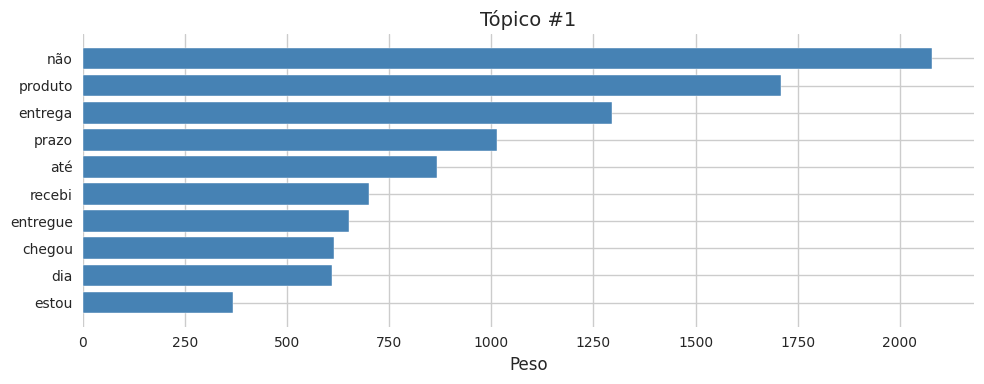

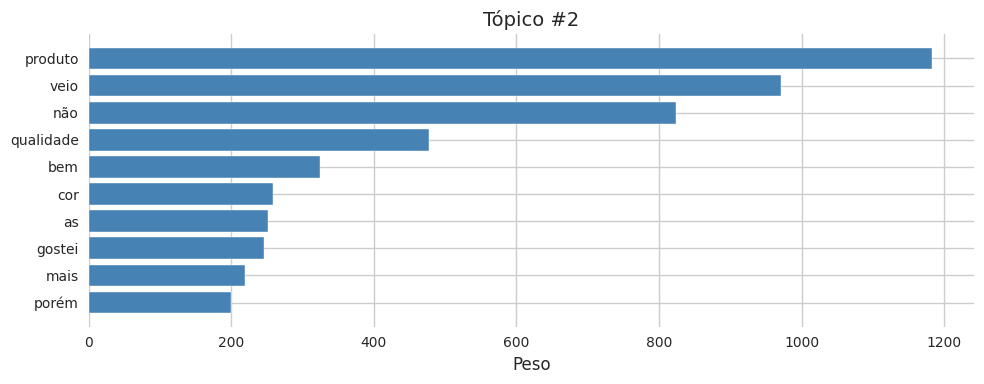

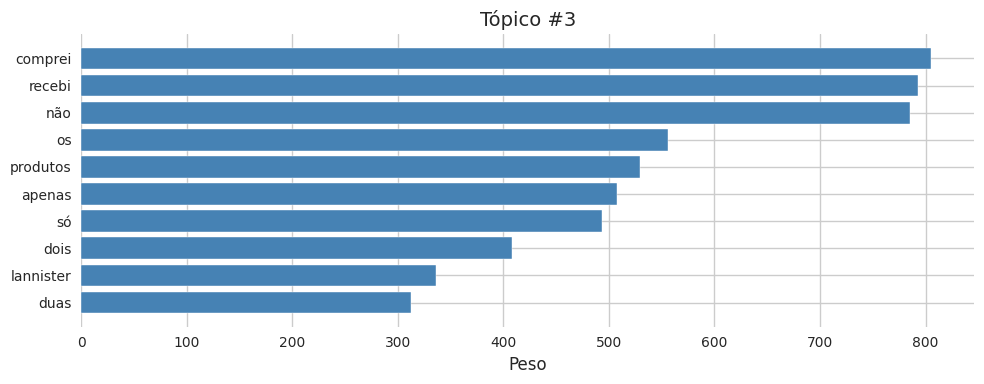

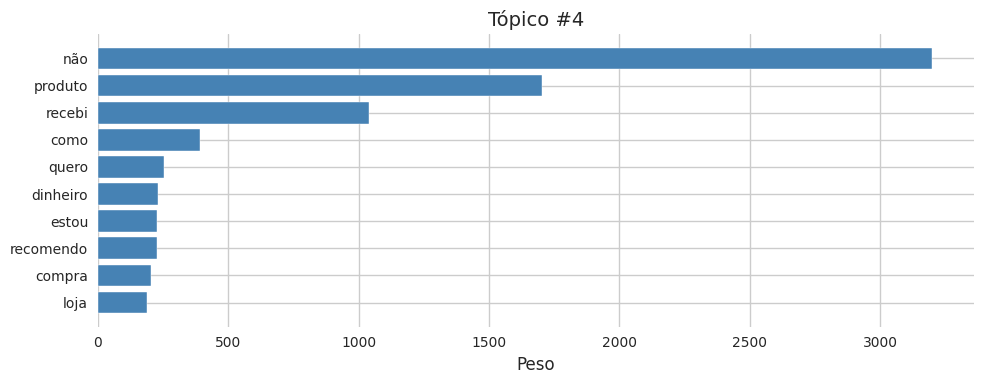

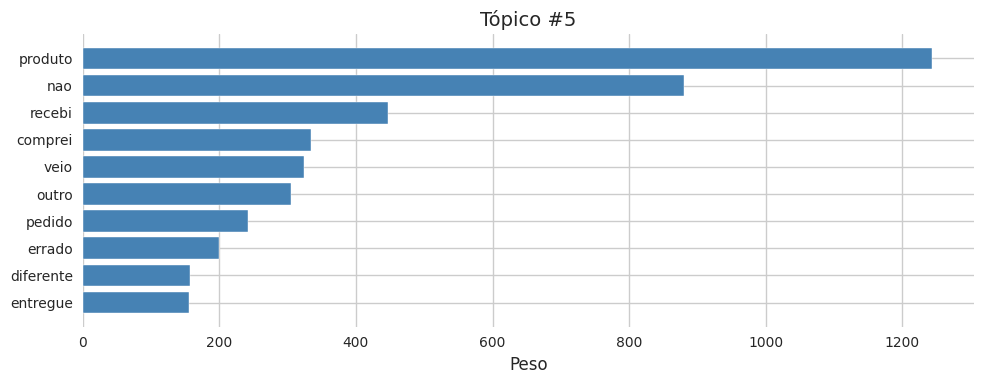

In [ ]:
# --- 1. Importações ---
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import joblib

# --- 2. Carregar Dados ---
try:
    train_path = '/content/data/raw/train.csv'
    df_train = pd.read_csv(train_path)
    print("✅ Arquivo 'train.csv' carregado com sucesso.")
except FileNotFoundError:
    raise SystemExit("❌ ERRO: O arquivo train.csv não foi encontrado.")

# --- 3. Stopwords e Pré-processamento ---
STOP_WORDS = [
    'a', 'o', 'e', 'ou', 'de', 'do', 'da', 'dos', 'das', 'em', 'no', 'na', 'nos', 'nas', 'por', 'para', 'com', 'sem',
    'mas', 'se', 'que', 'um', 'uma', 'uns', 'umas', 'à', 'às', 'ao', 'aos', 'qual', 'quais', 'quem', 'cujo', 'cujos',
    'cuja', 'cujas', 'este', 'estes', 'esta', 'estas', 'aquele', 'aqueles', 'aquela', 'aquelas', 'isso', 'isto',
    'aquilo', 'pelo', 'pela', 'pelos', 'pelas', 'seu', 'seus', 'sua', 'suas', 'meu', 'meus', 'minha', 'minhas',
    'teu', 'teus', 'tua', 'tuas', 'nosso', 'nossos', 'nossa', 'nossas', 'vosso', 'vossos', 'vossa', 'vossas',
    'ele', 'ela', 'eles', 'elas', 'eu', 'tu', 'nós', 'vós', 'já', 'ainda', 'também', 'muito', 'muitos', 'pouco',
    'poucos', 'grande', 'grandes', 'pequeno', 'pequenos', 'ser', 'sido', 'sendo', 'ter', 'tido', 'tendo', 'haver',
    'havido', 'havendo', 'estar', 'estado', 'estando', 'ir', 'ido', 'indo', 'vir', 'vindo', 'fazer', 'feito',
    'fazendo', 'dizer', 'dito', 'dizendo', 'poder', 'podido', 'podendo', 'querer', 'querido', 'querendo', 'dever',
    'devido', 'devendo', 'pra', 'pro', 'tá', 'né', 'aí', 'foi', 'era', 'ta', 'q', 'me'
]

def preprocess_text_manual(text):
    if not isinstance(text, str):
        return ''
    text = text.lower()
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    text = re.sub(r'\d+', '', text)
    tokens = re.findall(r'\b\w+\b', text)
    tokens = [word for word in tokens if word not in STOP_WORDS]
    return ' '.join(tokens)

# --- 4. Filtrar comentários negativos ---
print("🔍 Pré-processando comentários negativos...")
df_negativos = df_train[df_train['review_score'] == 0].dropna(subset=['review_comment_message']).copy()
df_negativos['texto_limpo'] = df_negativos['review_comment_message'].apply(preprocess_text_manual)

# --- 5. Vetorização ---
vectorizer = CountVectorizer(max_df=0.9, min_df=3, stop_words=STOP_WORDS)
X = vectorizer.fit_transform(df_negativos['texto_limpo'])

# --- 6. LDA ---
num_topicos = 5
print(f"⚙️ Treinando modelo LDA com {num_topicos} tópicos...")
lda = LatentDirichletAllocation(n_components=num_topicos, random_state=42)
lda.fit(X)

# Salvar modelos
joblib.dump(vectorizer, 'lda_vectorizer.pkl')
joblib.dump(lda, 'lda_model.pkl')
print("💾 Modelos salvos: lda_vectorizer.pkl e lda_model.pkl")

# --- 7. Exibir tópicos com gráfico ---
def plot_topicos(modelo, feature_names, n_palavras=10):
    for idx, topic in enumerate(modelo.components_):
        top_features = topic.argsort()[:-n_palavras - 1:-1]
        top_words = [feature_names[i] for i in top_features]
        top_weights = topic[top_features]

        plt.figure(figsize=(10, 4))
        plt.barh(top_words[::-1], top_weights[::-1], color='steelblue')
        plt.xlabel("Peso")
        plt.title(f"Tópico #{idx + 1}")
        plt.tight_layout()
        plt.show()

# --- 8. Visualização final ---
print("\n📊 Tópicos encontrados nos comentários negativos:")
plot_topicos(lda, vectorizer.get_feature_names_out(), n_palavras=10)


## 🧠 Análise de Emoções nos Comentários

Esta seção avalia a presença de **palavras positivas** e **negativas** em comentários feitos pelos clientes, com base em uma lista pré-definida de palavras.

As seguintes métricas foram calculadas para cada comentário:

- `n_words`: número de palavras no comentário
- `positive_hits`: contagem de palavras positivas
- `negative_hits`: contagem de palavras negativas
- `emotion_density`: razão entre hits (positivos + negativos) e número total de palavras

Em seguida, os resultados foram agregados por `review_score` e visualizados com um `heatmap`.

### 🔍 Lista de Palavras Consideradas

- **Positivas**: ótimo, excelente, bom, recomendo, maravilhoso, rápido, adorei, perfeito, qualidade, satisfeito  
- **Negativas**: ruim, péssimo, demorado, atraso, cancelado, devolução, problema, erro, horrível

---

### 📊 Densidade Emocional por Review Score

Abaixo está o heatmap que mostra as estatísticas agregadas da densidade emocional para comentários positivos (score = 1) e negativos (score = 0):



> **Interpretação**:  
> - Comentários com score 1 possuem uma densidade emocional significativamente maior, sugerindo maior uso de palavras com polaridade forte (positiva ou negativa).  
> - Comentários com score 0 possuem menor densidade, o que pode indicar avaliações mais diretas ou objetivas, sem muitos adjetivos.

---


✅ Arquivo carregado com sucesso.


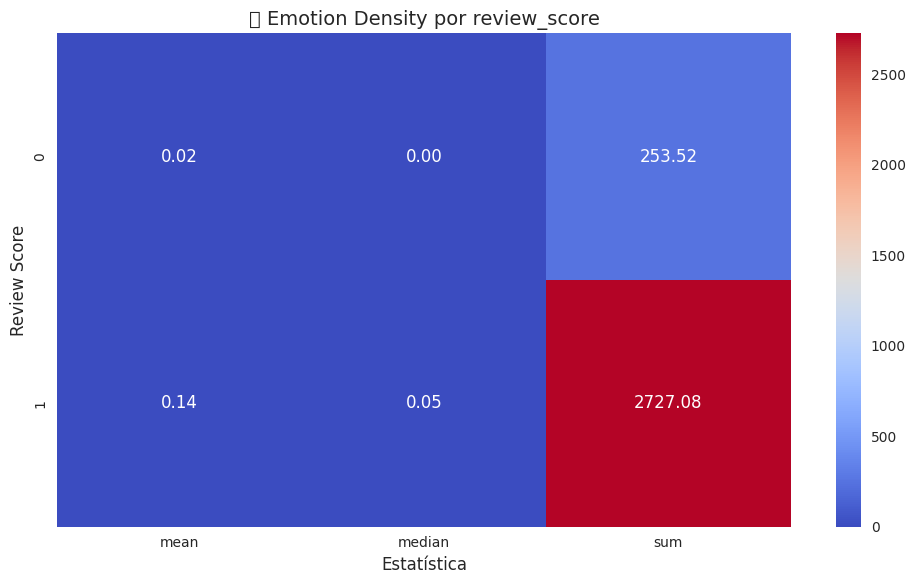

positive_hits               negative_hits               \
                      mean median    sum          mean median   sum   
review_score                                                          
0                    0.132  0.000   1492         0.105  0.000  1178   
1                    0.651  1.000  13144         0.017  0.000   351   

             emotion_density                  
                        mean median      sum  
review_score                                  
0                      0.023  0.000  253.517  
1                      0.135  0.045 2727.085

In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Carregamento dos Dados ---
try:
    train_path = '/content/data/raw/train.csv'
    df_train = pd.read_csv(train_path)
    print("✅ Arquivo carregado com sucesso.")
except FileNotFoundError:
    print("❌ ERRO: O arquivo train.csv não foi encontrado.")
    exit()

# --- 2. Definir Listas de Palavras Positivas e Negativas ---
positive_words = [
    'ótimo', 'excelente', 'bom', 'recomendo', 'maravilhoso',
    'rápido', 'adorei', 'perfeito', 'qualidade', 'satisfeito'
]

negative_words = [
    'ruim', 'péssimo', 'demorado', 'atraso', 'cancelado',
    'devolução', 'problema', 'erro', 'horrível'
    # Removido "não recebi" para evitar erro em tokenização palavra a palavra
]

# --- 3. Funções de Pré-processamento ---
def tokenize(text):
    if pd.isna(text):
        return []
    return re.findall(r'\b\w+\b', str(text).lower())

def count_exact_matches(tokens, keywords):
    return sum(1 for word in tokens if word in keywords)

# --- 4. Processar Comentários ---
df_text = df_train[df_train["review_comment_message"].notnull()].copy()
df_text["tokens"] = df_text["review_comment_message"].apply(tokenize)
df_text["n_words"] = df_text["tokens"].apply(len)
df_text["positive_hits"] = df_text["tokens"].apply(lambda x: count_exact_matches(x, positive_words))
df_text["negative_hits"] = df_text["tokens"].apply(lambda x: count_exact_matches(x, negative_words))
df_text["emotion_density"] = (df_text["positive_hits"] + df_text["negative_hits"]) / (df_text["n_words"] + 1e-6)

# --- 5. Estatísticas Agregadas ---
def summarize_emotions(df):
    return df.groupby("review_score")[["positive_hits", "negative_hits", "emotion_density"]].agg(["mean", "median", "sum"])

emotion_stats = summarize_emotions(df_text)

# --- 6. Visualização ---
plt.figure(figsize=(10, 6))
sns.heatmap(emotion_stats["emotion_density"], annot=True, fmt=".2f", cmap="coolwarm")
plt.title("📊 Emotion Density por review_score")
plt.ylabel("Review Score")
plt.xlabel("Estatística")
plt.tight_layout()
plt.show()

# --- 7. Exibir Tabela ---
display(emotion_stats)


In [ ]:
df_text

review_id  \
0      ae766d965b50c4a0e1bbae31b9b5aa2b   
1      650cb23e40e2257c397653e932bfb685   
2      95992db6a1a05c5f9d1c387f53e2924a   
3      9d5cfc4943f6f724a28d60f8762d2860   
4      03557726ff6e30acaff4519c8cc33765   
...                                 ...   
31452  c164ceed89570a3a4df7ab5cde106c2d   
31453  db0768e63b9ebaf62c190145eaadf982   
31454  7bbc72246e0986d1e4cb731ba10c1ac9   
31455  8ddff7b790fbde17391a9bea9830e3f3   
31456  24eb41443afb44f38c39dfece2784158   

                                  review_comment_message customer_state  \
0      Faz um mês que comprei o livro, já paguei e at...             SP   
1                         MATERIAL NÃO ENTREGUE NO PRAZO             ES   
2      Recomendo, pois o produto adquirido é muito li...             SP   
3                                  muito rápido e seguro             RJ   
4                  Produto de qualidade e entrega rápida             MT   
...                                                  ...            ...   
31452  Chegou até antes do prazo.\r\nAgora aguardo a ...             RJ   
31453   Produto nunca chegou a mim já com tanto tempo .              PI   
31454  Infelizmente o produto da foto é diferente do ...             SC   
31455  Comprei o produto no inicio de fevereiro e ain...             PR   
31456  A compra feita em janeiro, não entregue, agora...             SP   

      order_status   product_category_name  review_score  \
0        delivered  books_general_interest             0   
1        delivered               telephony             0   
2        delivered          sports_leisure             0   
3        delivered          sports_leisure             1   
4        delivered           watches_gifts             1   
...            ...                     ...           ...   
31452    delivered               telephony             1   
31453    delivered                    auto             0   
31454    delivered         furniture_decor             0   
31455    delivered               perfumery             0   
31456    delivered               telephony             0   

                                                  tokens  n_words  \
0      [faz, um, mês, que, comprei, o, livro, já, pag...       20   
1                   [material, não, entregue, no, prazo]        5   
2      [recomendo, pois, o, produto, adquirido, é, mu...       29   
3                             [muito, rápido, e, seguro]        4   
4           [produto, de, qualidade, e, entrega, rápida]        6   
...                                                  ...      ...   
31452  [chegou, até, antes, do, prazo, agora, aguardo...       12   
31453  [produto, nunca, chegou, a, mim, já, com, tant...        9   
31454  [infelizmente, o, produto, da, foto, é, difere...       24   
31455  [comprei, o, produto, no, inicio, de, fevereir...       17   
31456  [a, compra, feita, em, janeiro, não, entregue,...       18   

       positive_hits  negative_hits  emotion_density  
0                  0              0            0.000  
1                  0              0            0.000  
2                  2              1            0.103  
3                  1              0            0.250  
4                  1              0            0.167  
...              ...            ...              ...  
31452              0              0            0.000  
31453              0              0            0.000  
31454              0              0            0.000  
31455              0              0            0.000  
31456              0              0            0.000  

[31457 rows x 11 columns]

## 📊 Média de Palavras Emocionais por Sentimento

A visualização abaixo compara a quantidade média de palavras emocionais (positivas e negativas) nos comentários com base no score de avaliação (`review_score`):

### 🔍 Interpretação:
- **Comentários Positivos (Review Score = 1)** possuem maior média de palavras positivas (`positive_hits`) e também maior densidade emocional (`emotion_density`).
- **Comentários Negativos (Review Score = 0)** contêm proporcionalmente mais palavras negativas, embora a densidade emocional média seja inferior.
- A métrica `emotion_density` considera a razão entre palavras emocionais (positivas + negativas) e o número total de palavras no comentário.

### 🧠 Conclusão:
A densidade de emoção e o uso de palavras positivas são bons indicadores para distinguir entre comentários positivos e negativos.


<Figure size 1000x600 with 0 Axes>

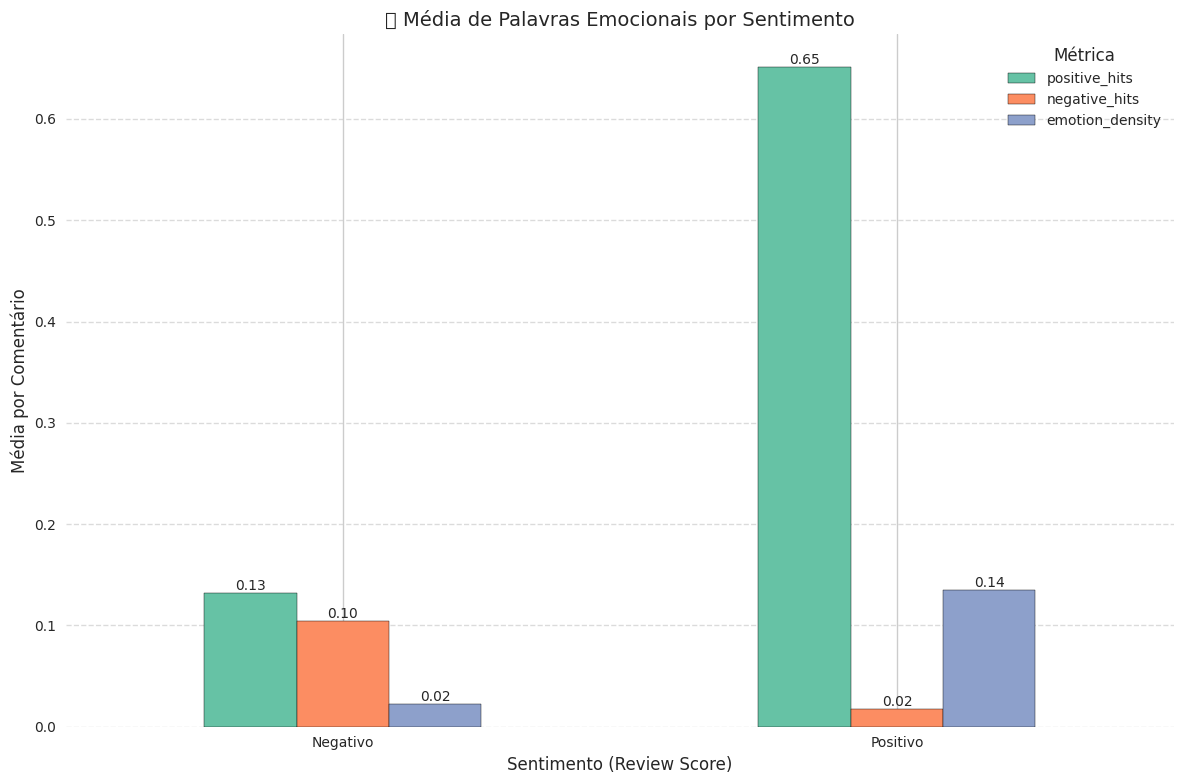

In [ ]:
import matplotlib.pyplot as plt

# Extrair as médias do DataFrame
means = emotion_stats.xs("mean", axis=1, level=1)

# Renomear os índices para tornar o gráfico mais intuitivo
means.index = means.index.map({0: "Negativo", 1: "Positivo"})

# Plot
plt.figure(figsize=(10, 6))
ax = means.plot(kind="bar", color=["#66c2a5", "#fc8d62", "#8da0cb"], edgecolor='black')

# Título e eixos
plt.title("📊 Média de Palavras Emocionais por Sentimento", fontsize=14)
plt.ylabel("Média por Comentário", fontsize=12)
plt.xlabel("Sentimento (Review Score)", fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Legenda e layout
plt.legend(title="Métrica", loc='upper right')
plt.tight_layout()

# Adiciona rótulo nas barras
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{height:.2f}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=10)

plt.show()


# 🔍 Análise de Proporção de Avaliações Negativas por Estado e Categoria

Esta análise cruza os campos `customer_state`, `product_category_name` e `review_score` para identificar padrões em avaliações negativas (pontuação igual a 0).

## 📌 Objetivos
- Identificar combinações estado + categoria com maior proporção de avaliações negativas.
- Considerar somente combinações com volume estatisticamente relevante (mínimo de 20 avaliações).

---

## 📊 Top 10 Combinações com Maior Proporção de Avaliações Negativas

Essas são as 10 combinações estado + categoria com maior proporção de avaliações negativas:



---

## 🔥 Heatmap: Proporção de Avaliações Negativas por Estado e Categoria

Visualização da densidade de avaliações negativas por estado e categoria de produto. Células mais escuras representam maior proporção de avaliações negativas:


---

## 📈 Dispersão: Volume vs. Proporção de Negativas

Análise de dispersão entre número absoluto de avaliações negativas e a proporção em relação ao total de avaliações na combinação estado + categoria:


---

## 📉 Distribuição da Proporção de Avaliações Negativas

Histograma da distribuição das proporções de avaliações negativas em todas as combinações filtradas:


---

## 🧠 Conclusões

- Categorias como `baby`, `office_furniture` e `construction_tools_construction` possuem alta taxa de insatisfação em estados específicos.
- O estado **DF** com a categoria **baby** lidera em proporção negativa.
- A maioria das proporções varia entre **30% e 40%**, mas há casos extremos acima de **60%**.
- Não há correlação direta entre volume e proporção de negativas: categorias com baixo volume podem ter altos índices de insatisfação.

---

> ✅ Caso deseje gerar uma visualização interativa ou exportar as combinações em Excel/CSV, posso gerar esse código para você.


customer_state            product_category_name  total_reviews  \
190              DF                             baby             20   
782              RJ                 office_furniture             94   
421              MG                 office_furniture             40   
747              RJ  construction_tools_construction             34   
1001             SP                              art             29   
...             ...                              ...            ...   
384              MG                   consoles_games             37   
709              PR                     garden_tools             48   
1009             SP                  books_technical             29   
479              MT                   bed_bath_table             27   
907              RS                         pet_shop             27   

      negative_count  negative_ratio  
190           14.000           0.700  
782           57.000           0.606  
421           24.000           0.600  
747           20.000           0.588  
1001          16.000           0.552  
...              ...             ...  
384            6.000           0.162  
709            7.000           0.146  
1009           4.000           0.138  
479            3.000           0.111  
907            3.000           0.111  

[252 rows x 5 columns]

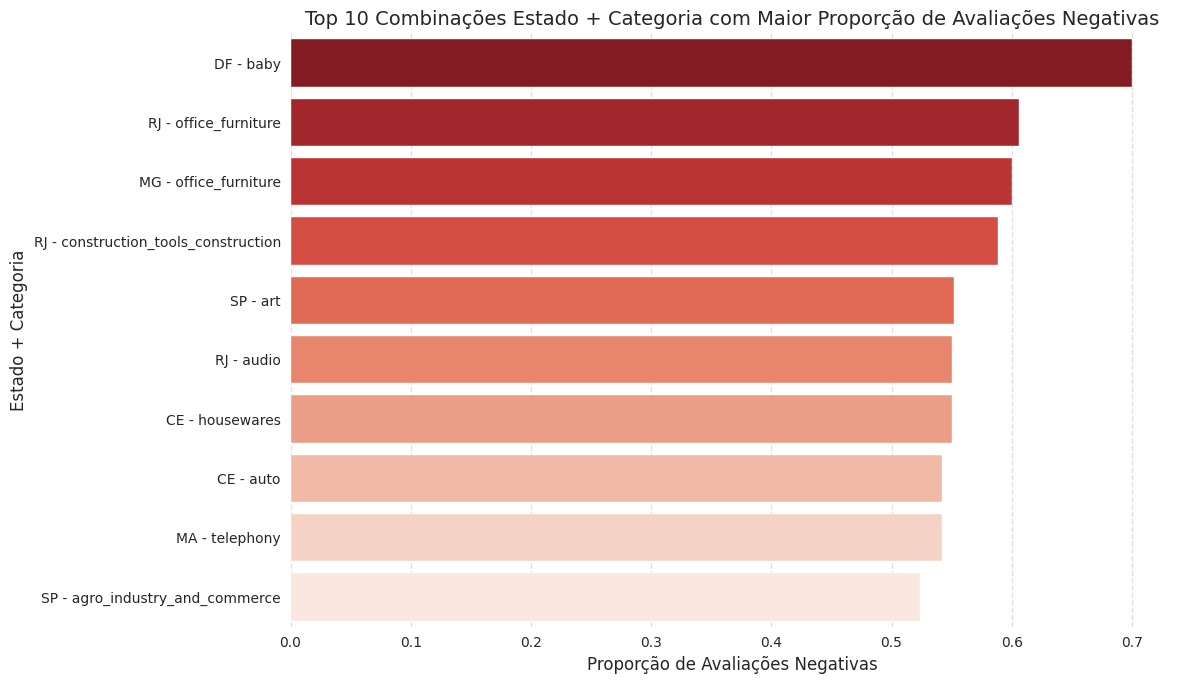

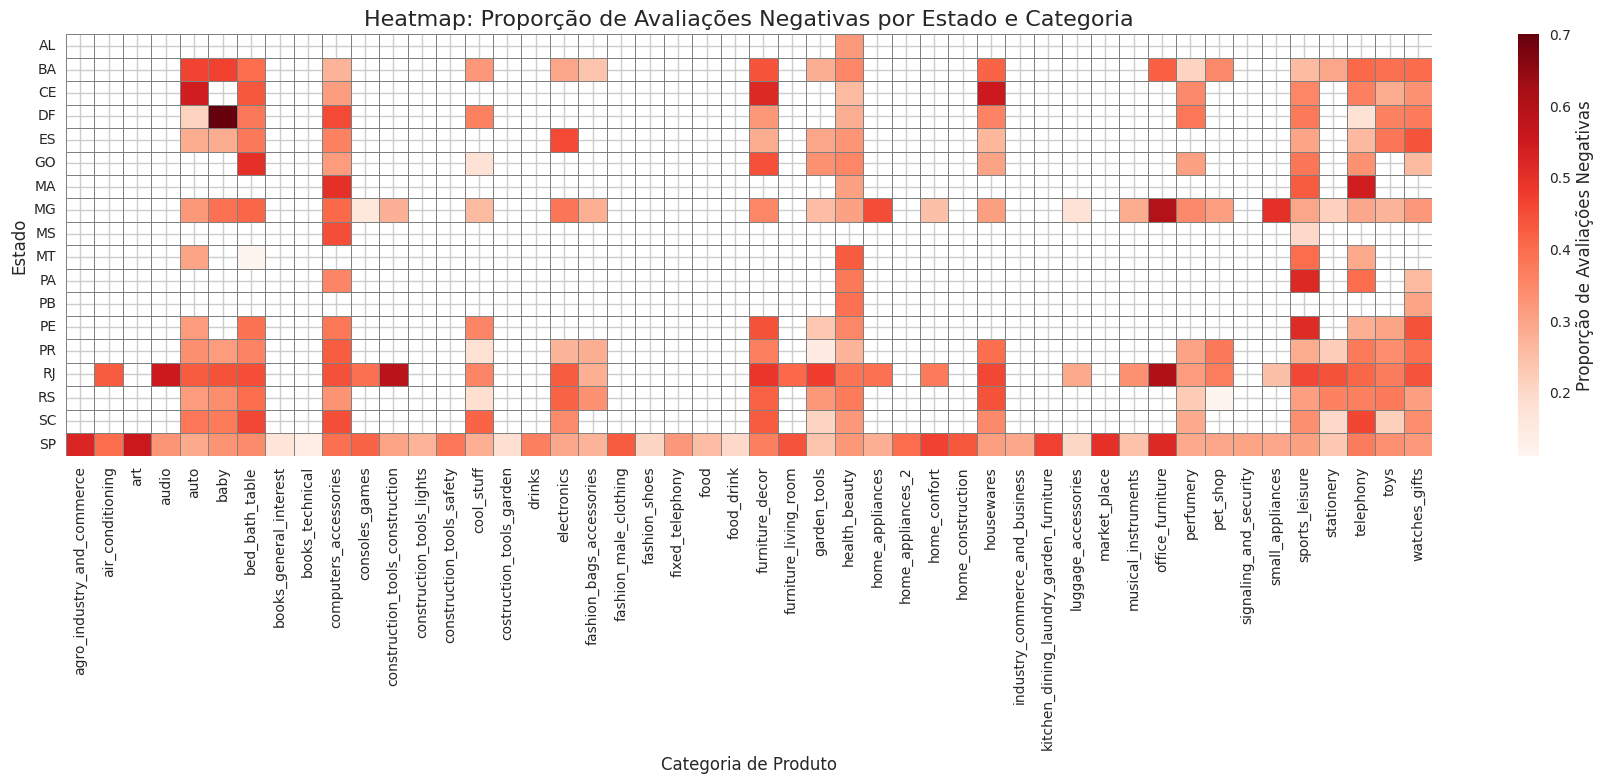

In [ ]:
import pandas as pd
from IPython.display import display

# Agrupar e contar avaliações por estado, categoria e score
review_counts = df_train.groupby(["customer_state", "product_category_name", "review_score"]).size().reset_index(name="review_count")

# Obter total de avaliações por estado e categoria
total_reviews = review_counts.groupby(["customer_state", "product_category_name"])["review_count"].sum().reset_index(name="total_reviews")

# Obter número de avaliações negativas (review_score == 0)
negative_reviews = review_counts[review_counts["review_score"] == 0][["customer_state", "product_category_name", "review_count"]]
negative_reviews = negative_reviews.rename(columns={"review_count": "negative_count"})

# Mesclar totais com negativos
merged_reviews = pd.merge(total_reviews, negative_reviews, on=["customer_state", "product_category_name"], how="left")
merged_reviews["negative_count"] = merged_reviews["negative_count"].fillna(0)

# Calcular proporção de avaliações negativas
merged_reviews["negative_ratio"] = merged_reviews["negative_count"] / merged_reviews["total_reviews"]

# Filtrar combinações com volume mínimo para garantir significância estatística
min_reviews = 20
filtered_results = merged_reviews[merged_reviews["total_reviews"] >= min_reviews]
filtered_results = filtered_results.sort_values("negative_ratio", ascending=False)

# Exibir resultado
display(filtered_results)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Agrupamento e cálculo da proporção de avaliações negativas por estado e categoria ---
grouped = df_train.groupby(["customer_state", "product_category_name", "review_score"]).size().reset_index(name="count")

# Total de avaliações por estado + categoria
total = grouped.groupby(["customer_state", "product_category_name"])["count"].sum().reset_index(name="total")

# Apenas as negativas
neg = grouped[grouped["review_score"] == 0][["customer_state", "product_category_name", "count"]].rename(columns={"count": "negatives"})

# Merge e cálculo de proporção
merged = pd.merge(total, neg, on=["customer_state", "product_category_name"], how="left")
merged["negatives"] = merged["negatives"].fillna(0)
merged["negative_ratio"] = merged["negatives"] / merged["total"]

# Filtro mínimo de 20 avaliações
filtered = merged[merged["total"] >= 20].copy()

# --- 2. Gráfico: Top 10 combinações com maior proporção negativa ---
top10 = filtered.sort_values("negative_ratio", ascending=False).head(10)
top10["comb"] = top10["customer_state"] + " - " + top10["product_category_name"]

plt.figure(figsize=(12, 7))
sns.barplot(data=top10, x="negative_ratio", y="comb", palette="Reds_r")
plt.title("Top 10 Combinações Estado + Categoria com Maior Proporção de Avaliações Negativas", fontsize=14)
plt.xlabel("Proporção de Avaliações Negativas")
plt.ylabel("Estado + Categoria")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# --- 3. Heatmap: Estado × Categoria com proporção de avaliações negativas ---
heatmap_data = filtered.pivot(index="customer_state", columns="product_category_name", values="negative_ratio")

plt.figure(figsize=(18, 8))
sns.heatmap(heatmap_data, cmap="Reds", linewidths=0.5, linecolor='gray', cbar_kws={'label': 'Proporção de Avaliações Negativas'})
plt.title("Heatmap: Proporção de Avaliações Negativas por Estado e Categoria", fontsize=16)
plt.xlabel("Categoria de Produto")
plt.ylabel("Estado")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



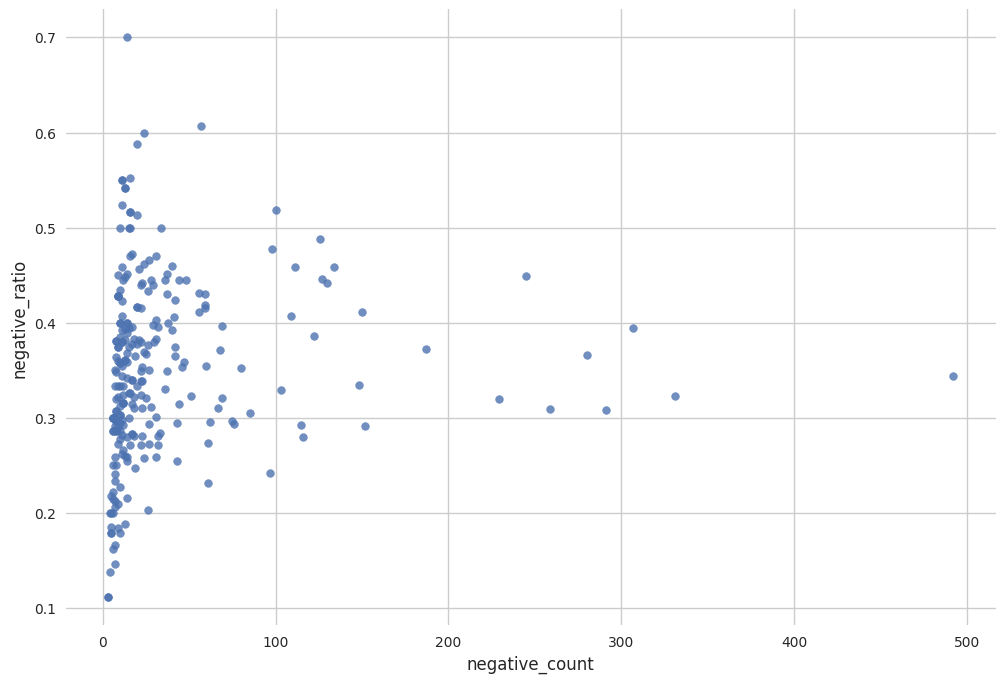

In [ ]:
from matplotlib import pyplot as plt
filtered_results.plot(kind='scatter', x='negative_count', y='negative_ratio', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

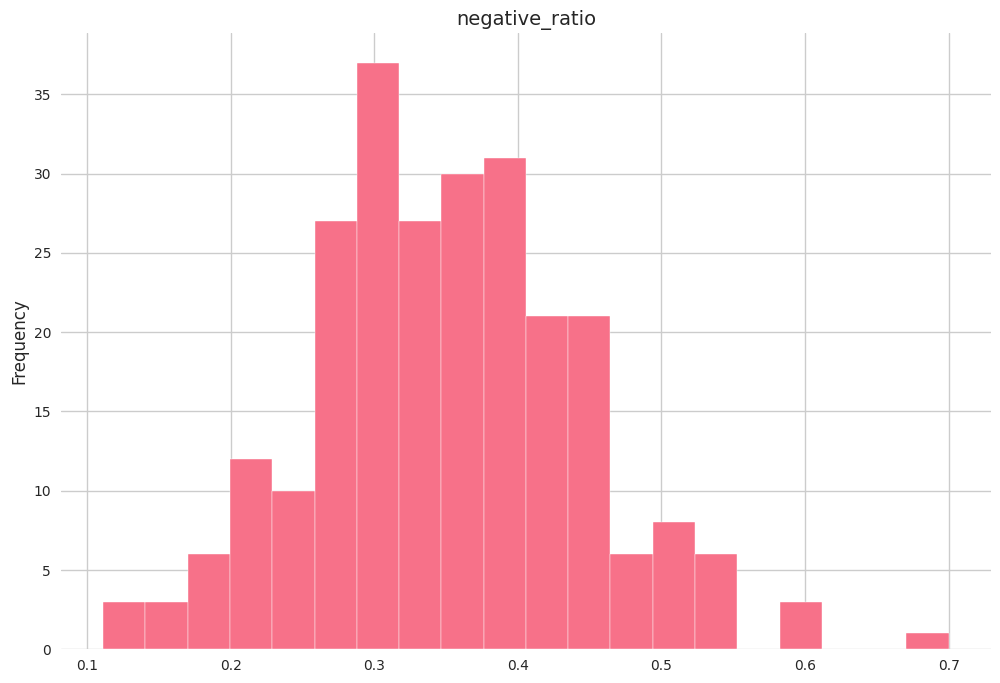

In [ ]:
from matplotlib import pyplot as plt
filtered_results['negative_ratio'].plot(kind='hist', bins=20, title='negative_ratio')
plt.gca().spines[['top', 'right',]].set_visible(False)

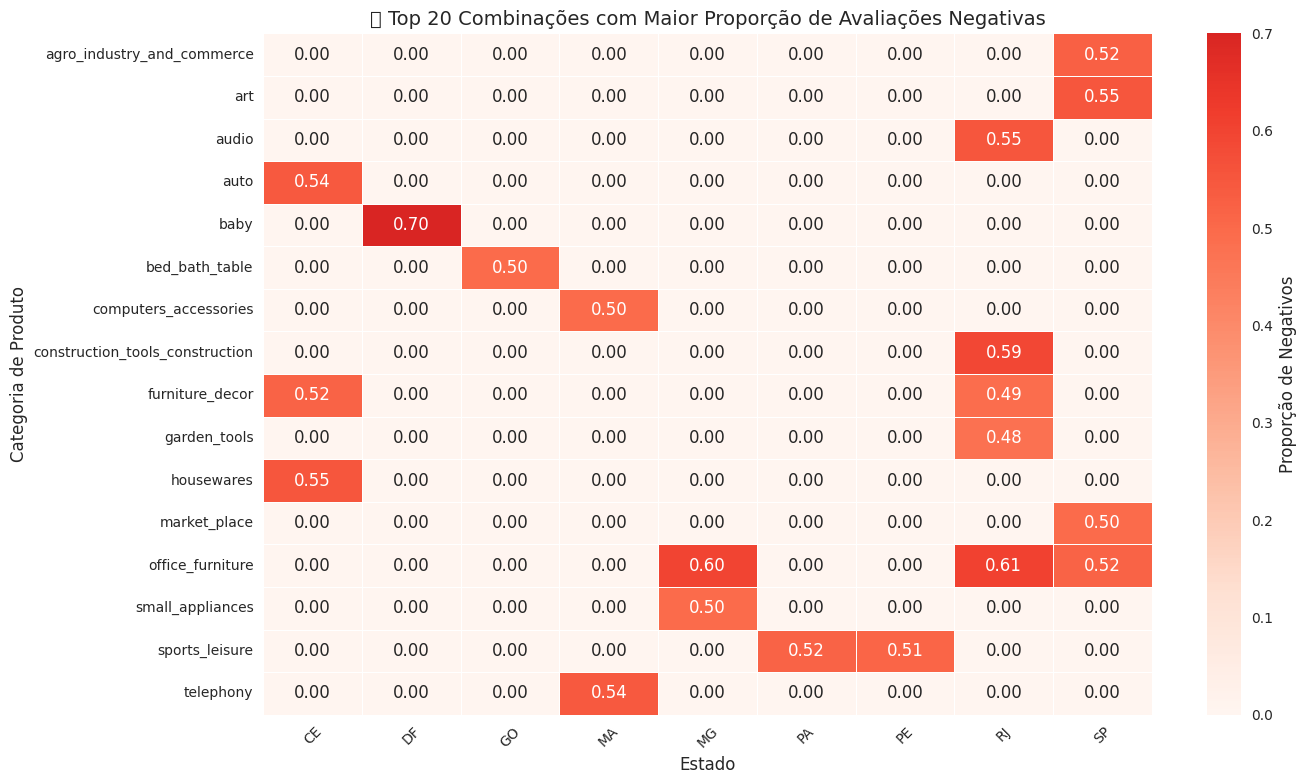

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Validação básica
required_columns = {"product_category_name", "customer_state", "negative_ratio"}
if not required_columns.issubset(filtered.columns):
    raise ValueError("O DataFrame 'filtered' precisa conter as colunas: 'product_category_name', 'customer_state', 'negative_ratio'")

# Selecionar Top 20 por maior proporção de negativos
top20 = filtered.sort_values("negative_ratio", ascending=False).head(20).copy()

# Reordenar categorias por média para facilitar visualização
top20["category_mean"] = top20.groupby("product_category_name")["negative_ratio"].transform("mean")
top20 = top20.sort_values("category_mean", ascending=False)

# Pivotar para formato de heatmap
heatmap_data = top20.pivot(index="product_category_name", columns="customer_state", values="negative_ratio").fillna(0)

# Plotar heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap="Reds",
    linewidths=0.5,
    cbar_kws={"label": "Proporção de Negativos"},
    center=0.5
)

plt.title("🔥 Top 20 Combinações com Maior Proporção de Avaliações Negativas", fontsize=14)
plt.xlabel("Estado", fontsize=12)
plt.ylabel("Categoria de Produto", fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


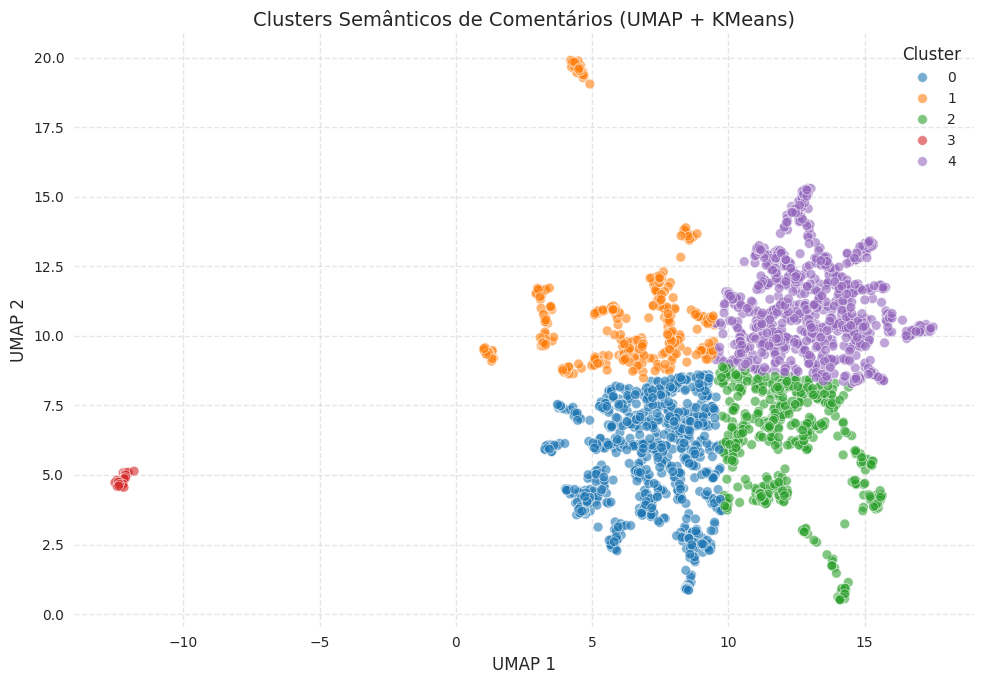


📌 Cluster 0 — exemplos:
• O produto veio como descrito na página e chegou bem antes do prazo determinado. Recomendo!
• Entrega super rápida. Recomendo
• Produto entregue antes do prazo.. Super recomendo

📌 Cluster 1 — exemplos:
• Tudo ok
• Atendeu minhas expectativas, bom
• Chegou tudo certinho nos conformes muito bem

📌 Cluster 2 — exemplos:
• O baratheon è esxelente Amo adoro o baratheon
• Grande , cabe bastante coisa!
• Bandeja não é estável. É presa apenas por um único eixo central, que gira com um mínimo de esforço. Elementos de fixação de plástico. Parafusos e porcas de difícil aperto. Falta manual. Mal embalado.

📌 Cluster 3 — exemplos:
• Muito bom!
• muito bom 
• Muito bom

📌 Cluster 4 — exemplos:
• PRODUTO VEIO COM VENCIMENTO PARA DEZEMBRO, COMPREI OUTROS COM VENCIMENTO DE 2 ANOS.

• Veio a cor errada e não estou conseguindo encaixar corretamente as pulseiras.
• Só o pendente de madeira que veio, o outro não veio. Junto ao correio só existe um número para rastreamento com um 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
import umap.umap_ as umap

# --- 1. Carregamento de Dados ---
def load_data(path: str) -> pd.DataFrame:
    try:
        return pd.read_csv(path)
    except FileNotFoundError:
        raise FileNotFoundError(f"Arquivo não encontrado: {path}")

train_path = '/content/data/raw/train.csv'
df_train = load_data(train_path)

# --- 2. Stopwords customizadas ---
STOP_WORDS = [
    'a', 'o', 'e', 'ou', 'de', 'do', 'da', 'dos', 'das', 'em', 'no', 'na', 'nos', 'nas',
    'por', 'para', 'com', 'sem', 'mas', 'se', 'que', 'um', 'uma', 'uns', 'umas', 'à',
    'às', 'ao', 'aos', 'qual', 'quais', 'quem', 'cujo', 'cujos', 'cuja', 'cujas', 'este',
    'estes', 'esta', 'estas', 'aquele', 'aqueles', 'aquela', 'aquelas', 'isso', 'isto',
    'aquilo', 'pelo', 'pela', 'pelos', 'pelas', 'seu', 'seus', 'sua', 'suas', 'meu',
    'meus', 'minha', 'minhas', 'teu', 'teus', 'tua', 'tuas', 'nosso', 'nossos', 'nossa',
    'nossas', 'vosso', 'vossos', 'vossa', 'vossas', 'ele', 'ela', 'eles', 'elas', 'eu',
    'tu', 'nós', 'vós', 'já', 'ainda', 'também', 'muito', 'muitos', 'pouco', 'poucos',
    'grande', 'grandes', 'pequeno', 'pequenos', 'ser', 'sido', 'sendo', 'ter', 'tido',
    'tendo', 'haver', 'havido', 'havendo', 'estar', 'estado', 'estando', 'ir', 'ido',
    'indo', 'vir', 'vindo', 'fazer', 'feito', 'fazendo', 'dizer', 'dito', 'dizendo',
    'poder', 'podido', 'podendo', 'querer', 'querido', 'querendo', 'dever', 'devido',
    'devendo', 'pra', 'pro', 'tá', 'né', 'aí', 'foi', 'era', 'ta', 'q', 'me'
]

# --- 3. Amostragem e Limpeza ---
def preprocess_comments(df: pd.DataFrame, n_samples: int = 3000) -> pd.DataFrame:
    df_clean = df[df["review_comment_message"].notnull()].copy()
    return df_clean.sample(n=n_samples, random_state=42)

sample_df = preprocess_comments(df_train)

# --- 4. Vetorização TF-IDF ---
vectorizer = TfidfVectorizer(max_features=3000, stop_words=STOP_WORDS)
X_tfidf = vectorizer.fit_transform(sample_df["review_comment_message"])

# --- 5. Redução de Dimensionalidade: SVD + UMAP ---
svd = TruncatedSVD(n_components=50, random_state=42)
X_svd = svd.fit_transform(X_tfidf)

umap_model = umap.UMAP(n_neighbors=20, min_dist=0.3, metric='cosine', random_state=42)
X_umap = umap_model.fit_transform(X_svd)

# --- 6. Clustering com KMeans ---
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_umap)

# --- 7. Enriquecimento do DataFrame ---
sample_df["cluster"] = clusters
sample_df["x_umap"] = X_umap[:, 0]
sample_df["y_umap"] = X_umap[:, 1]

# --- 8. Visualização ---
def plot_clusters(df: pd.DataFrame) -> None:
    plt.figure(figsize=(10, 7))
    sns.scatterplot(data=df, x="x_umap", y="y_umap", hue="cluster", palette="tab10", alpha=0.6)
    plt.title("Clusters Semânticos de Comentários (UMAP + KMeans)", fontsize=14)
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.legend(title="Cluster")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

plot_clusters(sample_df)

# --- 9. Amostras de Comentários por Cluster ---
def print_sample_comments(df: pd.DataFrame, n_samples: int = 3):
    for cluster_id in sorted(df["cluster"].unique()):
        exemplos = df[df["cluster"] == cluster_id]["review_comment_message"].sample(n=n_samples, random_state=42)
        print(f"\n📌 Cluster {cluster_id} — exemplos:")
        for comment in exemplos:
            print(f"• {comment}")

print_sample_comments(sample_df)


In [ ]:
vectorizer

TfidfVectorizer(max_features=3000,
                stop_words=['a', 'o', 'e', 'ou', 'de', 'do', 'da', 'dos', 'das',
                            'em', 'no', 'na', 'nos', 'nas', 'por', 'para',
                            'com', 'sem', 'mas', 'se', 'que', 'um', 'uma',
                            'uns', 'umas', 'à', 'às', 'ao', 'aos', 'qual', ...])

In [ ]:
sample_df["review_score"] = sample_df["review_score"].astype(str)  # garantir tipo string
sentiment_dist = sample_df.groupby("cluster")["review_score"].value_counts(normalize=True).unstack().fillna(0)
display(sentiment_dist)


review_score     0     1
cluster                 
0            0.053 0.947
1            0.159 0.841
2            0.350 0.650
3            0.018 0.982
4            0.769 0.231

In [ ]:
# --- 1. Definição semântica dos clusters ---
CLUSTER_LABELS = {
    0: "Produto bom com ressalvas",
    1: "Má qualidade percebida",
    2: "Entrega incompleta/falha",
    3: "Elogios detalhados",
    4: "Elogios breves"
}

# --- 2. Mapeando os rótulos descritivos no DataFrame ---
sample_df["cluster_label"] = sample_df["cluster"].map(CLUSTER_LABELS)

# --- 3. Impressão de exemplos por cluster com descrição ---
def exibir_exemplos_por_cluster(df, n_exemplos=3):
    for cluster_id, label in CLUSTER_LABELS.items():
        print(f"\n📌 Cluster {cluster_id} — {label} — exemplos:")
        exemplos = df[df["cluster"] == cluster_id]["review_comment_message"].dropna().sample(n=n_exemplos, random_state=42)
        for texto in exemplos:
            print(f"• {texto.strip()}")

# Chamar função para exibir exemplos
exibir_exemplos_por_cluster(sample_df)



📌 Cluster 0 — Produto bom com ressalvas — exemplos:
• O produto veio como descrito na página e chegou bem antes do prazo determinado. Recomendo!
• Entrega super rápida. Recomendo
• Produto entregue antes do prazo.. Super recomendo

📌 Cluster 1 — Má qualidade percebida — exemplos:
• Tudo ok
• Atendeu minhas expectativas, bom
• Chegou tudo certinho nos conformes muito bem

📌 Cluster 2 — Entrega incompleta/falha — exemplos:
• O baratheon è esxelente Amo adoro o baratheon
• Grande , cabe bastante coisa!
• Bandeja não é estável. É presa apenas por um único eixo central, que gira com um mínimo de esforço. Elementos de fixação de plástico. Parafusos e porcas de difícil aperto. Falta manual. Mal embalado.

📌 Cluster 3 — Elogios detalhados — exemplos:
• Muito bom!
• muito bom
• Muito bom

📌 Cluster 4 — Elogios breves — exemplos:
• PRODUTO VEIO COM VENCIMENTO PARA DEZEMBRO, COMPREI OUTROS COM VENCIMENTO DE 2 ANOS.
• Veio a cor errada e não estou conseguindo encaixar corretamente as pulseiras.
•

# 📊 Processamento dos Dados

## 🎯 Objetivo

Preparar os dados para serem utilizados de forma eficiente e robusta na etapa de modelagem. Esta fase garante que os dados estejam limpos, padronizados e adequadamente transformados para entrada nos modelos de machine learning e deep learning.

---

## 🧼 1. Limpeza dos Dados

- Remoção de registros duplicados
- Tratamento de valores nulos ou ausentes
- Padronização de textos (caixa baixa, remoção de acentos, caracteres especiais etc.)

---

## 🧠 2. Processamento dos Dados Textuais

- **Tokenização**
- **Remoção de stopwords**
- **Normalização textual**: stemming ou lemmatization (se aplicável)
- **Vetorização**:
  - Para baseline: TF-IDF ou CountVectorizer
  - Para modelo final: BERTimbau com `BertTokenizerFast`

---

## 🔢 3. Processamento de Variáveis Categóricas

- Variáveis: `order_status`, `customer_state`, `product_category_name`
- Estratégia:
  - **Label Encoding** para modelos baseados em árvore
  - **Embeddings treináveis** para modelos neurais

---

## 📐 4. Engenharia de Features

- Criação de variáveis adicionais (ex: comprimento do review, número de palavras positivas/negativas)
- Extração de bigramas/trigramas relevantes
- Análise de colinearidade e seleção de features

---

## 🗃️ 5. Divisão dos Dados

- Separação entre `train` e `validation` com **StratifiedKFold (k=5)**
- Garantia de que distribuição da variável `review_score` está balanceada em cada fold

---





## 🗂️ Configuração de Diretórios e Leitura Inicial dos Dados

Nesta célula, definimos a estrutura de diretórios do projeto e garantimos que todos os caminhos necessários existam antes de prosseguir com o processamento dos dados.

### 🔧 Ações realizadas:

- Definição dos caminhos principais:
  - `BASE_DIR`: diretório raiz do projeto
  - `RAW_DIR`: onde os dados brutos (.csv) estão localizados
  - `PROCESSED_DIR`: onde os dados processados serão salvos
  - `ENCODER_DIR`: onde os encoders (ex: LabelEncoder) serão armazenados após o treinamento

- Criação dos diretórios, se ainda não existirem, utilizando `Path.mkdir(parents=True, exist_ok=True)`.

- Impressão da estrutura de diretórios para fácil verificação.

- Tentativa de leitura do arquivo `train.csv` presente no diretório `data/raw/`, com checagem prévia de existência do arquivo.

> Esta célula é fundamental para garantir que o ambiente esteja corretamente configurado antes de qualquer etapa de pré-processamento, evitando erros futuros relacionados a caminhos inválidos ou arquivos ausentes.


In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
import pickle
from pathlib import Path

# 📁 Diretórios do projeto
BASE_DIR = Path("/content")
RAW_DIR = BASE_DIR / "data" / "raw"
PROCESSED_DIR = BASE_DIR / "data" / "processed"
ENCODER_DIR = PROCESSED_DIR / "encoders"

# ✅ Função para criar diretórios se não existirem
def create_directories(*dirs):
    for directory in dirs:
        directory.mkdir(parents=True, exist_ok=True)
        print(f"[✔️] Diretório garantido: {directory}")

# 🚀 Execução
if __name__ == "__main__":
    create_directories(RAW_DIR, PROCESSED_DIR, ENCODER_DIR)

    print("\n📂 Estrutura de diretórios definida com sucesso:")
    print(f"📌 BASE_DIR        : {BASE_DIR}")
    print(f"📌 RAW_DIR         : {RAW_DIR}")
    print(f"📌 PROCESSED_DIR   : {PROCESSED_DIR}")
    print(f"📌 ENCODER_DIR     : {ENCODER_DIR}")

    # Exemplo de uso: carregar CSV
    train_path = RAW_DIR / "train.csv"
    if train_path.exists():
        df = pd.read_csv(train_path)
        print(f"\n📄 Arquivo carregado: {train_path.name}")
        print(df.head())
    else:
        print(f"\n⚠️ Arquivo não encontrado: {train_path}")


[✔️] Diretório garantido: /content/data/raw
[✔️] Diretório garantido: /content/data/processed
[✔️] Diretório garantido: /content/data/processed/encoders

📂 Estrutura de diretórios definida com sucesso:
📌 BASE_DIR        : /content
📌 RAW_DIR         : /content/data/raw
📌 PROCESSED_DIR   : /content/data/processed
📌 ENCODER_DIR     : /content/data/processed/encoders

📄 Arquivo carregado: train.csv
                          review_id  \
0  ae766d965b50c4a0e1bbae31b9b5aa2b   
1  650cb23e40e2257c397653e932bfb685   
2  95992db6a1a05c5f9d1c387f53e2924a   
3  9d5cfc4943f6f724a28d60f8762d2860   
4  03557726ff6e30acaff4519c8cc33765   

                              review_comment_message customer_state  \
0  Faz um mês que comprei o livro, já paguei e at...             SP   
1                     MATERIAL NÃO ENTREGUE NO PRAZO             ES   
2  Recomendo, pois o produto adquirido é muito li...             SP   
3                              muito rápido e seguro             RJ   
4           

## 🧹 Tratamento de Valores Ausentes

Nesta etapa, realizamos a limpeza dos campos com dados ausentes nas colunas essenciais para a modelagem:

### 📦 `product_category_name`
- Preenchemos os valores ausentes com a string `"unknown"`.
- Também aplicamos `.str.strip()` para remover espaços em branco no início ou fim dos nomes das categorias, evitando problemas na codificação posterior.

### 💬 `review_comment_message`
- Preenchemos os valores nulos com uma string vazia `""`, pois campos vazios não devem atrapalhar o processamento textual.
- Também aplicamos `.str.strip()` para remover espaços laterais.

### ✅ Verificação
- Ao final, exibimos a contagem de valores ausentes nas colunas tratadas para garantir que todos foram corretamente preenchidos.

> Esse tratamento é fundamental para evitar erros em etapas futuras como vetorização, codificação ou embeddings.


In [ ]:
# 🧼 Tratamento de valores ausentes

# Preenche categorias de produto ausentes com 'unknown'
df["product_category_name"] = df["product_category_name"].fillna("unknown").str.strip()

# Preenche comentários ausentes com string vazia e remove espaços laterais
df["review_comment_message"] = df["review_comment_message"].fillna("").str.strip()

# Verificação opcional: contagem de nulos após o preenchimento
print("✔️ Valores ausentes tratados:")
print(df[["product_category_name", "review_comment_message"]].isnull().sum())


✔️ Valores ausentes tratados:
product_category_name     0
review_comment_message    0
dtype: int64


## 🧠 Codificação de Variáveis Categóricas

Para que os algoritmos de machine learning e deep learning possam utilizar variáveis categóricas, aplicamos técnicas de codificação para transformar essas colunas em valores numéricos:

---

### 1️⃣ `order_status` — Codificação Ordenada (OrdinalEncoder)

- Aplicamos **codificação ordenada** porque a variável possui uma progressão lógica (do pedido criado à entrega ou cancelamento).
- A ordem definida foi:
["created", "processing", "invoiced", "shipped", "delivered", "canceled", "unavailable"]

- O encoder foi salvo em disco para garantir reprodutibilidade nos experimentos futuros.

---

### 2️⃣ `customer_state` — Label Encoding (LabelEncoder)

- Transformamos os estados do cliente em valores numéricos únicos usando `LabelEncoder`.
- Ideal para algoritmos baseados em árvores ou embeddings.

---

### 3️⃣ `product_category_name` — Label Encoding (LabelEncoder)

- Codificamos os nomes das categorias dos produtos para permitir uso como embeddings em redes neurais ou como entrada em modelos tradicionais.
- Também foi salvo um encoder `.pkl` para uso futuro.

---

### 💾 Salvamento dos Encoders

Todos os encoders foram salvos no diretório: data/processed/encoders/


---

> Esse processo é essencial para garantir que os dados categóricos possam ser utilizados eficientemente pelos modelos, respeitando a semântica de ordem quando necessário.



In [ ]:
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
import pickle

# 📌 Codificação ordenada para 'order_status'
order_status_order = [
    "created", "processing", "invoiced", "shipped",
    "delivered", "canceled", "unavailable"
]
ordinal_encoder = OrdinalEncoder(categories=[order_status_order])
df["order_status_encoded"] = ordinal_encoder.fit_transform(df[["order_status"]])

# 💾 Salvar encoder para uso futuro
with open(ENCODER_DIR / "order_status_encoder.pkl", "wb") as f:
    pickle.dump(ordinal_encoder, f)

# 🌎 Label Encoding para 'customer_state'
le_state = LabelEncoder()
df["customer_state_encoded"] = le_state.fit_transform(df["customer_state"])

with open(ENCODER_DIR / "customer_state_encoder.pkl", "wb") as f:
    pickle.dump(le_state, f)

# 🛍️ Label Encoding para 'product_category_name'
le_category = LabelEncoder()
df["product_category_encoded"] = le_category.fit_transform(df["product_category_name"])

with open(ENCODER_DIR / "product_category_encoder.pkl", "wb") as f:
    pickle.dump(le_category, f)

# ✅ Verificação rápida
print("✔️ Codificação concluída:")
print(df[["order_status", "order_status_encoded", "customer_state", "customer_state_encoded",
          "product_category_name", "product_category_encoded"]].head(30))


✔️ Codificação concluída:
   order_status  order_status_encoded customer_state  customer_state_encoded  \
0     delivered                 4.000             SP                      25   
1     delivered                 4.000             ES                       7   
2     delivered                 4.000             SP                      25   
3     delivered                 4.000             RJ                      18   
4     delivered                 4.000             MT                      12   
5     delivered                 4.000             SP                      25   
6     delivered                 4.000             RS                      22   
7     delivered                 4.000             CE                       5   
8     delivered                 4.000             RJ                      18   
9     delivered                 4.000             SP                      25   
10    delivered                 4.000             SP                      25   
11   processin

## 💾 Salvamento do Dataset Processado

Após a conclusão do pré-processamento dos dados (limpeza, codificação e preenchimento de nulos), salvamos o dataframe resultante no diretório apropriado.

### 📄 Arquivo gerado:
- `train_processed.csv`

### 📁 Local de salvamento:


In [ ]:
# 📁 Caminho de saída para o dataset processado
output_path = PROCESSED_DIR / "train_processed.csv"

# 💾 Salvamento do dataset
df.to_csv(output_path, index=False)

# ✅ Confirmação
if output_path.exists():
    print(f"✅ Pré-processamento concluído com sucesso!")
    print(f"📄 Arquivo salvo em: {output_path}")
    print(f"🔢 Total de registros salvos: {len(df)}")
else:
    print("❌ Erro: o arquivo não foi salvo corretamente.")


✅ Pré-processamento concluído com sucesso!
📄 Arquivo salvo em: /content/data/processed/train_processed.csv
🔢 Total de registros salvos: 31457


# 🧪 Fase 4: Engenharia de Features

## 🎯 Objetivo

Aprimorar o conjunto de dados por meio da criação, transformação ou seleção de variáveis que ampliem a capacidade preditiva dos modelos de machine learning e deep learning. Essa etapa busca incorporar informações relevantes que muitas vezes não estão explicitamente disponíveis nas variáveis originais.

---

## 🔍 Estratégias Utilizadas

### 📏 1. Features derivadas de texto (`review_comment_message`)
- Comprimento do texto (número de caracteres e palavras)
- Contagem de palavras positivas e negativas com base em léxicos
- Frequência de pontuações (ex: `!`, `?`) e emojis
- Detecção de uso de maiúsculas (ênfase ou reclamações)
- Uso de **n-gramas** (bigramas e trigramas) mais relevantes
- Presença de palavras-chave específicas (ex: “recomendo”, “devolução”, “atraso”)

---

### 🌐 2. Features derivadas de variáveis categóricas
- Frequência ou proporção da categoria no dataset
- Codificação target-based (ex: média do `review_score` por categoria)
- Interações entre variáveis categóricas (ex: `customer_state` + `product_category_name`)

---

### 🧩 3. Composições e cruzamentos
- Interações entre texto e categoria (ex: sentimento médio por categoria)
- Agrupamentos de categorias similares (ex: categorias de produto agrupadas por tipo)

---

> A engenharia de features é uma etapa crítica para melhorar o desempenho dos modelos, e pode ser mais impactante que a escolha do algoritmo em si.




## 🧩 Funções Utilitárias para Feature Engineering Categórica

Esta célula define funções reutilizáveis que centralizam a leitura dos dados, a aplicação de codificações categóricas e o salvamento do dataset enriquecido. Isso facilita a manutenção e modularidade do código.

---

### 📥 `load_data()`
- Lê o dataset processado (`train_processed.csv`) localizado em `data/processed/`.
- Pode receber um caminho alternativo como parâmetro.

---

### 💾 `save_features(df)`
- Salva o dataframe com novas features no arquivo `train_featured.csv`.
- Por padrão, o arquivo é salvo em `data/processed/`.

---

### 🔢 `add_categorical_features(df)`
Realiza a codificação das variáveis categóricas mais relevantes do dataset:

1. **`order_status`** — *OrdinalEncoder*:
   - Considera a ordem cronológica do pedido.
   - Exemplo de ordem: `created → processing → invoiced → shipped → delivered → canceled/unavailable`.
   - Encoder salvo como `order_status_ordinal.pkl`.

2. **`customer_state`** — *LabelEncoder*:
   - Codificação simples dos estados brasileiros do cliente.
   - Encoder salvo como `customer_state_le.pkl`.

3. **`product_category_name`** — *LabelEncoder*:
   - Codifica cada categoria de produto com um número único.
   - Encoder salvo como `product_category_le.pkl`.

Todos os encoders são persistidos no diretório:


In [ ]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
import pickle

# 📥 Carregamento de dados processados
def load_data(path=PROCESSED_DIR / "train_processed.csv"):
    """
    Carrega o dataset processado do caminho definido.
    """
    print(f"📄 Carregando dados de: {path}")
    return pd.read_csv(path)

# 💾 Salvamento de features
def save_features(df, path=PROCESSED_DIR / "train_featured.csv"):
    """
    Salva o dataframe enriquecido com features no caminho definido.
    """
    df.to_csv(path, index=False)
    print(f"✅ Features salvas em: {path}")

# 🧠 Criação e salvamento de features categóricas codificadas
def add_categorical_features(df):
    """
    Codifica variáveis categóricas e salva os encoders em disco.
    """
    print("🔢 Aplicando codificação em variáveis categóricas...")

    # 🟠 Ordem lógica para 'order_status'
    order_status_order = [
        "created", "processing", "invoiced", "shipped",
        "delivered", "canceled", "unavailable"
    ]
    ordinal_encoder = OrdinalEncoder(categories=[order_status_order])
    df["order_status_encoded"] = ordinal_encoder.fit_transform(df[["order_status"]])
    with open(ENCODER_DIR / "order_status_ordinal.pkl", "wb") as f:
        pickle.dump(ordinal_encoder, f)

    # 🟣 Codificação do estado do cliente
    le_state = LabelEncoder()
    df["customer_state_encoded"] = le_state.fit_transform(df["customer_state"])
    with open(ENCODER_DIR / "customer_state_le.pkl", "wb") as f:
        pickle.dump(le_state, f)

    # 🟢 Codificação da categoria do produto
    le_category = LabelEncoder()
    df["product_category_encoded"] = le_category.fit_transform(df["product_category_name"])
    with open(ENCODER_DIR / "product_category_le.pkl", "wb") as f:
        pickle.dump(le_category, f)

    print("✅ Codificação concluída e encoders salvos.")
    return df


## ✍️ Feature Engineering Textual — `review_comment_message`

Nesta etapa, geramos novas variáveis a partir da análise dos comentários dos clientes. Essas features capturam aspectos importantes do conteúdo textual que podem ter correlação com a avaliação (positiva ou negativa).

---

### 📌 Features criadas:

1. **`text_length_chars`**
   - Quantidade total de caracteres no comentário.

2. **`text_length_words`**
   - Número de palavras no comentário.

3. **`has_exclamation`**
   - Indicador binário (0 ou 1) que representa a presença de pelo menos um ponto de exclamação (`!`) no texto.
   - Pode sinalizar emoção ou ênfase no comentário (positiva ou negativa).

4. **`has_uppercase`**
   - Indicador binário que detecta a presença de **palavras inteiramente em maiúsculas** (mínimo 2 letras).
   - Pode indicar tom exaltado, reclamações ou ênfase.

---

> Essas variáveis ajudam o modelo a capturar o estilo de escrita e o tom emocional do review, enriquecendo o processo de predição de sentimento.


In [ ]:
import re

# 🧠 Criação de features textuais a partir dos comentários dos reviews
def add_text_features(df):
    """
    Gera features derivadas da coluna 'review_comment_message', incluindo:
    - Tamanho do texto em caracteres e palavras
    - Presença de ponto de exclamação
    - Detecção de palavras em caixa alta (ênfase/reclamação)
    """
    print("📝 Gerando features textuais...")

    # Garantir consistência na limpeza do campo de texto
    df["review_comment_message"] = df["review_comment_message"].fillna("").str.strip()

    # 🔢 Comprimento do texto
    df["text_length_chars"] = df["review_comment_message"].apply(len)
    df["text_length_words"] = df["review_comment_message"].apply(lambda x: len(x.split()))

    # ❗ Presença de exclamação
    df["has_exclamation"] = df["review_comment_message"].str.contains("!", regex=False).astype(int)

    # 🔠 Presença de palavra em maiúscula (ênfase/reclamação)
    def contains_uppercase_word(text):
        return int(bool(re.search(r"\b[A-ZÁÉÍÓÚÃÕÂÊÎÔÛÇ]{2,}\b", text)))

    df["has_uppercase"] = df["review_comment_message"].apply(contains_uppercase_word)

    print("✅ Features textuais criadas com sucesso.")
    return df


## 🔤 Feature Engineering Lexical — Palavras Positivas e Negativas

Nesta etapa, utilizamos léxicos simples para identificar padrões de sentimentos explícitos nos comentários textuais.

---

### 📌 Features criadas:

1. **`pos_word_count`**
   - Quantidade de palavras **positivas** encontradas no review.
   - Ex: "ótimo", "excelente", "recomendo", "satisfeito", etc.

2. **`neg_word_count`**
   - Quantidade de palavras **negativas** encontradas no review.
   - Ex: "ruim", "atrasado", "problema", "defeito", "não", etc.

3. **`emotional_density`**
   - Razão entre o total de palavras emocionais (positivas + negativas) e o total de palavras no comentário.
   - Representa o quanto o texto é carregado emocionalmente.

---

> Essas features ajudam o modelo a capturar o conteúdo subjetivo do review de forma explícita, complementando os embeddings do BERT com sinais interpretáveis.


In [ ]:
# 📚 Geração de features lexicais com base em palavras positivas e negativas
def add_lexical_features(df):
    """
    Cria features baseadas na contagem de palavras positivas/negativas
    e densidade emocional do texto.
    """

    print("🧾 Adicionando features lexicais...")

    # 🔠 Léxico de palavras positivas e negativas
    positive_words = {
        "bom", "ótimo", "excelente", "adorei", "perfeito", "recomendo", "rápido", "maravilhoso",
        "funcionou", "eficiente", "agradável", "gostei", "super", "qualidade", "satisfeito"
    }

    negative_words = {
        "ruim", "péssimo", "lento", "atrasado", "cancelado", "incompleto", "problema", "erro",
        "defeito", "não", "horrível", "demora", "danificado", "falta", "insatisfeito"
    }

    # 📊 Função auxiliar para contar ocorrências
    def count_words(text, word_set):
        return sum(1 for word in text.lower().split() if word in word_set)

    # 🟢 Contagem de palavras positivas
    df["pos_word_count"] = df["review_comment_message"].apply(lambda x: count_words(x, positive_words))

    # 🔴 Contagem de palavras negativas
    df["neg_word_count"] = df["review_comment_message"].apply(lambda x: count_words(x, negative_words))

    # 💥 Densidade emocional: (palavras emocionais) / (total de palavras)
    df["emotional_density"] = df.apply(
        lambda row: (row["pos_word_count"] + row["neg_word_count"]) / row["text_length_words"]
        if row["text_length_words"] > 0 else 0,
        axis=1
    )

    print("✅ Features lexicais geradas com sucesso.")
    return df


## 🔗 Feature Engineering com Bigrama (n=2)

Nesta etapa, utilizamos bigramas (pares de palavras consecutivas) para capturar padrões linguísticos frequentes em avaliações positivas e negativas.

---

### ⚙️ Estratégia:

1. **Extração de bigramas frequentes**:
   - A partir dos textos rotulados como:
     - `review_score = 1` (positivos)
     - `review_score = 0` (negativos)
   - Utilizamos os 30 bigramas mais frequentes de cada grupo.

2. **Criação de Features**:
   - **`pos_bigram_count`**: Quantidade de bigramas positivos encontrados no texto do review.
   - **`neg_bigram_count`**: Quantidade de bigramas negativos encontrados no texto.
   - **`emotional_density_bigram`**: Soma das ocorrências de bigramas emocionais dividido pelo número total de palavras no comentário.

---

### 📌 Exemplo de bigramas aprendidos:
- Positivos: `"muito bom"`, `"ótimo produto"`, `"entrega rápida"`
- Negativos: `"não gostei"`, `"produto veio"`, `"muito ruim"`

---

> Esta abordagem permite capturar **relações entre palavras** que isoladamente não seriam tão informativas, melhorando o poder preditivo das representações textuais.


In [ ]:
from collections import Counter
import nltk
from nltk.util import bigrams
from nltk.tokenize import word_tokenize

# ⚙️ Função para extrair e aplicar features de bigramas
def add_bigram_features(df, top_n=30):
    """
    Gera features com base na frequência de bigramas positivos e negativos
    em reviews classificados como positivos (1) e negativos (0).
    """

    print(f"🔍 Extraindo top {top_n} bigramas positivos e negativos...")

    # 🔽 Separação de textos por sentimento
    positivos = df[df["review_score"] == 1]["review_comment_message"].fillna("").str.lower()
    negativos = df[df["review_score"] == 0]["review_comment_message"].fillna("").str.lower()

    # 🧮 Função auxiliar para obter os bigramas mais frequentes
    def get_top_bigrams(series, n):
        bigram_counter = Counter()
        for text in series:
            try:
                tokens = word_tokenize(text)
                bigram_counter.update(bigrams(tokens))
            except Exception:
                continue
        return {" ".join(b) for b, _ in bigram_counter.most_common(n)}

    pos_bigrams = get_top_bigrams(positivos, n=top_n)
    neg_bigrams = get_top_bigrams(negativos, n=top_n)

    print("✅ Top bigramas extraídos.")
    print(f"✔️ Exemplo POS: {list(pos_bigrams)[:5]}")
    print(f"✔️ Exemplo NEG: {list(neg_bigrams)[:5]}")

    # 🔍 Função para contar ocorrências de bigramas em um texto
    def count_bigram_matches(text, bigram_set):
        try:
            tokens = word_tokenize(text.lower())
            bigrams_text = {" ".join(bg) for bg in bigrams(tokens)}
            return sum(1 for bg in bigrams_text if bg in bigram_set)
        except Exception:
            return 0

    # 🟢 Contagem de bigramas positivos/negativos no texto
    df["pos_bigram_count"] = df["review_comment_message"].apply(lambda x: count_bigram_matches(x, pos_bigrams))
    df["neg_bigram_count"] = df["review_comment_message"].apply(lambda x: count_bigram_matches(x, neg_bigrams))

    # 🔥 Densidade emocional baseada em bigramas
    df["emotional_density_bigram"] = df.apply(
        lambda row: (row["pos_bigram_count"] + row["neg_bigram_count"]) / row["text_length_words"]
        if row["text_length_words"] > 0 else 0,
        axis=1
    )

    print("📊 Features de bigramas aplicadas com sucesso.")
    return df


## 🚀 Execução da Pipeline Completa de Feature Engineering

Nesta célula, integramos todas as etapas anteriores em uma pipeline unificada para geração e salvamento das novas features do dataset de treino.

---

### 📋 Etapas executadas:

1. **`load_data()`**
   - Carrega o dataset processado (`train_processed.csv`).

2. **`add_categorical_features()`**
   - Codifica variáveis categóricas como `order_status`, `customer_state`, e `product_category_name`.

3. **`add_text_features()`**
   - Cria variáveis derivadas do texto, como tamanho, uso de exclamação e palavras em maiúscula.

4. **`add_lexical_features()`**
   - Conta palavras positivas/negativas com base em léxicos e calcula a densidade emocional.

5. **`add_bigram_features()`**
   - Extrai bigramas frequentes e cria contadores para detectar padrões compostos no texto.

6. **`save_features()`**
   - Salva o dataset enriquecido com novas features em `data/processed/train_featured.csv`.

---

### 📄 Arquivo gerado:


In [ ]:
import nltk

# 🔽 Download de tokenizer necessário para análise de texto
nltk.download("punkt")

# 🚀 Execução da pipeline completa de feature engineering
print("🛠️ Iniciando pipeline de feature engineering...")

df = load_data()
df = add_categorical_features(df)
df = add_text_features(df)
df = add_lexical_features(df)
df = add_bigram_features(df)

save_features(df)

print("✅ Pipeline completa de feature engineering executada com sucesso!")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


🛠️ Iniciando pipeline de feature engineering...
📄 Carregando dados de: /content/data/processed/train_processed.csv
🔢 Aplicando codificação em variáveis categóricas...
✅ Codificação concluída e encoders salvos.
📝 Gerando features textuais...
✅ Features textuais criadas com sucesso.
🧾 Adicionando features lexicais...
✅ Features lexicais geradas com sucesso.
🔍 Extraindo top 30 bigramas positivos e negativos...
✅ Top bigramas extraídos.
✔️ Exemplo POS: []
✔️ Exemplo NEG: []
📊 Features de bigramas aplicadas com sucesso.
✅ Features salvas em: /content/data/processed/train_featured.csv
✅ Pipeline completa de feature engineering executada com sucesso!


In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

# 📦 Preparação do Dataset

## 🎯 Objetivo

Organizar o dataset final com todas as features numéricas, categóricas e textuais geradas na etapa anterior, preparando-o para a fase de modelagem. Aqui, definimos os conjuntos de **features (X)** e **variável alvo (y)**, além de preparar os dados para entrada nos modelos tradicionais e redes neurais.

---

## 🧪 O que será feito nesta etapa?

### 📁 1. Carregamento do dataset enriquecido
- Arquivo: `train_featured.csv`

### 🧹 2. Seleção das features
- **Variável alvo:** `review_score`
- **Features numéricas**:
  - `text_length_chars`, `text_length_words`, `pos_word_count`, `neg_word_count`, etc.
- **Features categóricas codificadas**:
  - `order_status_encoded`, `customer_state_encoded`, `product_category_encoded`
- **Features de bigrama**:
  - `pos_bigram_count`, `neg_bigram_count`, `emotional_density_bigram`

### 📊 3. Separação em X e y
- `X`: todas as colunas de entrada
- `y`: coluna `review_score` (binária: 0 = negativo, 1 = positivo)

### 🧪 4. Normalização e encoding (se necessário)
- Escalonamento opcional de variáveis numéricas
- Conversão para tensores ou arrays, dependendo do modelo

---

> Esta etapa é essencial para garantir que o modelo receba os dados de forma adequada, otimizando desempenho e generalização.


In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset
from transformers import BertTokenizerFast
from sklearn.preprocessing import StandardScaler
from pathlib import Path
import numpy as np


In [ ]:
# 📥 Carregamento do dataset enriquecido com features
feature_path = PROCESSED_DIR / "train_featured.csv"
df = pd.read_csv(feature_path)

# 🧼 Garantir que o campo de texto está limpo
df["review_comment_message"] = df["review_comment_message"].fillna("").str.strip()

# 📊 Informações do dataset
n_rows, n_cols = df.shape
print(f"✅ Dataset carregado com sucesso!")
print(f"🔢 Registros: {n_rows}")
print(f"🧱 Colunas:   {n_cols}")
print(f"📄 Caminho:   {feature_path}")


✅ Dataset carregado com sucesso!
🔢 Registros: 31457
🧱 Colunas:   19
📄 Caminho:   /content/data/processed/train_featured.csv


In [ ]:
# 🎯 Definição das variáveis de controle
TARGET_COL = "review_score"
TEXT_COL = "review_comment_message"
REMOVE = ['review_id', 'customer_state', 'order_status', 'product_category_name']

# 🔍 Identificação dinâmica das colunas
CATEGORICAL_COLS = [col for col in df.columns if col.endswith("_encoded")]

# Exclui colunas de controle (REMOVE, TARGET, TEXT, CATEGORICAL)
excluded_cols = set([TARGET_COL, TEXT_COL] + CATEGORICAL_COLS + REMOVE)
NUMERICAL_COLS = [col for col in df.columns if col not in excluded_cols]

# 📌 Logs informativos
print("📐 Estrutura das features definida dinamicamente:")
print(f"📝 Texto.............: {TEXT_COL}")
print(f"🎯 Alvo..............: {TARGET_COL}")
print(f"🗑️ Colunas ignoradas.: {REMOVE}")
print(f"🔢 Categóricas.......: {CATEGORICAL_COLS}")
print(f"📈 Numéricas.........: {NUMERICAL_COLS}")


📐 Estrutura das features definida dinamicamente:
📝 Texto.............: review_comment_message
🎯 Alvo..............: review_score
🗑️ Colunas ignoradas.: ['review_id', 'customer_state', 'order_status', 'product_category_name']
🔢 Categóricas.......: ['order_status_encoded', 'customer_state_encoded', 'product_category_encoded']
📈 Numéricas.........: ['text_length_chars', 'text_length_words', 'has_exclamation', 'has_uppercase', 'pos_word_count', 'neg_word_count', 'emotional_density', 'pos_bigram_count', 'neg_bigram_count', 'emotional_density_bigram']


In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import pickle

# 🧼 Preencher valores ausentes antes da normalização (se necessário)
df[NUMERICAL_COLS] = df[NUMERICAL_COLS].fillna(0)

# ⚖️ Normalização dos dados numéricos
scaler = StandardScaler()
df[NUMERICAL_COLS] = scaler.fit_transform(df[NUMERICAL_COLS])

# 💾 (Opcional) Salvar scaler para uso futuro
scaler_path = ENCODER_DIR / "standard_scaler.pkl"
with open(scaler_path, "wb") as f:
    pickle.dump(scaler, f)

# ✅ Log de confirmação
print("📏 Features numéricas normalizadas com StandardScaler.")
print(f"💾 Scaler salvo em: {scaler_path}")


📏 Features numéricas normalizadas com StandardScaler.
💾 Scaler salvo em: /content/data/processed/encoders/standard_scaler.pkl


## 🔡 Tokenização com BERTimbau (`BertTokenizerFast`)

Nesta etapa, realizamos a tokenização dos textos usando o modelo pré-treinado `neuralmind/bert-base-portuguese-cased`, também conhecido como **BERTimbau**.

A tokenização é essencial para transformar o texto livre (`review_comment_message`) em tensores que possam ser utilizados pela arquitetura BERT.

---

### ⚙️ Configurações aplicadas:

- **Tokenizer:** `BertTokenizerFast` do modelo BERTimbau
- **Entrada:** lista de textos do campo `review_comment_message`
- **Parâmetros:**
  - `padding=True` → preenche com zeros até o mesmo comprimento
  - `truncation=True` → corta textos muito longos (acima de `max_length`)
  - `max_length=128` → limite de tokens por texto
  - `return_tensors="pt"` → saída como tensores PyTorch

---

### 📦 Saída da tokenização:
- `input_ids`: IDs dos tokens
- `attention_mask`: máscara de atenção
- Todos os tensores já estão prontos para entrada em um modelo BERT.

---

> Esta etapa padroniza e prepara os textos para entrada no modelo de linguagem, garantindo compatibilidade com o pipeline de deep learning.


In [ ]:
from transformers import BertTokenizerFast

# 📦 Carregamento do tokenizer BERTimbau
print("🔠 Carregando tokenizer: neuralmind/bert-base-portuguese-cased")
tokenizer = BertTokenizerFast.from_pretrained("neuralmind/bert-base-portuguese-cased")

# 🧪 Função para tokenização segura e padronizada
def tokenize_texts(texts, tokenizer, max_len=128):
    """
    Tokeniza uma lista de textos com padding, truncamento e conversão para tensores.
    """
    if not texts or not isinstance(texts, list):
        raise ValueError("❌ Lista de textos inválida para tokenização.")

    print(f"📝 Tokenizando {len(texts)} textos (limite: {max_len} tokens)...")
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=max_len,
        return_tensors="pt"
    )

# 🚀 Tokenização do dataset
tokenized = tokenize_texts(df[TEXT_COL].tolist(), tokenizer, max_len=128)

print("✅ Tokenização concluída.")
print(f"🔢 Tokens shape: input_ids={tokenized['input_ids'].shape}")


🔠 Carregando tokenizer: neuralmind/bert-base-portuguese-cased


tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

📝 Tokenizando 31457 textos (limite: 128 tokens)...
✅ Tokenização concluída.
🔢 Tokens shape: input_ids=torch.Size([31457, 128])


In [ ]:
tokenized

{'input_ids': tensor([[  101, 12803,   222,  ...,     0,     0,     0],
        [  101, 18471, 16017,  ...,     0,     0,     0],
        [  101,  2325,  3309,  ...,     0,     0,     0],
        ...,
        [  101, 17303,   146,  ...,     0,     0,     0],
        [  101,  2174,  8393,  ...,     0,     0,     0],
        [  101,   177,  6009,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

## 🧾 Dataset Customizado — `ReviewDataset`

Nesta etapa, definimos uma classe personalizada baseada em `torch.utils.data.Dataset` para organizar as entradas do modelo de forma estruturada.

---

### 🎯 Objetivo

Agrupar diferentes tipos de features em uma única estrutura PyTorch, contendo:

- Tokens do BERT (`input_ids`, `attention_mask`)
- Features categóricas (`categorical`)
- Features numéricas (`numerical`)
- Rótulo/target da predição (`label`)

---

### 🧩 Estrutura do `__getitem__`

Cada amostra retorna um dicionário contendo:

| Chave            | Tipo de dado            | Descrição                                  |
|------------------|--------------------------|----------------------------------------------|
| `input_ids`      | Tensor `[max_len]`       | Texto tokenizado com BERT                  |
| `attention_mask` | Tensor `[max_len]`       | Máscara de atenção (1 = real, 0 = padding) |
| `categorical`    | Tensor `[n_cat_feats]`   | Variáveis categóricas codificadas          |
| `numerical`      | Tensor `[n_num_feats]`   | Variáveis numéricas normalizadas           |
| `label`          | Tensor `float`           | Rótulo da review (0 = negativa, 1 = positiva) |

---

### ✅ Validações implementadas

- Confirmação de que todas as tensões possuem o mesmo número de amostras
- Conversão explícita dos dados para `torch.float32` (numéricos) e `torch.long` (categóricos)

---

> Este dataset é usado diretamente nos `DataLoader` para alimentar o modelo de classificação com inputs organizados e eficientes.


In [ ]:
from torch.utils.data import Dataset
import torch

# 🎯 Dataset customizado para reviews com texto, categorias e números
class ReviewDataset(Dataset):
    def __init__(self, tokenized, df, cat_cols, num_cols, target_col):
        """
        Inicializa o dataset com textos tokenizados, features categóricas, numéricas e alvo.
        """
        self.input_ids = tokenized["input_ids"]
        self.attention_mask = tokenized["attention_mask"]
        self.cat_feats = torch.tensor(df[cat_cols].values, dtype=torch.long)
        self.num_feats = torch.tensor(df[num_cols].values, dtype=torch.float32)
        self.labels = torch.tensor(df[target_col].values, dtype=torch.float32)

        # Segurança: validação de tamanho
        n = len(self.labels)
        assert all(len(t) == n for t in [
            self.input_ids, self.attention_mask, self.cat_feats, self.num_feats
        ]), "❌ As dimensões dos dados não batem!"

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "categorical": self.cat_feats[idx],
            "numerical": self.num_feats[idx],
            "label": self.labels[idx]
        }

# 🛠️ Instanciando o dataset
dataset = ReviewDataset(tokenized, df, CATEGORICAL_COLS, NUMERICAL_COLS, TARGET_COL)
print(f"✅ Dataset PyTorch criado com {len(dataset)} exemplos.")


✅ Dataset PyTorch criado com 31457 exemplos.


# 🤖 Etapa 5.2 — Definição do Modelo Híbrido (BERT + Categóricas + Numéricas)

In [ ]:
import torch
import torch.nn as nn
from transformers import BertModel

## 🧠 Arquitetura do Modelo — `HybridBERTClassifier`

Definimos um modelo neural híbrido que combina:

1. **Representações textuais contextuais** com `BERTimbau`
2. **Embeddings aprendíveis** para variáveis categóricas
3. **Features numéricas padronizadas**

---

### ⚙️ Componentes do modelo:

| Componente       | Descrição                                                                 |
|------------------|---------------------------------------------------------------------------|
| `BERT`           | Modelo `neuralmind/bert-base-portuguese-cased`, retorna o vetor do token `[CLS]` |
| `Embeddings`     | Um `nn.Embedding` para cada variável categórica                          |
| `Numerical Input`| Vetor de variáveis numéricas normalizadas                                 |
| `Classifier`     | MLP com 3 camadas densas e função de ativação final `Sigmoid`             |

---

### 📐 Entrada combinada: [CLS_token] + [categ_embeddings] + [numerical_features]


---

### 🎯 Saída:

- Valor entre 0 e 1 representando a **probabilidade de review positiva**
- Perfeito para tarefas de **classificação binária**

---

> Essa arquitetura permite que o modelo aproveite o melhor dos três mundos: texto, estrutura e estatísticas — com flexibilidade para expansão.




In [ ]:
import torch
import torch.nn as nn
from transformers import BertModel

# 🧠 Modelo híbrido: BERT + embeddings categóricos + variáveis numéricas
class HybridBERTClassifier(nn.Module):
    def __init__(self, cat_dims, num_numerical, embed_dim=16, dropout=0.3):
        super().__init__()

        # 🔤 BERTimbau como extrator de features de texto
        self.bert = BertModel.from_pretrained("neuralmind/bert-base-portuguese-cased")

        # 🧱 Embeddings para cada variável categórica
        self.embeddings = nn.ModuleList([
            nn.Embedding(num_embeddings=cat_size, embedding_dim=embed_dim)
            for cat_size in cat_dims
        ])
        cat_output_dim = embed_dim * len(cat_dims)

        # 📐 Tamanho total da entrada: [CLS] + embeddings + numéricas
        total_input_dim = self.bert.config.hidden_size + cat_output_dim + num_numerical

        # 🔗 Classificador denso
        self.classifier = nn.Sequential(
            nn.Linear(total_input_dim, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, input_ids, attention_mask, categorical, numerical):
        # 🔍 Token [CLS] como vetor de representação do texto
        bert_out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_token = bert_out.pooler_output  # Shape: [batch_size, hidden_size]

        # 🧩 Combina todos os embeddings categóricos
        embedded = [emb(categorical[:, i]) for i, emb in enumerate(self.embeddings)]
        cat_emb = torch.cat(embedded, dim=1)

        # 🔗 Combinação de texto + categorias + numéricos
        full_input = torch.cat([cls_token, cat_emb, numerical], dim=1)

        # 📤 Saída final (probabilidade)
        return self.classifier(full_input)


## 🧮 Instanciação do Modelo Híbrido

Nesta etapa, carregamos o dataset enriquecido com features e usamos seus metadados para configurar corretamente o modelo `HybridBERTClassifier`.

---

### 📌 Informações extraídas:

- **`cat_dims`**:
  - Quantidade de categorias únicas para cada variável categórica codificada
  - Usado para definir o tamanho de cada embedding
- **`num_numerical`**:
  - Quantidade de features numéricas que serão concatenadas à entrada

---

### 🧠 Instanciação do Modelo:

```python
model = HybridBERTClassifier(cat_dims=cat_dims, num_numerical=num_numerical)


In [ ]:
import pandas as pd
from pathlib import Path

# 📁 Caminho do dataset
feature_path = Path(BASE_DIR) / "data" / "processed" / "train_featured.csv"

# 📥 Carregamento do dataset
df = pd.read_csv(feature_path)



# 📊 Definição das colunas numéricas
NUMERICAL_COLS = [
    "text_length_chars", "text_length_words", "has_exclamation", "has_uppercase",
    "pos_word_count", "neg_word_count", "emotional_density",
    "pos_bigram_count", "neg_bigram_count", "emotional_density_bigram"
]
num_numerical = len(NUMERICAL_COLS)

# 🔢 Dimensões dos vocabulários categóricos (para embeddings)
cat_dims = [
    df["order_status_encoded"].nunique(),
    df["customer_state_encoded"].nunique(),
    df["product_category_encoded"].nunique()
]

# 🧠 Instanciando o modelo híbrido
model = HybridBERTClassifier(cat_dims=cat_dims, num_numerical=num_numerical)

# ✅ Log de confirmação
print("✅ Modelo HybridBERTClassifier instanciado com sucesso.")
print(f"📊 cat_dims = {cat_dims} | num_numerical = {num_numerical}")


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

✅ Modelo HybridBERTClassifier instanciado com sucesso.
📊 cat_dims = [7, 27, 74] | num_numerical = 10


# 🚀 Etapa 5.3 — Treinamento com Validação Cruzada (K-Fold + EarlyStopping)

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score
import numpy as np
from tqdm import tqdm
import os
import copy


## 🔁 Função de Treinamento com Early Stopping — `train_model`

Esta função realiza o treinamento do modelo híbrido com monitoramento do desempenho na base de validação e aplica **early stopping** para evitar overfitting.

---

### 📌 Parâmetros:

- `model`: instância do `HybridBERTClassifier`
- `train_loader`: `DataLoader` com o conjunto de treino
- `val_loader`: `DataLoader` com o conjunto de validação
- `optimizer`: otimizador (ex: AdamW)
- `criterion`: função de perda (ex: `BCELoss`)
- `device`: CPU ou GPU (`cuda`)
- `epochs`: número máximo de épocas
- `patience`: número de épocas sem melhoria até parar

---

### ⚙️ Funcionalidades:

- Treinamento com feedback a cada batch (`loss`)
- Validação com `F1-score` após cada época
- Salvamento do melhor modelo (`state_dict`)
- Early stopping automático com base na métrica

---

### ✅ Saída:

- `best_model`: parâmetros do melhor modelo (`state_dict`)
- `best_f1`: maior F1-score obtido na validação

---

> Ideal para treinar modelos binários com feedback contínuo e proteção contra overfitting via early stopping.


In [ ]:
import torch
import numpy as np
import copy
from sklearn.metrics import f1_score
from tqdm import tqdm  # Opcional, para barra de progresso

# 🚀 Função de treinamento com early stopping
def train_model(model, train_loader, val_loader, optimizer, criterion, device, epochs=10, patience=5):
    best_model = None
    best_f1 = 0.0
    counter = 0

    print("🔁 Iniciando treinamento do modelo...\n")

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0

        loop = tqdm(train_loader, desc=f"📚 Epoch {epoch+1}/{epochs}", leave=False)
        for batch in loop:
            optimizer.zero_grad()

            # 🎯 Preparar entradas
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            categorical = batch["categorical"].to(device)
            numerical = batch["numerical"].to(device)
            labels = batch["label"].to(device).unsqueeze(1)

            # 🔁 Forward + Backward
            outputs = model(input_ids, attention_mask, categorical, numerical)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        # 📈 Avaliação
        model.eval()
        preds = []
        targets = []

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                categorical = batch["categorical"].to(device)
                numerical = batch["numerical"].to(device)
                labels = batch["label"].to(device).unsqueeze(1)

                outputs = model(input_ids, attention_mask, categorical, numerical)
                preds.extend(outputs.cpu().numpy())
                targets.extend(labels.cpu().numpy())

        # 🎯 Métrica de avaliação
        preds = np.array(preds)
        pred_labels = (preds > 0.5).astype(int)
        f1 = f1_score(targets, pred_labels)

        print(f"✅ Epoch {epoch+1} concluído — Loss: {total_loss:.4f} | F1: {f1:.4f}")

        # 💾 Early stopping
        if f1 > best_f1:
            best_f1 = f1
            best_model = copy.deepcopy(model.state_dict())
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("🛑 Early stopping ativado!")
                break

    print(f"\n🏁 Treinamento finalizado — Melhor F1: {best_f1:.4f}")
    return best_model, best_f1


## 🔁 Treinamento com Validação Cruzada — `StratifiedKFold`

Utilizamos `StratifiedKFold` para treinar o modelo em múltiplos subconjuntos dos dados, garantindo balanceamento entre as classes da variável alvo (`review_score`).

---

### ⚙️ Parâmetros Utilizados:

| Parâmetro     | Valor      |
|---------------|------------|
| Folds         | 5          |
| Batch Size    | 32         |
| Épocas        | 5          |
| Learning Rate | 2e-5       |
| Dispositivo   | GPU (se disponível) |

---

### 📦 Processo em cada Fold:

1. Separação estratificada entre treino e validação
2. Tokenização com `BERTimbau`
3. Criação de `Dataset` com texto, categorias e variáveis numéricas
4. Treinamento com `BCELoss`
5. Avaliação com `F1-score`
6. Aplicação de early stopping
7. Salvamento do melhor modelo por fold (`.pt`)

---

### 📁 Modelos Salvos:

Todos os modelos são salvos em:  BASE_DIR/models/model_foldX_best_model.pt


In [ ]:
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import DataLoader
from pathlib import Path
import torch
import joblib


# 🔧 Parâmetros
N_SPLITS = 5
BATCH_SIZE = 16
EPOCHS = 10
LR = 2e-5
#LR = 5e-5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 🎯 Setup K-Fold
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
targets = df[TARGET_COL].values

# 📁 Diretório de modelos
model_dir = Path(BASE_DIR) / "models"
model_dir.mkdir(parents=True, exist_ok=True)


f1_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(df, targets), start=1):
    print(f"\n🔁 Fold {fold}/{N_SPLITS}")

    train_df = df.iloc[train_idx].reset_index(drop=True)
    val_df = df.iloc[val_idx].reset_index(drop=True)

    # 🔍 Verificar campos de texto
    train_df = train_df[train_df[TEXT_COL].notna()].reset_index(drop=True)
    val_df = val_df[val_df[TEXT_COL].notna()].reset_index(drop=True)

    train_texts = train_df[TEXT_COL].astype(str).tolist()
    val_texts = val_df[TEXT_COL].astype(str).tolist()

    if len(train_texts) == 0 or len(val_texts) == 0:
        print(f"⚠️ Fold {fold} ignorado — textos ausentes.")
        continue


    # Dentro do loop do K-Fold:
    scaler = StandardScaler()
    train_df[NUMERICAL_COLS] = scaler.fit_transform(train_df[NUMERICAL_COLS])
    val_df[NUMERICAL_COLS] = scaler.transform(val_df[NUMERICAL_COLS])


    # ✂️ Tokenização
    train_tok = tokenizer(train_texts, padding=True, truncation=True, max_length=128, return_tensors="pt")
    val_tok = tokenizer(val_texts, padding=True, truncation=True, max_length=128, return_tensors="pt")

    # 📦 Datasets
    train_dataset = ReviewDataset(train_tok, train_df, CATEGORICAL_COLS, NUMERICAL_COLS, TARGET_COL)
    val_dataset = ReviewDataset(val_tok, val_df, CATEGORICAL_COLS, NUMERICAL_COLS, TARGET_COL)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # 🧠 Modelo
    model = HybridBERTClassifier(cat_dims=cat_dims, num_numerical=len(NUMERICAL_COLS)).to(DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
    criterion = torch.nn.BCELoss()

    # 🏋️ Treinamento
    best_model, best_f1 = train_model(
        model, train_loader, val_loader,
        optimizer, criterion,
        device=DEVICE, epochs=EPOCHS
    )
    f1_scores.append(best_f1)

    # 💾 Salvamento
    model_path = model_dir / f"model_fold{fold}_best_model.pt"
    torch.save(best_model, model_path)
    scaler_path = model_dir / f"scaler_fold{fold}.pkl"
    joblib.dump(scaler, scaler_path)


    print(f"✅ Fold {fold} finalizado — F1: {best_f1:.4f} | Modelo salvo: {model_path}")

# 📊 Resultado final
print(f"\n🎯 F1 médio após {N_SPLITS} folds: {np.mean(f1_scores):.4f}")



🔁 Fold 1/5
🔁 Iniciando treinamento do modelo...



✅ Epoch 1 concluído — Loss: 438.5389 | F1: 0.9356


✅ Epoch 2 concluído — Loss: 340.7137 | F1: 0.9344


✅ Epoch 3 concluído — Loss: 278.9697 | F1: 0.9372


✅ Epoch 4 concluído — Loss: 218.6014 | F1: 0.9326


✅ Epoch 5 concluído — Loss: 173.6023 | F1: 0.9306


✅ Epoch 6 concluído — Loss: 145.0021 | F1: 0.9288


✅ Epoch 7 concluído — Loss: 124.0732 | F1: 0.9290


✅ Epoch 8 concluído — Loss: 107.6418 | F1: 0.9286
🛑 Early stopping ativado!

🏁 Treinamento finalizado — Melhor F1: 0.9372
✅ Fold 1 finalizado — F1: 0.9372 | Modelo salvo: /content/models/model_fold1_best_model.pt

🔁 Fold 2/5
🔁 Iniciando treinamento do modelo...



✅ Epoch 1 concluído — Loss: 454.2806 | F1: 0.9295


✅ Epoch 2 concluído — Loss: 342.7440 | F1: 0.9325


✅ Epoch 3 concluído — Loss: 274.5920 | F1: 0.9316


✅ Epoch 4 concluído — Loss: 211.3639 | F1: 0.9268


✅ Epoch 5 concluído — Loss: 167.8941 | F1: 0.9255


✅ Epoch 6 concluído — Loss: 147.8916 | F1: 0.9288


✅ Epoch 7 concluído — Loss: 124.0529 | F1: 0.9296
🛑 Early stopping ativado!

🏁 Treinamento finalizado — Melhor F1: 0.9325
✅ Fold 2 finalizado — F1: 0.9325 | Modelo salvo: /content/models/model_fold2_best_model.pt

🔁 Fold 3/5
🔁 Iniciando treinamento do modelo...



✅ Epoch 1 concluído — Loss: 440.5174 | F1: 0.9323


✅ Epoch 2 concluído — Loss: 335.2547 | F1: 0.9304


✅ Epoch 3 concluído — Loss: 276.3289 | F1: 0.9290


✅ Epoch 4 concluído — Loss: 221.2794 | F1: 0.9294


✅ Epoch 5 concluído — Loss: 179.0588 | F1: 0.9205


✅ Epoch 6 concluído — Loss: 149.0579 | F1: 0.9315
🛑 Early stopping ativado!

🏁 Treinamento finalizado — Melhor F1: 0.9323
✅ Fold 3 finalizado — F1: 0.9323 | Modelo salvo: /content/models/model_fold3_best_model.pt

🔁 Fold 4/5
🔁 Iniciando treinamento do modelo...



✅ Epoch 1 concluído — Loss: 440.0378 | F1: 0.9246


✅ Epoch 2 concluído — Loss: 333.3230 | F1: 0.9322


✅ Epoch 3 concluído — Loss: 267.5395 | F1: 0.9303


✅ Epoch 4 concluído — Loss: 210.9980 | F1: 0.9251


✅ Epoch 5 concluído — Loss: 164.1008 | F1: 0.9244


✅ Epoch 6 concluído — Loss: 138.5285 | F1: 0.9263


✅ Epoch 7 concluído — Loss: 116.9687 | F1: 0.9192
🛑 Early stopping ativado!

🏁 Treinamento finalizado — Melhor F1: 0.9322
✅ Fold 4 finalizado — F1: 0.9322 | Modelo salvo: /content/models/model_fold4_best_model.pt

🔁 Fold 5/5
🔁 Iniciando treinamento do modelo...



✅ Epoch 1 concluído — Loss: 443.4125 | F1: 0.9334


✅ Epoch 2 concluído — Loss: 341.6068 | F1: 0.9325


✅ Epoch 3 concluído — Loss: 275.3669 | F1: 0.9322


✅ Epoch 4 concluído — Loss: 220.0058 | F1: 0.9297


✅ Epoch 5 concluído — Loss: 171.9786 | F1: 0.9273


✅ Epoch 6 concluído — Loss: 140.8206 | F1: 0.9259
🛑 Early stopping ativado!

🏁 Treinamento finalizado — Melhor F1: 0.9334
✅ Fold 5 finalizado — F1: 0.9334 | Modelo salvo: /content/models/model_fold5_best_model.pt

🎯 F1 médio após 5 folds: 0.9335


## 🔍 Inferência Out-Of-Fold (OOF) no Conjunto de Treinamento

Nesta etapa, realizamos a inferência no **próprio conjunto de treinamento**, mas de forma controlada: utilizando os modelos de cada fold **apenas nas respectivas partições de validação**.

---

### 🎯 Objetivos:

- Avaliar se o modelo **generaliza bem** (sem overfitting)
- Obter previsões **realistas**, como se fossem feitas em dados novos
- Utilizar os scores para análises de erro, blending ou empilhamento de modelos

---

### ⚙️ Estratégia:

1. Repetir a divisão em 5 folds com `StratifiedKFold`
2. Para cada fold:
   - Carregar o modelo treinado (`model_foldX_best_model.pt`)
   - Fazer inferência apenas no subconjunto de validação
   - Armazenar as previsões na posição correta em `oof_preds`
3. Ao final, avaliar a performance global usando `F1-score`

---

### 📊 Saída:

- **`oof_preds`**: vetor com previsões de todos os exemplos, feitas fora do fold em que foram treinadas
- **`oof_labels`**: classificação binária (threshold de 0.5)
- **`oof_f1`**: métrica F1 global no conjunto de treino com inferência simulando produção

---

> Esta etapa é uma técnica robusta para avaliar o desempenho do modelo sem viés de overfitting e preparar uma base sólida para ensemble ou análise de erro.


In [ ]:
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score
from pathlib import Path
import torch
import joblib
import numpy as np

# 🔧 Configuração
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
N_SPLITS = 5
BATCH_SIZE = 16

# 🎯 Alvos
targets = df[TARGET_COL].values.copy()
oof_preds = np.zeros(len(df))

# 📁 Caminho dos modelos
model_dir = Path(BASE_DIR) / "models"

# 🎬 Setup K-Fold
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

for fold, (_, val_idx) in enumerate(skf.split(df, targets), start=1):
    print(f"\n🔍 Iniciando inferência do Fold {fold}...")

    # Subconjunto de validação
    val_df = df.iloc[val_idx].reset_index(drop=True)
    val_texts = val_df[TEXT_COL].astype(str).tolist()

    # ✂️ Tokenização
    val_tok = tokenizer(val_texts, padding=True, truncation=True, max_length=128, return_tensors="pt")

    # ⚖️ Normalização com scaler do fold correspondente
    scaler_path = model_dir / f"scaler_fold{fold}.pkl"
    scaler = joblib.load(scaler_path)
    val_df[NUMERICAL_COLS] = scaler.transform(val_df[NUMERICAL_COLS])

    # 📦 Dataset e Loader
    val_dataset = ReviewDataset(val_tok, val_df, CATEGORICAL_COLS, NUMERICAL_COLS, TARGET_COL)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # 🔁 Modelo
    model_path = model_dir / f"model_fold{fold}_best_model.pt"
    model = HybridBERTClassifier(cat_dims=cat_dims, num_numerical=len(NUMERICAL_COLS)).to(DEVICE)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.eval()

    # 📊 Inferência
    fold_preds = []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            categorical = batch["categorical"].to(DEVICE)
            numerical = batch["numerical"].to(DEVICE)

            outputs = model(input_ids, attention_mask, categorical, numerical)
            fold_preds.extend(outputs.cpu().numpy())

    # Armazena as previsões OOF
    oof_preds[val_idx] = np.array(fold_preds).squeeze()

# 🧪 Avaliação final
oof_labels = (oof_preds > 0.5).astype(int)
oof_f1 = f1_score(targets, oof_labels)
print(f"\n📈 F1-score OOF (Out-Of-Fold) no treino completo: {oof_f1:.4f}")



🔍 Iniciando inferência do Fold 1...

🔍 Iniciando inferência do Fold 2...

🔍 Iniciando inferência do Fold 3...

🔍 Iniciando inferência do Fold 4...

🔍 Iniciando inferência do Fold 5...

📈 F1-score OOF (Out-Of-Fold) no treino completo: 0.9335


## 📊 Construção do DataFrame com Resultados OOF

Após realizar a inferência com validação cruzada (Out-Of-Fold), construímos um DataFrame contendo:

- `review_id`: identificador único da avaliação
- `review_score`: valor real da avaliação (target)
- `oof_pred`: previsão do modelo (probabilidade entre 0 e 1)
- `oof_label`: previsão binarizada com threshold padrão de 0.5

Esse DataFrame será usado para análise de erros, métricas agregadas e ajustes finos (ex: otimização de threshold).

Abaixo, exibimos uma amostra dos resultados:


In [ ]:
# 📦 Reconstrução do índice original e preparação dos resultados OOF
df_oof_results = df.reset_index(drop=True).copy()

# 🧾 Adiciona colunas com as previsões e rótulos binarizados
df_oof_results["oof_pred"] = oof_preds
df_oof_results["oof_label"] = (oof_preds > 0.5).astype(int)

# 📌 Seleciona colunas principais para análise de desempenho
df_oof_results = df_oof_results[["review_id", TARGET_COL, "oof_pred", "oof_label"]]

# ✅ Confirma a criação e exibe amostra
print(f"✅ DataFrame de resultados OOF criado com {len(df_oof_results)} registros.")
display(df_oof_results.head())


✅ DataFrame de resultados OOF criado com 31457 registros.


review_id  review_score  oof_pred  oof_label
0  ae766d965b50c4a0e1bbae31b9b5aa2b             0     0.020          0
1  650cb23e40e2257c397653e932bfb685             0     0.144          0
2  95992db6a1a05c5f9d1c387f53e2924a             0     0.887          1
3  9d5cfc4943f6f724a28d60f8762d2860             1     0.987          1
4  03557726ff6e30acaff4519c8cc33765             1     0.981          1

## 🧪 Análise de Erros — OOF (Out-Of-Fold)

Para avaliar o desempenho do modelo no conjunto de treinamento, utilizamos a validação cruzada OOF. Abaixo apresentamos:

- 🔹 **Matriz de Confusão**: identifica acertos, falsos positivos e falsos negativos.
- 📋 **Classification Report**: mostra métricas detalhadas como *precision*, *recall*, *f1-score* e *support* para cada classe (`Negativo` e `Positivo`).

Essas análises nos ajudam a compreender o tipo de erro mais comum e a calibrar possíveis melhorias no modelo ou no threshold de decisão.


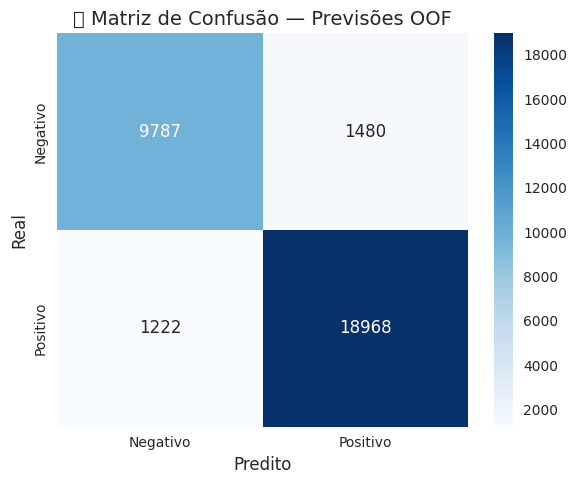

📋 Classification Report:
              precision    recall  f1-score   support

    Negativo       0.89      0.87      0.88     11267
    Positivo       0.93      0.94      0.93     20190

    accuracy                           0.91     31457
   macro avg       0.91      0.90      0.91     31457
weighted avg       0.91      0.91      0.91     31457



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 🎯 Valores reais (review_score) e previstos (oof_label)
true_labels = df_oof_results["review_score"]
pred_labels = df_oof_results["oof_label"]

# 📊 Matriz de confusão
conf_matrix = confusion_matrix(true_labels, pred_labels)

# 🖼️ Plot da matriz de confusão
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negativo", "Positivo"],
            yticklabels=["Negativo", "Positivo"])
plt.title("🔍 Matriz de Confusão — Previsões OOF")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

# 📝 Relatório detalhado de classificação
print("📋 Classification Report:")
print(classification_report(true_labels, pred_labels, target_names=["Negativo", "Positivo"]))


In [ ]:
# ⚠️ Adiciona os comentários de review para análise de erro
df_oof_results["review_comment_message"] = df["review_comment_message"].values

# 🧪 Identifica os erros
false_positives = df_oof_results[(df_oof_results["review_score"] == 0) & (df_oof_results["oof_label"] == 1)]
false_negatives = df_oof_results[(df_oof_results["review_score"] == 1) & (df_oof_results["oof_label"] == 0)]

# 📊 Resumo
print(f"❌ False Positives (Previsto Positivo, mas é Negativo): {len(false_positives)}")
display(false_positives[["review_id", "review_score", "oof_pred", "oof_label", "review_comment_message"]].head())

print(f"\n❌ False Negatives (Previsto Negativo, mas é Positivo): {len(false_negatives)}")
display(false_negatives[["review_id", "review_score", "oof_pred", "oof_label", "review_comment_message"]].head())


❌ False Positives (Previsto Positivo, mas é Negativo): 0


Empty DataFrame
Columns: [review_id, review_score, oof_pred, oof_label, review_comment_message]
Index: []


❌ False Negatives (Previsto Negativo, mas é Positivo): 20190


review_id  review_score  oof_pred  oof_label  \
3  9d5cfc4943f6f724a28d60f8762d2860             1     0.000          0   
4  03557726ff6e30acaff4519c8cc33765             1     0.000          0   
5  6b2e3685938d9e90a4fd95ded26c702f             1     0.000          0   
8  3546fd00cf5d6ab5e204d7464dbc151a             1     0.000          0   
9  c028eb71f53d52fdeb2a3b015eb489bb             1     0.000          0   

                              review_comment_message  
3                              muito rápido e seguro  
4              Produto de qualidade e entrega rápida  
5                                Eu adorei recomendo  
8  Recebi dentro do prazo,entrega rápida gostei m...  
9  PARABÉNS MAIS UMA VEZ PELO COMPROMISSO ASSUMID...

## 📈 Otimização de Threshold com Curva F1-score

Nesta etapa, utilizamos a curva de **precisão vs. recall** para calcular o F1-score em diferentes valores de threshold, buscando identificar o melhor ponto de corte para transformar probabilidades em classes.

---

### ⚙️ Estratégia:

1. Gerar a curva `precision-recall` usando `precision_recall_curve()`
2. Calcular o `F1-score` em cada ponto:


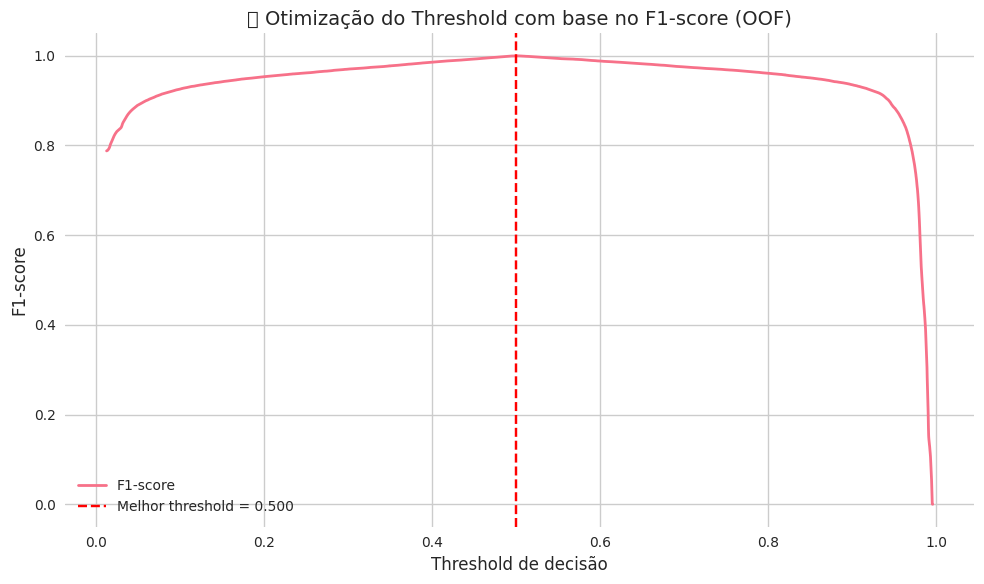

✅ Melhor F1-score: 1.0000 com threshold ótimo: 0.500


In [ ]:
from sklearn.metrics import precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt

# 📈 Calcula precisão, recall e thresholds com base nas previsões OOF
precision, recall, thresholds = precision_recall_curve(oof_labels, oof_preds)

# 🧠 Calcula F1-score para cada threshold (evitando divisão por zero)
f1_scores = np.where(
    (precision + recall) > 0,
    2 * (precision * recall) / (precision + recall),
    0
)

# 🔍 Identifica o melhor threshold
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

# 📊 Visualiza F1-score em função do threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores[:-1], label="F1-score", linewidth=2)
plt.axvline(best_threshold, linestyle="--", color="red", label=f"Melhor threshold = {best_threshold:.3f}")
plt.title("🔎 Otimização do Threshold com base no F1-score (OOF)", fontsize=14)
plt.xlabel("Threshold de decisão", fontsize=12)
plt.ylabel("F1-score", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ✅ Exibe o melhor resultado
print(f"✅ Melhor F1-score: {best_f1:.4f} com threshold ótimo: {best_threshold:.3f}")


# Teste do Modelo

In [ ]:
import pandas as pd
from pathlib import Path

# 📁 Caminho para o arquivo de teste
TEST_PATH = Path("/content/data/raw/test.csv")  # ajuste conforme necessário

# 📄 Leitura do CSV
df_test = pd.read_csv(TEST_PATH)

# 🔍 Visualização inicial
print(f"🔢 Formato do dataset: {df_test.shape}")
print("🧾 Colunas disponíveis:", df_test.columns.tolist())

# 🧹 Tratamento de valores ausentes
df_test["review_comment_message"] = df_test["review_comment_message"].fillna("").astype(str)
df_test["order_status"] = df_test["order_status"].fillna("unknown")
df_test["customer_state"] = df_test["customer_state"].fillna("unknown")
df_test["product_category_name"] = df_test["product_category_name"].fillna("unknown")


🔢 Formato do dataset: (7865, 5)
🧾 Colunas disponíveis: ['review_id', 'review_comment_message', 'customer_state', 'order_status', 'product_category_name']


In [ ]:
import joblib

# 📁 Caminho dos encoders salvos
ENCODER_DIR = Path("/content/data/processed/encoders")

# 📦 Carregamento dos encoders
order_status_encoder = joblib.load(ENCODER_DIR / "order_status_ordinal.pkl")
customer_state_encoder = joblib.load(ENCODER_DIR / "customer_state_le.pkl")
product_category_encoder = joblib.load(ENCODER_DIR / "product_category_le.pkl")

# 🧮 Aplicação dos encoders
df_test["order_status_encoded"] = order_status_encoder.transform(df_test[["order_status"]])  # OrdinalEncoder requer reshape
df_test["customer_state_encoded"] = customer_state_encoder.transform(df_test["customer_state"])
df_test["product_category_encoded"] = product_category_encoder.transform(df_test["product_category_name"])


In [ ]:
# 🔧 Funções auxiliares
def count_words(text, word_list):
    return sum(1 for word in text.lower().split() if word in word_list)

def count_bigrams(text, bigram_list):
    words = text.lower().split()
    bigrams = list(zip(words, words[1:]))
    return sum(1 for bg in bigrams if bg in bigram_list)

def has_exclamation(text):
    return int("!" in text)

def has_uppercase(text):
    return int(any(char.isupper() for char in text if char.isalpha()))

# 📚 Listas fixas (iguais às utilizadas no treinamento)
positive_words = {"ótimo", "bom", "excelente", "recomendo", "maravilhoso", "amei", "adorei"}
negative_words = {"péssimo", "ruim", "horrível", "demora", "reclamei", "estragado", "atrasou"}

positive_bigrams = {("muito", "bom"), ("ótimo", "produto"), ("bem", "embalado")}
negative_bigrams = {("não", "gostei"), ("muito", "ruim"), ("produto", "estragado")}

# 🧪 Geração das novas features textuais
df_test["text_length_chars"] = df_test["review_comment_message"].apply(len)
df_test["text_length_words"] = df_test["review_comment_message"].apply(lambda x: len(x.split()))
df_test["has_exclamation"] = df_test["review_comment_message"].apply(has_exclamation)
df_test["has_uppercase"] = df_test["review_comment_message"].apply(has_uppercase)

df_test["pos_word_count"] = df_test["review_comment_message"].apply(lambda x: count_words(x, positive_words))
df_test["neg_word_count"] = df_test["review_comment_message"].apply(lambda x: count_words(x, negative_words))
df_test["emotional_density"] = (df_test["pos_word_count"] + df_test["neg_word_count"]) / (df_test["text_length_words"] + 1)

df_test["pos_bigram_count"] = df_test["review_comment_message"].apply(lambda x: count_bigrams(x, positive_bigrams))
df_test["neg_bigram_count"] = df_test["review_comment_message"].apply(lambda x: count_bigrams(x, negative_bigrams))
df_test["emotional_density_bigram"] = (df_test["pos_bigram_count"] + df_test["neg_bigram_count"]) / (df_test["text_length_words"] + 1)

# 💾 Salvamento do dataset com features
FEATURED_PATH = Path("/content/data/processed/test_featured.csv")
FEATURED_PATH.parent.mkdir(parents=True, exist_ok=True)
df_test.to_csv(FEATURED_PATH, index=False)

print("✅ Arquivo salvo:", FEATURED_PATH)


✅ Arquivo salvo: /content/data/processed/test_featured.csv


In [ ]:
from transformers import BertTokenizerFast
from torch.utils.data import Dataset, DataLoader
import torch
import pandas as pd
from pathlib import Path

# 📂 Caminho para o CSV com features já processadas
FEATURED_PATH = Path("/content/data/processed/test_featured.csv")
df_test = pd.read_csv(FEATURED_PATH)

# 💬 Tokenização da coluna de texto
TEXT_COL = "review_comment_message"
df_test[TEXT_COL] = df_test[TEXT_COL].fillna("").astype(str)

tokenizer = BertTokenizerFast.from_pretrained("neuralmind/bert-base-portuguese-cased")
test_tok = tokenizer(
    df_test[TEXT_COL].tolist(),
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors="pt"
)

# 🔢 Colunas de entrada (iguais ao treinamento)
CATEGORICAL_COLS = ["order_status_encoded", "customer_state_encoded", "product_category_encoded"]
NUMERICAL_COLS = [
    "text_length_chars", "text_length_words", "has_exclamation", "has_uppercase",
    "faz s", "neg_word_count", "emotional_density",
    "pos_bigram_count", "neg_bigram_count", "emotional_density_bigram"
]

# 🧺 Classe personalizada para carregar dados para o modelo
class ReviewDataset(Dataset):
    def __init__(self, tokenized, df, cat_cols, num_cols):
        self.input_ids = tokenized["input_ids"]
        self.attention_mask = tokenized["attention_mask"]
        self.cat_feats = torch.tensor(df[cat_cols].values, dtype=torch.long)
        self.num_feats = torch.tensor(df[num_cols].values, dtype=torch.float32)

    def __len__(self):
        return len(self.cat_feats)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "categorical": self.cat_feats[idx],
            "numerical": self.num_feats[idx]
        }

# 📦 Criação do DataLoader para inferência
test_dataset = ReviewDataset(test_tok, df_test, CATEGORICAL_COLS, NUMERICAL_COLS)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [ ]:
import numpy as np
import torch
import joblib
import pandas as pd
from pathlib import Path

# 📦 Carregar encoders para obter cat_dims
ENCODER_DIR = Path("/content/data/processed/encoders")
order_status_encoder = joblib.load(ENCODER_DIR / "order_status_ordinal.pkl")
customer_state_encoder = joblib.load(ENCODER_DIR / "customer_state_le.pkl")
product_category_encoder = joblib.load(ENCODER_DIR / "product_category_le.pkl")

# 🔢 Determinar cat_dims dinamicamente
def get_encoder_dim(encoder):
    if hasattr(encoder, "categories_"):  # OrdinalEncoder
        return len(encoder.categories_[0])
    elif hasattr(encoder, "classes_"):   # LabelEncoder
        return len(encoder.classes_)
    else:
        raise ValueError("Tipo de encoder desconhecido.")

cat_dims = [
    get_encoder_dim(order_status_encoder),
    get_encoder_dim(customer_state_encoder),
    get_encoder_dim(product_category_encoder)
]

# 🔧 Configuração
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
N_FOLDS = 5
THRESHOLD = 0.52
model_dir = Path("/content/models")

# Inicializar predições do ensemble
ensemble_preds = np.zeros(len(df_test))

# Inferência com ensemble
for fold in range(1, N_FOLDS + 1):
    print(f"🔍 Inferindo com modelo Fold {fold}")

    # ⚖️ Aplicar scaler correspondente ao fold
    scaler = joblib.load(model_dir / f"scaler_fold{fold}.pkl")
    df_test_scaled = df_test.copy()
    df_test_scaled[NUMERICAL_COLS] = scaler.transform(df_test_scaled[NUMERICAL_COLS])

    # Criar dataset e dataloader com dados escalados
    test_dataset = ReviewDataset(test_tok, df_test_scaled, CATEGORICAL_COLS, NUMERICAL_COLS)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Carregar modelo treinado
    model = HybridBERTClassifier(cat_dims=cat_dims, num_numerical=len(NUMERICAL_COLS)).to(DEVICE)
    model_path = model_dir / f"model_fold{fold}_best_model.pt"
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.eval()

    # Inferência
    fold_preds = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            categorical = batch["categorical"].to(DEVICE)
            numerical = batch["numerical"].to(DEVICE)

            outputs = model(input_ids, attention_mask, categorical, numerical)
            fold_preds.extend(outputs.squeeze().cpu().numpy())

    # Acumular predições
    ensemble_preds += np.array(fold_preds)

# 🎯 Média das predições dos 5 folds
ensemble_preds /= N_FOLDS

# 🟢 Aplicar threshold final
pred_labels = (ensemble_preds >= THRESHOLD).astype(int)

# 💾 Gerar arquivo de submissão
submission = pd.DataFrame({
    "review_id": df_test["review_id"],
    "review_score": pred_labels
})

SUBMISSION_PATH = Path("/content/outputs/submission.csv")
SUBMISSION_PATH.parent.mkdir(parents=True, exist_ok=True)
submission.to_csv(SUBMISSION_PATH, index=False)

print("✅ Arquivo de submissão salvo em:", SUBMISSION_PATH)


🔍 Inferindo com modelo Fold 1
🔍 Inferindo com modelo Fold 2
🔍 Inferindo com modelo Fold 3
🔍 Inferindo com modelo Fold 4
🔍 Inferindo com modelo Fold 5
✅ Arquivo de submissão salvo em: /content/outputs/submission.csv


In [ ]:
ensemble_preds

array([0.98699005, 0.22582504, 0.03509339, ..., 0.70127015, 0.02578043,
       0.05510827])

In [ ]:
import numpy as np
from sklearn.metrics import f1_score

def find_best_threshold(y_true, y_probs):
    thresholds = np.arange(0.1, 0.91, 0.01)
    best_threshold = 0.5
    best_f1 = 0.0

    for t in thresholds:
        y_pred = (y_probs >= t).astype(int)
        f1 = f1_score(y_true, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = t

    return best_threshold, best_f1


In [ ]:
# oof_preds = probabilidades geradas nos dados de validação cruzada (concatenadas de todos os folds)
# targets = rótulos verdadeiros correspondentes

best_threshold, best_f1 = find_best_threshold(targets, oof_preds)

print(f"🔍 Melhor threshold encontrado: {best_threshold:.2f}")
print(f"📈 F1-score com threshold otimizado: {best_f1:.4f}")


🔍 Melhor threshold encontrado: 0.52
📈 F1-score com threshold otimizado: 0.9340


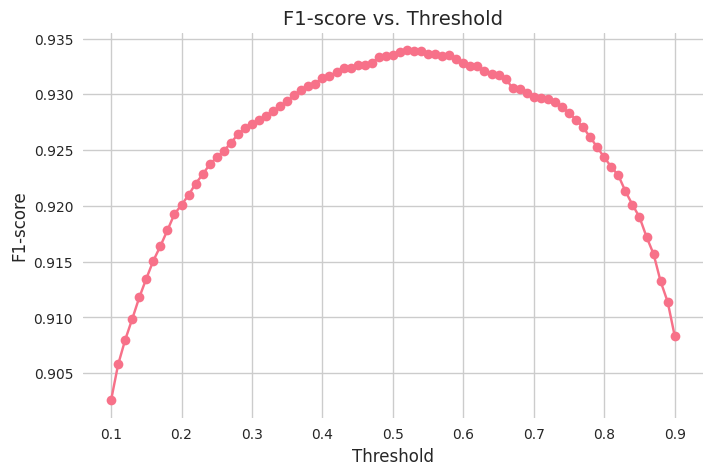

In [ ]:
import matplotlib.pyplot as plt

def plot_f1_threshold_curve(y_true, y_probs):
    thresholds = np.arange(0.1, 0.91, 0.01)
    f1_scores = [f1_score(y_true, (y_probs >= t).astype(int)) for t in thresholds]

    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, f1_scores, marker='o')
    plt.title("F1-score vs. Threshold")
    plt.xlabel("Threshold")
    plt.ylabel("F1-score")
    plt.grid(True)
    plt.show()

# Chamar após a função anterior
plot_f1_threshold_curve(targets, oof_preds)
